In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import pickle as pkl


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [6]:
era850 = readERA('v850')
era850 = era850.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [7]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = era850.salem.lookup_transform(topo)

In [8]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
tir_monthly = tir_doypick.resample(time = '1m').mean()

In [9]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65)).where(topo_on_g>=2000)
chirps_bimod = chirps_doypick#.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))
chirps_monthly = chirps_doypick.resample(time = '1m').mean()

In [10]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)


In [11]:
corrdic = pkl.load(open(cnst.network_data + 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [12]:
lat_pick = topo_on_g.latitude.values
corr_start = corrdic['start_3d']
corr_end = corrdic['end_5d']

In [13]:
for r in regions.keys():
    mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
    sedoy = (np.mean(corr_start[mask]), np.mean(corr_end[mask]))
    regions[r].append(sedoy)

In [14]:
regions['central']

[(-12, -8),
 (<xarray.DataArray ()>
  array(265.49667406),
  <xarray.DataArray ()>
  array(109.66184971))]

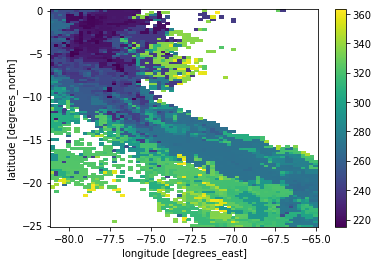

In [15]:
corr_start.plot()

In [16]:
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_1mm_3-7days_StartOfSpell.nc')

In [17]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_1mm_3-7days_StartOfSpell.nc')
alls = regions['central']

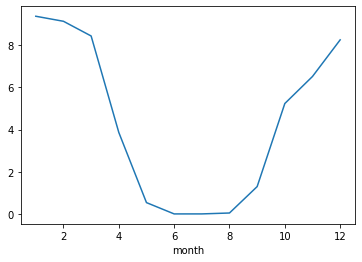

In [18]:
wet_test.where(wet_test>=3).sel(latitude=slice(alls[0][0], alls[0][1])).count(['latitude','longitude']).groupby('time.month').mean().plot()

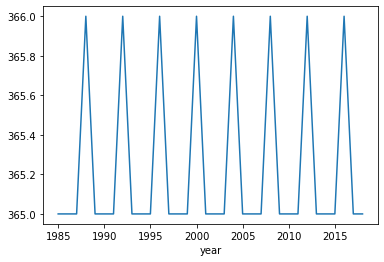

In [19]:
dry_test.where(dry_test>=7).sel(latitude=slice(alls[0][0], alls[0][1])).count(['latitude','longitude']).groupby(wet_test['time.year']).count().plot()

In [20]:
vvod = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/VOD/onERA/*.nc').sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [21]:
ndvi = xr.open_dataset('/media/ck/Elements/SouthAmerica/NDVI/onERA/NDVI_all_times.nc').sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [22]:
cut = dry_test # spell
dat = cut.sel(time=cut['time.year']>=2000)
chdat = chirps_doypick.sel(time=cut['time.year']>=2000)
vod_clim = vvod['vod'].groupby('time.dayofyear').mean('time').rolling(dayofyear=30, min_periods=1, center=True).mean()
ndvi_clim = ndvi['precip'].groupby('time.dayofyear').mean('time').rolling(
dayofyear=3, min_periods=1, center=True).mean()
vod = vvod['vod'].rolling(time=3, min_periods=1, center=True).mean()
vod_diff = vod_clim.max('dayofyear')-vod_clim.min('dayofyear')

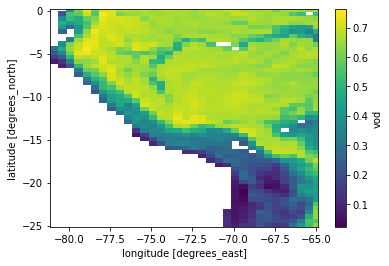

In [23]:
vvod['vod'].mean('time').plot()

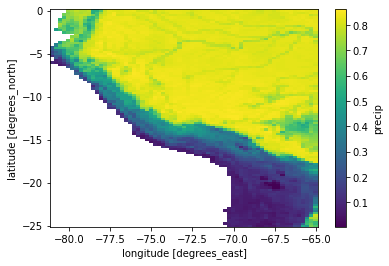

In [24]:
ndvi['precip'].mean('time').plot()

Text(0.5, 1.0, 'Climatological seasonal cycle (2000-2018), Huaraz pixel')

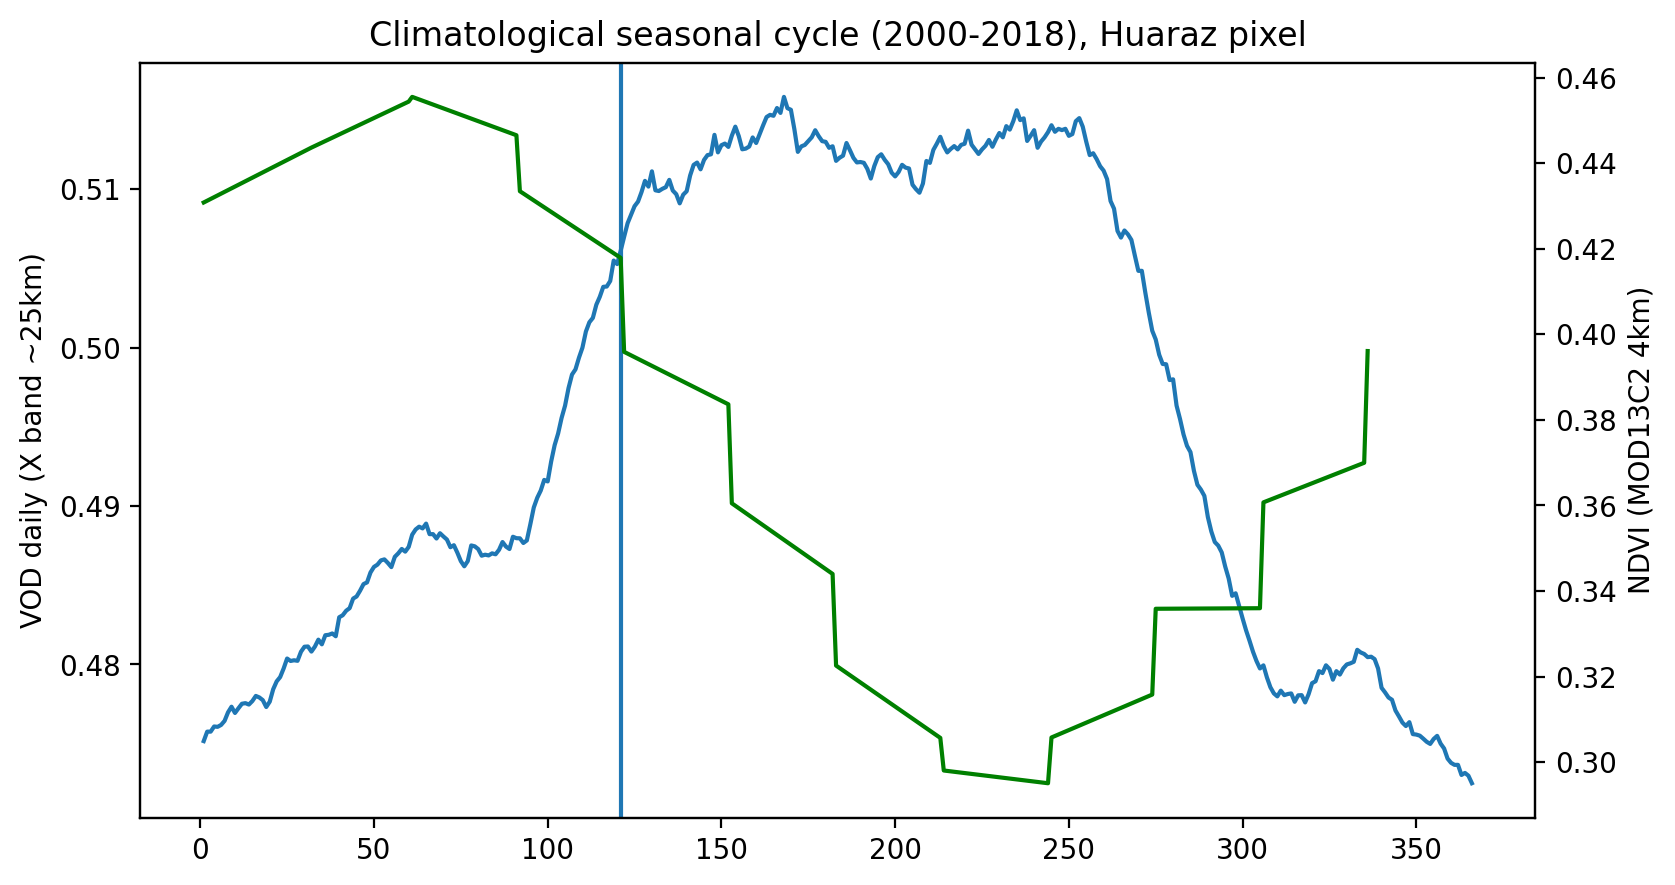

In [25]:
f = plt.figure(figsize=(9,5),dpi=200)
ax = f.add_subplot(111)
ax1 = ax.twinx()
ax.plot(vod_clim.dayofyear, vod_clim.sel(latitude=-9.3, longitude=-77.5, method='nearest'))
ax.set_ylabel('VOD daily (X band ~25km)')
ax1.plot(ndvi_clim.dayofyear, ndvi_clim.sel(latitude=-9.3, longitude=-77.5, method='nearest'), color='g')
ax1.set_ylabel('NDVI (MOD13C2 4km)')
ax.axvline(121)
ax.set_title('Climatological seasonal cycle (2000-2018), Huaraz pixel')

In [47]:
def vod_composite(vod, chirps, spell_length, topo, region='central', tag='dry'):
    
#     regions = {
#     'equatorial' : [(-5,0)],
#     'transition' : [(-8,-5)],
#     'central' : [(-12,-8)],
#     'southern' : [(-18,-15)]}
#     h = 2000
    alls = regions[r]
    
    #ipdb.set_trace()
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    
    area = 0.15
    
    #spells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_v2_1mm_fromRegional_areaCheck.p", "rb"))
    spells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    
    sp = spells[tag+str(spell_length)]
    
    sp = sp[sp.year>=2000]
    
    #sp = spell_dat.sel(latitude=slice(alls[0][0], alls[0][1])).where(topo>h)
    chirp = chirps.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((chirps['time.dayofyear']>=doys_s) | (chirps['time.dayofyear']<=doys_e))).load()#.mean(['latitude','longitude'])
    
    vo = vod['vod'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((vod['time.dayofyear']>=doys_s) | (vod['time.dayofyear']<=doys_e)))#.mean(['latitude','longitude'])
    vo_clim = vo.groupby(vo['time.dayofyear']).mean().rolling(dayofyear=3, min_periods=1, center=True).mean()
#     vo_clim = vod_clim.sel(latitude=slice(alls[0][0], alls[0][1])).where(topo>h).mean(['latitude','longitude'])
#     vo_diff = vod_diff.sel(latitude=slice(alls[0][0], alls[0][1])).where(topo>h).mean(['latitude','longitude'])
    
    ns = 22
    chllist = np.arange(ns)*0
    chcnt = np.arange(ns)*0.

    llist = np.arange(ns)*0
    cnt = np.arange(ns)*0.

    llist_clim = np.arange(ns)*0
    cnt_clim = np.arange(ns)*0.
    
    llist_diff = np.arange(ns)*0
    cnt_diff = np.arange(ns)*0.
    isnb = 0

    for dd in sp:
        
        print(dd)
        

        #dd = pd.Timestamp(dd.values)
        dtime = dd.replace(hour=12)
        
        dtime2 = dtime + pd.Timedelta('18 days')
        dtime1 = dtime - pd.Timedelta('3 days')
        chdtime1 =  dtime - pd.Timedelta('4 days')
        
        chtime = chirp.sel(time=slice(chdtime1,dtime2))#.mean(['latitude','longitude'])
        
        if tag == 'dry':
            try:
                chmask = chtime.squeeze() < 1
            except:
                print('time not found, continue')
                continue

        if tag == 'wet':
            try:
                chmask = chtime.squeeze() > 1
            except:
                print('time not found, continue')
                continue
                
        if (chtime.time.size) == 0:
            continue
                
        print(vo.sel(time=slice(dtime1,dtime2)).time.size, chtime.time.size)
        print(vo.sel(time=slice(dtime1,dtime2)).time.values[0], chtime.time.values[0])
        
        if (vo.sel(time=slice(dtime1,dtime2)).time.size) != (chtime.time.size):
            print('Different size')
            continue
            
        chtime = chtime.where(chmask).mean(['latitude','longitude'])
        #ipdb.set_trace()
        
        ntime = vo.sel(time=slice(dtime1,dtime2)).where(chmask.values).mean(['latitude','longitude'])#.sel(latitude=y, longitude=x)
        #ipdb.set_trace()
        #.sel(latitude=y, longitude=x)
        try:
            nclim = vo_clim.sel(dayofyear=slice(dtime1.dayofyear,dtime2.dayofyear)).where(chmask.values).mean(['latitude','longitude'])#.sel(latitude=y, longitude=x)
        except:
            continue
        ndiff = ntime - nclim

        
        #ipdb.set_trace()
        try:
            cnt = cnt+np.isfinite(ntime.values).astype(int)
            cnt_clim = cnt_clim+np.isfinite(nclim.values).astype(int)
            cnt_diff = cnt_diff+np.isfinite(ndiff.values).astype(int)
            chcnt = chcnt+np.isfinite(chtime.values).astype(int)


            ntime = ntime.where(np.isfinite(ntime), other=0).values
            chtime = chtime.where(np.isfinite(chtime), other=0).values
            nclim = nclim.where(np.isfinite(nclim), other=0).values
            ndiff = ndiff.where(np.isfinite(ndiff), other=0).values

            llist = llist+ntime
            llist_clim = llist_clim+nclim
            llist_diff = llist_diff+ndiff
            chllist = chllist+chtime
        except:
            print('something wrong')
            continue
        print('Doing', isnb)
        isnb +=1
                    
    return chllist, chcnt, llist, cnt, llist_clim, llist_diff, cnt_clim, cnt_diff

In [ ]:
ch3, chcnt3, vod3, vodcnt3, vodclim3, voddiff3, vodclimcnt3, voddiffcnt3 = vod_composite(vvod, chirps_doypick, 3, topo_on_g, region='central', tag='dry')
ch5, chcnt5, vod5, vodcnt5, vodclim5, voddiff5, vodclimcnt5, voddiffcnt5 = vod_composite(vvod, chirps_doypick, 5, topo_on_g, region='central', tag='dry')
ch7, chcnt7, vod7, vodcnt7, vodclim7, voddiff7, vodclimcnt7, voddiffcnt7 = vod_composite(vvod, chirps_doypick, 7, topo_on_g, region='central', tag='dry')

2000-01-03 00:00:00
21 22
2000-01-01T12:00:00.000000000 1999-12-31T00:00:00.000000000
Different size
2000-01-12 00:00:00
22 22
2000-01-09T12:00:00.000000000 2000-01-09T00:00:00.000000000
Doing 0
2000-02-22 00:00:00
22 22
2000-02-19T12:00:00.000000000 2000-02-19T00:00:00.000000000
Doing 1
2000-03-25 00:00:00
2000-04-02 00:00:00
2000-04-10 00:00:00
2000-09-17 00:00:00
2000-11-17 00:00:00
22 22
2000-11-14T12:00:00.000000000 2000-11-14T00:00:00.000000000
Doing 2
2000-12-31 00:00:00
22 22
2000-12-28T12:00:00.000000000 2000-12-28T00:00:00.000000000
2001-01-25 00:00:00
22 22
2001-01-22T12:00:00.000000000 2001-01-22T00:00:00.000000000
Doing 3
2001-04-03 00:00:00
2001-04-09 00:00:00
2001-09-18 00:00:00
2001-09-29 00:00:00
2001-12-02 00:00:00
22 22
2001-11-29T12:00:00.000000000 2001-11-29T00:00:00.000000000
Doing 4
2001-12-21 00:00:00
22 22
2001-12-18T12:00:00.000000000 2001-12-18T00:00:00.000000000
2002-01-11 00:00:00
22 22
2002-01-08T12:00:00.000000000 2002-01-08T00:00:00.000000000
Doing 5
200

Doing 73
2014-12-05 00:00:00
22 22
2014-12-02T12:00:00.000000000 2014-12-02T00:00:00.000000000
Doing 74
2014-12-19 00:00:00
22 22
2014-12-16T12:00:00.000000000 2014-12-16T00:00:00.000000000
2014-12-24 00:00:00
22 22
2014-12-21T12:00:00.000000000 2014-12-21T00:00:00.000000000
2015-02-01 00:00:00
22 22
2015-01-29T12:00:00.000000000 2015-01-29T00:00:00.000000000
Doing 75
2015-02-21 00:00:00
22 22
2015-02-18T12:00:00.000000000 2015-02-18T00:00:00.000000000
Doing 76
2015-03-07 00:00:00
10 10
2015-03-04T12:00:00.000000000 2015-03-04T00:00:00.000000000
something wrong
2015-03-22 00:00:00
2015-04-02 00:00:00
2015-04-25 00:00:00
2015-09-15 00:00:00
2015-10-01 00:00:00
2 2
2015-10-18T12:00:00.000000000 2015-10-18T00:00:00.000000000
something wrong
2015-11-14 00:00:00
22 22
2015-11-11T12:00:00.000000000 2015-11-11T00:00:00.000000000
Doing 77
2016-01-16 00:00:00
22 22
2016-01-13T12:00:00.000000000 2016-01-13T00:00:00.000000000
Doing 78
2016-01-21 00:00:00
22 22
2016-01-18T12:00:00.000000000 2016-0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


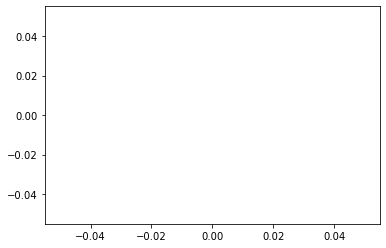

In [28]:
plt.plot(vod5/vodcnt5)

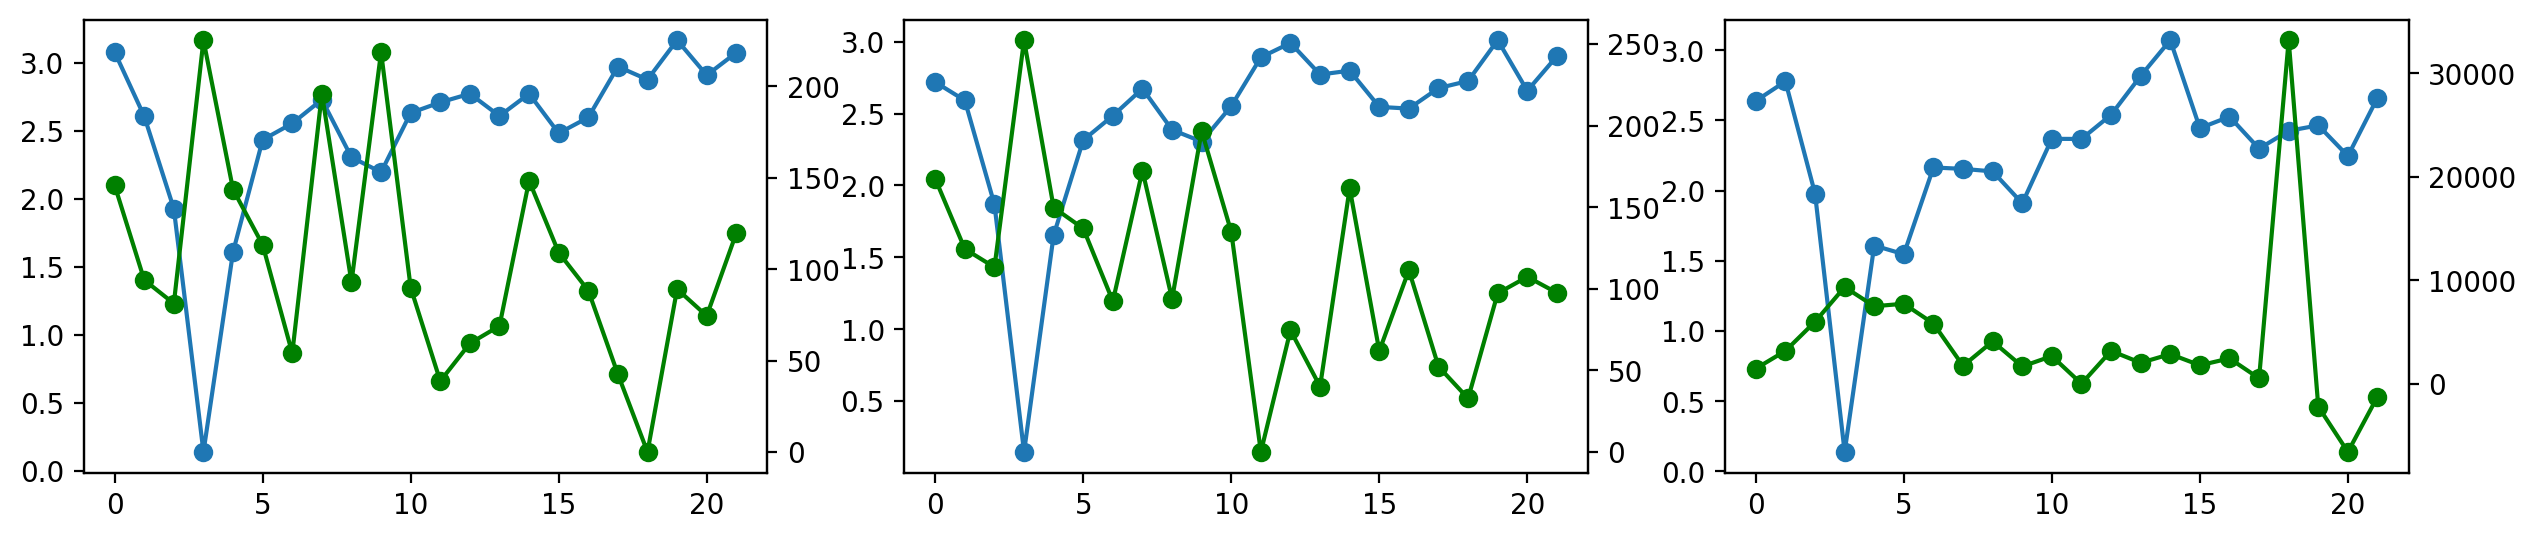

In [59]:
f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(131)
ax1 = ax.twinx()
ax.plot(ch3/chcnt3, marker='o')
ax1.plot((vod3/vodcnt3-np.min(vod3/vodcnt3))/(voddiff3/voddiffcnt3)[0]*100, color='green', marker='o')
#ax1.axhline((voddiff3/voddiffcnt3)[0])

ax = f.add_subplot(132)
ax1 = ax.twinx()
ax.plot(ch5/chcnt5, marker='o')
ax1.plot(((vod5/vodcnt5)-np.min(vod5/vodcnt5))/(voddiff5/voddiffcnt5)[0]*100, color='green', marker='o')  #(vod5/vodcnt5)
#ax1.axhline((voddiff5/voddiffcnt5)[0])
#ax1.plot((voddiff5/voddiffcnt5))

ax = f.add_subplot(133)
ax1 = ax.twinx()
ax.plot(ch7/chcnt7, marker='o')
ax1.plot(((vod7/vodcnt7)-np.min(vod7/vodcnt7))/(voddiff7/voddiffcnt7)[0]*100, color='green', marker='o')
#ax1.axhline((voddiff7/voddiffcnt7)[0])

In [75]:
ch3_eq, chcnt3_eq, vod3_eq, vodcnt3_eq, vodclim3_eq, vodclimcnt3_eq = vod_composite(dat, vod, vod_clim, chdat, 3, topo_on_g, region='northern')
ch5_eq, chcnt5_eq, vod5_eq, vodcnt5_eq, vodclim5_eq, vodclimcnt5_eq = vod_composite(dat, vod, vod_clim, chdat, 5, topo_on_g, region='northern')
ch7_eq, chcnt7_eq, vod7_eq, vodcnt7_eq, vodclim7_eq, vodclimcnt7_eq = vod_composite(dat, vod, vod_clim, chdat, 7, topo_on_g, region='northern')

Doing -81.0 -8.0
Doing -81.0 -7.75
Doing -81.0 -7.5
Doing -81.0 -7.25
Doing -81.0 -7.0
Doing -81.0 -6.75
Doing -81.0 -6.5
Doing -81.0 -6.25
Doing -81.0 -6.0
Doing -81.0 -5.75
Doing -81.0 -5.5
Doing -81.0 -5.25
Doing -81.0 -5.0
Doing -81.0 -4.75
Doing -81.0 -4.5
Doing -81.0 -4.25
Doing -81.0 -4.0
Doing -81.0 -3.75
Doing -81.0 -3.5
Doing -81.0 -3.25
Doing -81.0 -3.0
Doing -81.0 -2.75
Doing -81.0 -2.5
Doing -81.0 -2.25
Doing -81.0 -2.0
Doing -81.0 -1.75
Doing -81.0 -1.5
Doing -81.0 -1.25
Doing -81.0 -1.0
Doing -81.0 -0.75
Doing -81.0 -0.5
Doing -81.0 -0.25
Doing -81.0 0.0
Doing -80.75 -8.0
Doing -80.75 -7.75
Doing -80.75 -7.5
Doing -80.75 -7.25
Doing -80.75 -7.0
Doing -80.75 -6.75
Doing -80.75 -6.5
Doing -80.75 -6.25
Doing -80.75 -6.0
Doing -80.75 -5.75
Doing -80.75 -5.5
Doing -80.75 -5.25
Doing -80.75 -5.0
Doing -80.75 -4.75
Doing -80.75 -4.5
Doing -80.75 -4.25
Doing -80.75 -4.0
Doing -80.75 -3.75
Doing -80.75 -3.5
Doing -80.75 -3.25
Doing -80.75 -3.0
Doing -80.75 -2.75
Doing -80.75 -2.5

Doing 428
Doing 429
something wrong
Doing 430
Doing 431
Doing 432
Doing 433
Doing 434
Doing 435
Doing 436
something wrong
Doing 437
Doing 438
Doing 439
Doing 440
Doing 441
Doing 442
Doing 443
Doing 444
something wrong
Doing 445
Doing 446
Doing 447
Doing 448
Doing 449
Doing 450
Doing 451
Doing 452
Doing 453
Doing 454
Doing 455
Doing 456
Doing 457
Doing 458
Doing 459
Doing 460
Doing 461
Doing 462
Doing 463
Doing 464
Doing 465
Doing 466
Doing 467
Doing 468
Doing 469
Doing 470
Doing 471
Doing 472
Doing 473
Doing 474
Doing 475
Doing 476
Doing 477
Doing 478
Doing 479
Doing 480
Doing 481
Doing 482
Doing 483
Doing 484
Doing 485
Doing 486
Doing 487
Doing 488
Doing 489
Doing 490
Doing 491
Doing 492
Doing 493
Doing 494
Doing 495
Doing 496
Doing 497
Doing 498
Doing 499
Doing 500
Doing 501
Doing 502
Doing 503
Doing 504
Doing 505
Doing 506
something wrong
Doing -79.5 -3.25
Doing 507
Doing 508
Doing 509
Doing 510
something wrong
Doing 511
Doing 512
Doing 513
something wrong
Doing 514
Doing 515
Doing 

Doing 1148
Doing 1149
Doing 1150
Doing 1151
Doing 1152
Doing 1153
Doing 1154
Doing 1155
Doing 1156
Doing 1157
Doing 1158
Doing 1159
Doing 1160
Doing 1161
Doing 1162
Doing 1163
Doing 1164
Doing 1165
Doing 1166
something wrong
Doing 1167
Doing 1168
Doing 1169
Doing 1170
Doing 1171
Doing 1172
Doing 1173
Doing 1174
Doing 1175
Doing 1176
Doing 1177
Doing 1178
Doing 1179
Doing 1180
Doing 1181
Doing 1182
Doing 1183
Doing 1184
Doing 1185
something wrong
Doing 1186
Doing 1187
Doing 1188
Doing 1189
Doing 1190
Doing 1191
Doing 1192
Doing 1193
Doing 1194
Doing 1195
Doing 1196
Doing 1197
Doing 1198
Doing 1199
Doing 1200
Doing 1201
Doing 1202
something wrong
Doing 1203
Doing 1204
Doing 1205
Doing 1206
something wrong
Doing 1207
Doing 1208
Doing 1209
Doing 1210
Doing 1211
Doing 1212
Doing 1213
Doing 1214
Doing 1215
Doing 1216
Doing 1217
Doing 1218
Doing 1219
Doing 1220
Doing 1221
Doing 1222
Doing 1223
Doing 1224
Doing 1225
something wrong
Doing 1226
Doing 1227
Doing 1228
Doing 1229
Doing 1230
Doing 1

Doing 1848
Doing 1849
Doing 1850
Doing 1851
Doing 1852
Doing 1853
Doing 1854
Doing 1855
Doing 1856
Doing 1857
Doing 1858
Doing 1859
Doing 1860
Doing 1861
Doing 1862
Doing 1863
Doing 1864
Doing 1865
Doing 1866
Doing 1867
Doing 1868
Doing 1869
Doing 1870
Doing 1871
something wrong
Doing 1872
Doing 1873
Doing 1874
Doing 1875
Doing 1876
Doing 1877
Doing -79.25 -3.0
Doing 1878
Doing 1879
Doing 1880
Doing 1881
Doing 1882
Doing 1883
Doing 1884
Doing 1885
Doing 1886
Doing 1887
Doing 1888
Doing 1889
something wrong
something wrong
Doing 1890
Doing 1891
Doing 1892
Doing 1893
Doing 1894
Doing 1895
Doing 1896
Doing 1897
Doing 1898
Doing 1899
Doing 1900
Doing 1901
Doing 1902
Doing 1903
Doing 1904
Doing 1905
Doing 1906
Doing 1907
Doing 1908
Doing 1909
Doing 1910
something wrong
Doing 1911
Doing 1912
Doing 1913
Doing 1914
Doing 1915
Doing 1916
Doing 1917
Doing 1918
Doing 1919
Doing 1920
Doing 1921
Doing 1922
Doing 1923
Doing 1924
Doing 1925
Doing 1926
Doing 1927
Doing 1928
Doing 1929
Doing 1930
Doing

Doing 2517
Doing 2518
Doing 2519
Doing 2520
Doing 2521
Doing 2522
Doing 2523
Doing 2524
Doing 2525
Doing 2526
Doing 2527
Doing 2528
Doing 2529
Doing 2530
Doing 2531
Doing 2532
Doing 2533
Doing 2534
Doing 2535
Doing 2536
Doing 2537
something wrong
Doing -79.0 -5.5
Doing -79.0 -5.25
Doing -79.0 -5.0
Doing -79.0 -4.75
Doing -79.0 -4.5
Doing -79.0 -4.25
Doing 2538
Doing 2539
Doing 2540
Doing 2541
Doing 2542
Doing 2543
Doing 2544
Doing 2545
Doing 2546
Doing 2547
Doing 2548
Doing 2549
Doing 2550
Doing 2551
Doing 2552
Doing 2553
something wrong
Doing 2554
Doing 2555
Doing 2556
Doing 2557
Doing 2558
Doing 2559
Doing 2560
Doing 2561
Doing 2562
Doing 2563
Doing 2564
Doing 2565
Doing 2566
Doing 2567
Doing 2568
Doing 2569
Doing 2570
Doing 2571
Doing 2572
Doing 2573
Doing 2574
Doing 2575
Doing 2576
Doing 2577
Doing 2578
Doing 2579
Doing 2580
Doing 2581
Doing 2582
Doing 2583
Doing 2584
Doing 2585
Doing 2586
Doing 2587
something wrong
Doing 2588
Doing 2589
Doing 2590
Doing 2591
Doing 2592
something w

Doing 3191
Doing 3192
Doing 3193
Doing 3194
Doing 3195
Doing 3196
Doing 3197
Doing 3198
Doing 3199
Doing 3200
Doing 3201
Doing 3202
Doing 3203
Doing 3204
Doing 3205
Doing 3206
Doing 3207
Doing 3208
Doing 3209
Doing 3210
Doing 3211
Doing 3212
Doing 3213
Doing 3214
Doing 3215
Doing 3216
Doing 3217
Doing 3218
Doing 3219
Doing 3220
Doing 3221
Doing 3222
something wrong
Doing 3223
Doing 3224
Doing 3225
Doing 3226
Doing 3227
Doing 3228
Doing 3229
Doing 3230
Doing 3231
Doing 3232
Doing 3233
Doing 3234
Doing 3235
Doing 3236
Doing 3237
Doing 3238
Doing 3239
Doing 3240
Doing 3241
Doing 3242
Doing 3243
Doing 3244
Doing 3245
Doing 3246
something wrong
Doing 3247
Doing 3248
Doing 3249
Doing 3250
Doing 3251
Doing 3252
Doing 3253
Doing 3254
Doing 3255
Doing 3256
Doing 3257
Doing 3258
Doing 3259
Doing 3260
Doing 3261
Doing 3262
Doing 3263
Doing 3264
Doing 3265
Doing 3266
something wrong
Doing 3267
Doing 3268
Doing 3269
Doing 3270
something wrong
Doing 3271
Doing 3272
Doing 3273
Doing 3274
Doing 3275
D

Doing 3891
Doing 3892
Doing 3893
Doing 3894
Doing 3895
Doing 3896
Doing 3897
Doing 3898
Doing 3899
Doing 3900
Doing 3901
Doing 3902
Doing 3903
something wrong
Doing 3904
Doing 3905
Doing 3906
Doing 3907
Doing 3908
Doing 3909
Doing 3910
Doing 3911
Doing 3912
Doing 3913
Doing 3914
Doing 3915
Doing 3916
Doing 3917
Doing 3918
Doing 3919
Doing 3920
Doing 3921
Doing 3922
Doing 3923
Doing 3924
Doing 3925
something wrong
Doing 3926
Doing 3927
Doing 3928
Doing 3929
Doing 3930
Doing 3931
Doing 3932
Doing 3933
Doing 3934
Doing 3935
Doing 3936
Doing 3937
Doing 3938
Doing 3939
Doing 3940
Doing 3941
Doing 3942
Doing 3943
Doing 3944
Doing 3945
Doing 3946
Doing 3947
Doing 3948
something wrong
something wrong
something wrong
Doing 3949
Doing 3950
Doing 3951
Doing 3952
something wrong
Doing 3953
Doing 3954
Doing 3955
Doing 3956
Doing 3957
Doing 3958
Doing 3959
Doing 3960
Doing 3961
Doing 3962
Doing 3963
Doing 3964
Doing 3965
Doing 3966
Doing 3967
Doing 3968
Doing 3969
Doing 3970
Doing 3971
Doing 3972
Do

Doing 4566
Doing 4567
Doing 4568
Doing 4569
Doing 4570
Doing 4571
Doing 4572
Doing 4573
Doing 4574
Doing 4575
Doing 4576
Doing 4577
Doing 4578
Doing 4579
Doing 4580
Doing 4581
Doing 4582
Doing 4583
Doing 4584
Doing 4585
Doing 4586
Doing 4587
Doing 4588
Doing -78.75 -6.5
Doing 4589
Doing 4590
Doing 4591
Doing 4592
Doing 4593
Doing 4594
something wrong
Doing 4595
Doing 4596
Doing 4597
Doing 4598
Doing 4599
Doing 4600
Doing 4601
Doing 4602
something wrong
Doing 4603
Doing 4604
Doing 4605
Doing 4606
Doing 4607
Doing 4608
Doing 4609
Doing 4610
Doing 4611
Doing 4612
Doing 4613
Doing 4614
Doing 4615
Doing 4616
Doing 4617
Doing 4618
Doing 4619
Doing 4620
Doing 4621
Doing 4622
Doing 4623
Doing 4624
Doing 4625
something wrong
Doing 4626
Doing 4627
Doing 4628
Doing 4629
Doing 4630
Doing 4631
Doing 4632
Doing 4633
Doing 4634
Doing 4635
Doing 4636
Doing 4637
Doing 4638
Doing 4639
Doing 4640
Doing 4641
Doing 4642
Doing 4643
Doing 4644
Doing 4645
Doing 4646
Doing 4647
Doing 4648
Doing 4649
Doing 4650

Doing 5270
Doing 5271
Doing 5272
Doing 5273
Doing 5274
Doing 5275
Doing 5276
Doing 5277
Doing 5278
Doing 5279
Doing 5280
Doing 5281
Doing 5282
Doing 5283
Doing 5284
Doing 5285
Doing 5286
something wrong
Doing 5287
Doing 5288
Doing 5289
Doing 5290
Doing 5291
Doing 5292
something wrong
Doing 5293
Doing 5294
Doing 5295
Doing 5296
Doing 5297
Doing 5298
Doing 5299
Doing 5300
Doing 5301
Doing 5302
Doing 5303
Doing 5304
Doing 5305
Doing 5306
Doing 5307
Doing 5308
Doing 5309
Doing 5310
Doing 5311
Doing 5312
Doing 5313
Doing 5314
Doing 5315
Doing 5316
Doing 5317
Doing 5318
Doing 5319
Doing 5320
Doing 5321
Doing 5322
Doing 5323
Doing 5324
Doing 5325
Doing 5326
Doing 5327
Doing 5328
Doing 5329
Doing 5330
Doing 5331
Doing 5332
Doing 5333
Doing 5334
Doing 5335
Doing -78.75 -2.25
Doing 5336
Doing 5337
Doing 5338
something wrong
Doing 5339
Doing 5340
Doing 5341
Doing 5342
Doing 5343
Doing 5344
Doing 5345
Doing 5346
Doing 5347
Doing 5348
Doing 5349
Doing 5350
Doing 5351
Doing 5352
Doing 5353
Doing 535

Doing 5985
Doing 5986
Doing 5987
Doing 5988
Doing 5989
Doing 5990
Doing 5991
Doing 5992
Doing 5993
Doing 5994
Doing 5995
Doing 5996
Doing 5997
Doing 5998
Doing 5999
Doing 6000
Doing 6001
Doing 6002
Doing 6003
Doing 6004
Doing 6005
Doing 6006
Doing 6007
Doing 6008
Doing 6009
Doing 6010
Doing 6011
Doing 6012
Doing 6013
Doing 6014
Doing 6015
Doing 6016
Doing 6017
Doing 6018
Doing 6019
Doing 6020
Doing 6021
Doing 6022
Doing 6023
Doing 6024
Doing 6025
Doing 6026
Doing 6027
Doing 6028
Doing 6029
Doing 6030
Doing 6031
Doing 6032
Doing 6033
Doing 6034
Doing 6035
Doing 6036
Doing 6037
Doing 6038
Doing -78.75 -0.5
Doing 6039
Doing 6040
Doing 6041
Doing 6042
Doing 6043
Doing 6044
Doing 6045
Doing 6046
Doing 6047
Doing 6048
Doing 6049
Doing 6050
Doing 6051
Doing 6052
Doing 6053
Doing 6054
Doing 6055
Doing 6056
something wrong
Doing 6057
Doing 6058
Doing 6059
Doing 6060
Doing 6061
Doing 6062
Doing 6063
Doing 6064
something wrong
something wrong
Doing 6065
Doing 6066
Doing 6067
Doing 6068
Doing 6069

Doing 6690
Doing 6691
Doing 6692
Doing 6693
Doing 6694
Doing 6695
Doing 6696
Doing 6697
Doing 6698
Doing 6699
Doing 6700
Doing 6701
Doing 6702
Doing 6703
Doing 6704
Doing 6705
Doing 6706
Doing 6707
Doing 6708
Doing 6709
Doing 6710
Doing 6711
Doing 6712
Doing 6713
Doing 6714
Doing 6715
Doing 6716
Doing 6717
Doing 6718
Doing 6719
Doing 6720
Doing 6721
Doing 6722
Doing 6723
Doing 6724
Doing 6725
Doing 6726
Doing 6727
Doing 6728
Doing 6729
something wrong
Doing 6730
Doing 6731
Doing 6732
Doing 6733
Doing 6734
Doing 6735
Doing 6736
Doing 6737
Doing 6738
Doing 6739
Doing 6740
Doing 6741
Doing 6742
something wrong
Doing 6743
Doing 6744
Doing 6745
Doing 6746
Doing 6747
Doing 6748
Doing 6749
Doing 6750
Doing 6751
something wrong
Doing 6752
Doing 6753
Doing 6754
Doing 6755
Doing 6756
Doing 6757
Doing 6758
Doing 6759
Doing -78.5 -7.25
Doing 6760
Doing 6761
Doing 6762
Doing 6763
Doing 6764
Doing 6765
Doing 6766
Doing 6767
Doing 6768
Doing 6769
Doing 6770
Doing 6771
something wrong
Doing 6772
Doing

Doing 7367
Doing 7368
Doing 7369
Doing 7370
Doing 7371
Doing 7372
Doing 7373
Doing 7374
something wrong
Doing 7375
Doing 7376
Doing 7377
Doing 7378
Doing 7379
Doing 7380
Doing 7381
Doing 7382
Doing 7383
Doing 7384
Doing 7385
Doing 7386
something wrong
Doing 7387
Doing 7388
Doing 7389
Doing 7390
Doing 7391
Doing 7392
Doing 7393
Doing 7394
Doing 7395
Doing 7396
Doing 7397
Doing 7398
Doing 7399
Doing 7400
Doing 7401
Doing 7402
Doing 7403
Doing 7404
Doing 7405
Doing 7406
Doing 7407
Doing 7408
Doing 7409
Doing 7410
Doing 7411
Doing 7412
something wrong
Doing 7413
Doing 7414
Doing 7415
Doing 7416
Doing 7417
Doing 7418
Doing 7419
Doing 7420
Doing 7421
Doing 7422
Doing 7423
Doing 7424
Doing 7425
Doing 7426
Doing 7427
Doing 7428
Doing 7429
Doing 7430
Doing 7431
Doing 7432
Doing 7433
Doing 7434
Doing 7435
Doing 7436
Doing 7437
Doing 7438
Doing 7439
Doing 7440
Doing 7441
Doing 7442
Doing 7443
Doing 7444
Doing 7445
Doing 7446
Doing 7447
Doing 7448
Doing 7449
Doing 7450
Doing 7451
Doing 7452
Doing 

Doing 8081
Doing 8082
Doing 8083
Doing 8084
Doing 8085
Doing 8086
Doing 8087
Doing 8088
Doing 8089
Doing 8090
Doing 8091
Doing 8092
Doing 8093
Doing 8094
Doing 8095
Doing 8096
Doing 8097
Doing 8098
Doing 8099
Doing 8100
Doing 8101
Doing 8102
Doing 8103
Doing 8104
Doing 8105
Doing 8106
Doing 8107
Doing 8108
Doing 8109
Doing 8110
Doing 8111
something wrong
Doing 8112
Doing 8113
Doing 8114
Doing 8115
Doing 8116
Doing 8117
Doing 8118
Doing 8119
Doing 8120
Doing 8121
Doing 8122
Doing 8123
Doing 8124
Doing 8125
Doing 8126
Doing 8127
Doing 8128
Doing 8129
Doing 8130
Doing 8131
Doing 8132
Doing 8133
Doing 8134
Doing 8135
Doing 8136
Doing 8137
Doing 8138
Doing 8139
Doing 8140
something wrong
Doing 8141
Doing 8142
Doing 8143
Doing 8144
Doing 8145
Doing 8146
Doing 8147
Doing 8148
Doing 8149
Doing 8150
Doing 8151
Doing 8152
Doing 8153
Doing 8154
Doing 8155
Doing 8156
Doing 8157
Doing 8158
Doing 8159
Doing 8160
Doing 8161
Doing 8162
Doing 8163
Doing 8164
Doing 8165
Doing 8166
Doing 8167
Doing 8168


Doing 8786
Doing 8787
Doing 8788
Doing 8789
Doing 8790
Doing 8791
Doing 8792
Doing 8793
Doing 8794
Doing 8795
Doing 8796
Doing 8797
Doing 8798
Doing 8799
Doing 8800
something wrong
something wrong
Doing 8801
Doing 8802
Doing 8803
Doing 8804
Doing 8805
Doing 8806
Doing 8807
Doing 8808
Doing 8809
Doing 8810
something wrong
something wrong
Doing 8811
Doing 8812
Doing 8813
Doing 8814
Doing 8815
Doing 8816
Doing 8817
Doing 8818
Doing 8819
Doing 8820
Doing 8821
Doing 8822
Doing 8823
Doing 8824
Doing 8825
Doing 8826
something wrong
Doing 8827
Doing 8828
Doing 8829
Doing 8830
Doing 8831
Doing 8832
Doing 8833
Doing 8834
Doing 8835
Doing 8836
Doing 8837
Doing 8838
Doing 8839
Doing 8840
Doing 8841
Doing 8842
Doing 8843
Doing 8844
Doing 8845
Doing 8846
Doing 8847
Doing 8848
Doing 8849
Doing 8850
Doing 8851
Doing 8852
Doing 8853
Doing 8854
Doing 8855
Doing 8856
Doing 8857
Doing 8858
Doing 8859
Doing 8860
Doing 8861
Doing 8862
Doing 8863
Doing 8864
Doing 8865
Doing 8866
Doing 8867
Doing 8868
Doing 8

Doing 9473
something wrong
Doing 9474
Doing 9475
Doing 9476
Doing 9477
Doing 9478
Doing 9479
Doing 9480
Doing 9481
Doing 9482
Doing 9483
Doing 9484
Doing 9485
Doing 9486
Doing 9487
Doing 9488
Doing 9489
Doing 9490
Doing 9491
Doing 9492
Doing 9493
Doing 9494
Doing 9495
Doing 9496
Doing 9497
something wrong
Doing 9498
Doing 9499
Doing 9500
Doing 9501
Doing 9502
Doing 9503
Doing 9504
Doing 9505
Doing 9506
Doing 9507
Doing 9508
Doing 9509
Doing 9510
Doing 9511
Doing 9512
Doing 9513
Doing 9514
Doing 9515
Doing 9516
Doing 9517
Doing 9518
Doing 9519
Doing 9520
Doing 9521
Doing 9522
something wrong
Doing 9523
Doing 9524
Doing 9525
Doing 9526
Doing 9527
Doing 9528
Doing -78.25 -7.25
Doing 9529
Doing 9530
Doing 9531
Doing 9532
Doing 9533
Doing 9534
Doing 9535
Doing 9536
Doing 9537
Doing 9538
Doing 9539
Doing 9540
Doing 9541
Doing 9542
Doing 9543
Doing 9544
Doing 9545
Doing 9546
something wrong
something wrong
something wrong
Doing 9547
Doing 9548
Doing 9549
Doing 9550
Doing 9551
Doing 9552
Doing

Doing 10147
Doing 10148
Doing 10149
Doing 10150
Doing 10151
Doing 10152
Doing 10153
Doing 10154
Doing 10155
Doing 10156
Doing 10157
Doing 10158
Doing 10159
Doing 10160
Doing 10161
Doing 10162
Doing 10163
Doing 10164
Doing 10165
Doing 10166
Doing 10167
Doing 10168
Doing 10169
Doing 10170
Doing 10171
Doing 10172
Doing 10173
Doing 10174
Doing 10175
Doing 10176
Doing 10177
Doing 10178
Doing 10179
Doing 10180
Doing 10181
Doing 10182
Doing 10183
Doing 10184
Doing 10185
Doing 10186
Doing 10187
Doing 10188
Doing 10189
Doing 10190
Doing 10191
Doing 10192
Doing 10193
Doing 10194
something wrong
Doing 10195
Doing 10196
Doing 10197
Doing 10198
Doing 10199
Doing 10200
Doing 10201
Doing 10202
Doing 10203
Doing 10204
Doing 10205
Doing 10206
something wrong
Doing 10207
Doing 10208
Doing 10209
Doing 10210
Doing 10211
Doing 10212
Doing 10213
Doing 10214
Doing 10215
something wrong
Doing 10216
Doing 10217
Doing 10218
Doing 10219
Doing 10220
Doing 10221
Doing 10222
Doing 10223
Doing -78.25 -6.0
Doing -78.

Doing 10796
Doing 10797
Doing 10798
Doing 10799
Doing 10800
Doing 10801
Doing 10802
Doing 10803
Doing 10804
Doing 10805
Doing 10806
Doing 10807
Doing 10808
Doing 10809
Doing 10810
Doing 10811
Doing 10812
Doing 10813
Doing 10814
Doing 10815
Doing 10816
Doing 10817
Doing 10818
Doing 10819
Doing 10820
Doing 10821
Doing 10822
Doing 10823
Doing 10824
Doing 10825
Doing 10826
Doing 10827
Doing 10828
Doing 10829
Doing 10830
Doing 10831
Doing 10832
Doing 10833
Doing 10834
Doing 10835
Doing 10836
Doing 10837
Doing 10838
Doing 10839
Doing 10840
something wrong
Doing 10841
Doing 10842
Doing 10843
Doing 10844
Doing 10845
Doing 10846
Doing 10847
Doing 10848
Doing 10849
Doing 10850
something wrong
Doing 10851
Doing 10852
Doing 10853
Doing 10854
Doing 10855
Doing 10856
Doing 10857
Doing 10858
Doing 10859
Doing 10860
something wrong
Doing 10861
Doing 10862
Doing 10863
Doing 10864
Doing 10865
Doing 10866
Doing 10867
Doing 10868
Doing 10869
Doing 10870
something wrong
Doing 10871
Doing 10872
Doing 10873


Doing 11451
Doing 11452
Doing 11453
Doing 11454
Doing 11455
Doing 11456
Doing 11457
Doing 11458
Doing 11459
Doing 11460
Doing 11461
Doing 11462
Doing 11463
Doing 11464
Doing 11465
Doing 11466
Doing 11467
Doing 11468
Doing 11469
Doing 11470
Doing 11471
Doing 11472
Doing 11473
Doing 11474
Doing 11475
Doing 11476
Doing 11477
Doing 11478
Doing 11479
Doing 11480
Doing 11481
Doing 11482
Doing 11483
Doing 11484
Doing 11485
Doing 11486
Doing 11487
Doing 11488
Doing 11489
Doing 11490
Doing 11491
Doing 11492
Doing 11493
Doing 11494
something wrong
Doing 11495
Doing 11496
Doing 11497
Doing 11498
Doing 11499
Doing 11500
Doing 11501
Doing 11502
Doing 11503
Doing 11504
Doing 11505
Doing 11506
Doing 11507
Doing 11508
Doing 11509
Doing 11510
Doing 11511
Doing 11512
Doing 11513
Doing 11514
Doing 11515
Doing 11516
Doing 11517
Doing 11518
something wrong
Doing 11519
Doing 11520
Doing -78.25 -0.75
Doing 11521
Doing 11522
Doing 11523
Doing 11524
Doing 11525
Doing 11526
Doing 11527
Doing 11528
something wro

Doing 12111
Doing 12112
Doing 12113
Doing 12114
Doing 12115
Doing 12116
Doing 12117
Doing 12118
Doing 12119
Doing 12120
Doing 12121
Doing 12122
Doing 12123
Doing 12124
Doing 12125
Doing 12126
Doing 12127
Doing 12128
Doing 12129
Doing 12130
Doing 12131
Doing 12132
Doing 12133
Doing 12134
Doing 12135
Doing 12136
Doing 12137
Doing 12138
Doing 12139
Doing 12140
Doing 12141
something wrong
Doing 12142
Doing 12143
Doing 12144
Doing 12145
Doing 12146
Doing 12147
Doing 12148
Doing -78.0 -8.0
Doing 12149
Doing 12150
Doing 12151
Doing 12152
Doing 12153
Doing 12154
Doing 12155
Doing 12156
Doing 12157
something wrong
Doing 12158
Doing 12159
Doing 12160
Doing 12161
Doing 12162
Doing 12163
Doing 12164
Doing 12165
Doing 12166
Doing 12167
Doing 12168
Doing 12169
Doing 12170
Doing 12171
Doing 12172
Doing 12173
Doing 12174
Doing 12175
something wrong
something wrong
Doing 12176
Doing 12177
Doing 12178
Doing 12179
Doing 12180
Doing 12181
Doing 12182
Doing 12183
Doing 12184
Doing 12185
Doing 12186
Doing 1

Doing 12736
Doing 12737
Doing 12738
Doing 12739
Doing 12740
Doing 12741
Doing 12742
Doing 12743
Doing 12744
Doing 12745
Doing 12746
something wrong
something wrong
Doing 12747
Doing 12748
Doing 12749
Doing 12750
Doing 12751
Doing 12752
Doing 12753
something wrong
Doing 12754
Doing 12755
Doing 12756
Doing 12757
Doing 12758
Doing 12759
Doing 12760
Doing 12761
Doing 12762
Doing 12763
Doing 12764
Doing 12765
Doing 12766
Doing 12767
Doing 12768
Doing 12769
Doing 12770
Doing 12771
Doing 12772
Doing 12773
Doing 12774
Doing 12775
Doing 12776
Doing 12777
Doing 12778
Doing 12779
Doing 12780
Doing 12781
Doing 12782
Doing 12783
Doing 12784
something wrong
Doing 12785
Doing 12786
Doing 12787
Doing 12788
Doing 12789
Doing 12790
Doing 12791
Doing 12792
Doing 12793
Doing 12794
Doing 12795
Doing 12796
Doing 12797
Doing 12798
Doing 12799
Doing 12800
Doing 12801
Doing 12802
Doing -78.0 -7.0
Doing 12803
Doing 12804
Doing 12805
Doing 12806
Doing 12807
Doing 12808
Doing 12809
Doing 12810
Doing 12811
Doing 1

Doing 13345
Doing 13346
Doing 13347
Doing 13348
Doing 13349
Doing 13350
Doing 13351
Doing 13352
Doing 13353
Doing 13354
Doing 13355
Doing 13356
Doing 13357
Doing 13358
Doing 13359
Doing 13360
Doing 13361
Doing 13362
Doing 13363
Doing 13364
Doing 13365
Doing 13366
Doing 13367
something wrong
something wrong
something wrong
Doing 13368
Doing 13369
Doing 13370
Doing 13371
Doing 13372
Doing 13373
Doing 13374
Doing 13375
Doing 13376
Doing 13377
Doing 13378
Doing 13379
Doing 13380
Doing 13381
Doing 13382
Doing 13383
Doing 13384
Doing 13385
Doing 13386
Doing 13387
Doing 13388
Doing 13389
Doing 13390
Doing 13391
Doing 13392
Doing 13393
Doing 13394
Doing 13395
Doing 13396
Doing 13397
Doing 13398
Doing 13399
Doing 13400
Doing 13401
Doing 13402
Doing 13403
Doing 13404
Doing 13405
Doing 13406
something wrong
Doing 13407
Doing 13408
Doing 13409
Doing 13410
Doing 13411
Doing 13412
Doing 13413
Doing 13414
Doing 13415
Doing 13416
Doing 13417
something wrong
Doing 13418
Doing 13419
Doing 13420
Doing 13

Doing 13978
Doing 13979
Doing 13980
Doing 13981
Doing 13982
Doing 13983
Doing 13984
Doing 13985
Doing 13986
Doing 13987
Doing 13988
Doing 13989
Doing 13990
Doing 13991
Doing 13992
Doing 13993
Doing 13994
Doing 13995
Doing 13996
Doing 13997
Doing 13998
Doing 13999
Doing 14000
Doing 14001
Doing 14002
Doing 14003
Doing 14004
Doing 14005
Doing 14006
Doing 14007
Doing 14008
Doing 14009
Doing 14010
Doing 14011
Doing 14012
Doing 14013
Doing 14014
Doing 14015
Doing 14016
something wrong
Doing 14017
Doing 14018
Doing 14019
Doing 14020
Doing 14021
Doing 14022
Doing 14023
Doing 14024
Doing 14025
Doing 14026
Doing 14027
Doing -77.75 -8.0
Doing 14028
Doing 14029
Doing 14030
Doing 14031
Doing 14032
Doing 14033
Doing 14034
Doing 14035
Doing 14036
something wrong
Doing 14037
Doing 14038
Doing 14039
Doing 14040
Doing 14041
something wrong
Doing 14042
Doing 14043
Doing 14044
Doing 14045
Doing 14046
Doing 14047
Doing 14048
Doing 14049
Doing 14050
Doing 14051
Doing 14052
Doing 14053
Doing 14054
Doing 1405

Doing 14627
Doing 14628
Doing 14629
Doing 14630
Doing 14631
Doing 14632
Doing 14633
Doing 14634
Doing 14635
Doing 14636
something wrong
Doing 14637
Doing 14638
Doing 14639
Doing 14640
Doing 14641
Doing 14642
Doing 14643
Doing 14644
Doing 14645
Doing 14646
something wrong
Doing 14647
Doing 14648
Doing 14649
Doing 14650
Doing 14651
Doing 14652
Doing 14653
Doing 14654
Doing 14655
Doing 14656
something wrong
Doing 14657
Doing 14658
Doing 14659
Doing 14660
something wrong
Doing 14661
Doing 14662
Doing 14663
Doing 14664
Doing 14665
Doing 14666
something wrong
Doing 14667
Doing 14668
Doing 14669
Doing 14670
Doing 14671
Doing 14672
Doing 14673
Doing 14674
Doing 14675
Doing 14676
Doing 14677
Doing 14678
Doing 14679
Doing 14680
Doing 14681
Doing 14682
Doing 14683
Doing 14684
Doing 14685
Doing 14686
Doing 14687
Doing 14688
Doing 14689
Doing 14690
Doing 14691
Doing 14692
something wrong
something wrong
Doing 14693
Doing 14694
Doing 14695
Doing 14696
Doing 14697
Doing 14698
Doing 14699
Doing 14700


Doing 15206
Doing 15207
Doing 15208
Doing 15209
Doing 15210
Doing 15211
Doing 15212
Doing 15213
Doing 15214
Doing 15215
Doing 15216
something wrong
Doing 15217
Doing 15218
Doing 15219
Doing 15220
Doing 15221
Doing 15222
Doing 15223
Doing 15224
Doing 15225
Doing 15226
Doing 15227
Doing 15228
Doing 15229
Doing 15230
Doing 15231
Doing 15232
Doing 15233
Doing 15234
Doing 15235
Doing 15236
Doing 15237
Doing 15238
Doing 15239
Doing 15240
Doing 15241
Doing 15242
Doing 15243
Doing 15244
Doing 15245
Doing 15246
Doing 15247
Doing 15248
something wrong
Doing 15249
Doing 15250
Doing 15251
Doing 15252
Doing 15253
Doing 15254
Doing 15255
Doing 15256
Doing 15257
Doing 15258
Doing 15259
Doing -77.75 -0.25
Doing -77.75 0.0
something wrong
Doing 15260
Doing 15261
Doing 15262
Doing 15263
Doing 15264
Doing 15265
Doing 15266
Doing 15267
Doing 15268
Doing 15269
Doing 15270
Doing 15271
something wrong
Doing 15272
Doing 15273
Doing 15274
Doing 15275
Doing 15276
Doing 15277
Doing 15278
Doing 15279
Doing 15280


Doing 15861
Doing 15862
Doing 15863
something wrong
Doing 15864
Doing 15865
Doing 15866
Doing 15867
Doing 15868
Doing 15869
Doing 15870
Doing 15871
Doing 15872
Doing 15873
Doing 15874
Doing 15875
Doing 15876
Doing 15877
Doing 15878
Doing 15879
something wrong
Doing 15880
Doing 15881
Doing 15882
Doing 15883
Doing 15884
Doing 15885
Doing 15886
Doing 15887
Doing 15888
Doing 15889
Doing 15890
Doing 15891
Doing 15892
Doing 15893
Doing 15894
Doing 15895
something wrong
Doing 15896
Doing 15897
Doing 15898
Doing 15899
Doing 15900
Doing 15901
Doing 15902
Doing 15903
Doing -77.5 -7.25
Doing 15904
Doing 15905
Doing 15906
Doing 15907
Doing 15908
Doing 15909
Doing 15910
Doing 15911
Doing 15912
Doing 15913
Doing 15914
Doing 15915
Doing 15916
Doing 15917
Doing 15918
Doing 15919
Doing 15920
Doing 15921
Doing 15922
Doing 15923
Doing 15924
Doing 15925
Doing 15926
Doing 15927
Doing 15928
Doing 15929
Doing 15930
Doing 15931
Doing 15932
Doing 15933
something wrong
Doing 15934
Doing 15935
Doing 15936
Doing 

Doing 16470
Doing 16471
Doing 16472
Doing 16473
Doing 16474
Doing 16475
Doing 16476
Doing 16477
Doing 16478
Doing 16479
Doing 16480
Doing 16481
Doing 16482
Doing 16483
Doing 16484
Doing 16485
Doing 16486
Doing 16487
something wrong
Doing 16488
Doing 16489
Doing 16490
Doing 16491
Doing 16492
Doing 16493
Doing 16494
Doing 16495
Doing 16496
Doing 16497
Doing 16498
Doing 16499
Doing 16500
Doing 16501
Doing 16502
Doing 16503
Doing 16504
Doing 16505
Doing 16506
Doing 16507
Doing 16508
Doing 16509
Doing 16510
Doing 16511
Doing 16512
Doing 16513
Doing 16514
Doing 16515
Doing 16516
Doing 16517
Doing 16518
Doing 16519
Doing 16520
Doing 16521
Doing 16522
Doing 16523
Doing 16524
Doing 16525
Doing 16526
Doing 16527
Doing 16528
Doing 16529
Doing 16530
something wrong
something wrong
Doing 16531
Doing 16532
Doing 16533
Doing 16534
Doing 16535
Doing 16536
Doing 16537
something wrong
Doing 16538
Doing 16539
Doing 16540
Doing 16541
Doing 16542
Doing 16543
Doing 16544
Doing 16545
Doing 16546
Doing 16547


Doing -75.25 -3.25
Doing -75.25 -3.0
Doing -75.25 -2.75
Doing -75.25 -2.5
Doing -75.25 -2.25
Doing -75.25 -2.0
Doing -75.25 -1.75
Doing -75.25 -1.5
Doing -75.25 -1.25
Doing -75.25 -1.0
Doing -75.25 -0.75
Doing -75.25 -0.5
Doing -75.25 -0.25
Doing -75.25 0.0
Doing -75.0 -8.0
Doing -75.0 -7.75
Doing -75.0 -7.5
Doing -75.0 -7.25
Doing -75.0 -7.0
Doing -75.0 -6.75
Doing -75.0 -6.5
Doing -75.0 -6.25
Doing -75.0 -6.0
Doing -75.0 -5.75
Doing -75.0 -5.5
Doing -75.0 -5.25
Doing -75.0 -5.0
Doing -75.0 -4.75
Doing -75.0 -4.5
Doing -75.0 -4.25
Doing -75.0 -4.0
Doing -75.0 -3.75
Doing -75.0 -3.5
Doing -75.0 -3.25
Doing -75.0 -3.0
Doing -75.0 -2.75
Doing -75.0 -2.5
Doing -75.0 -2.25
Doing -75.0 -2.0
Doing -75.0 -1.75
Doing -75.0 -1.5
Doing -75.0 -1.25
Doing -75.0 -1.0
Doing -75.0 -0.75
Doing -75.0 -0.5
Doing -75.0 -0.25
Doing -75.0 0.0
Doing -74.75 -8.0
Doing -74.75 -7.75
Doing -74.75 -7.5
Doing -74.75 -7.25
Doing -74.75 -7.0
Doing -74.75 -6.75
Doing -74.75 -6.5
Doing -74.75 -6.25
Doing -74.75 -6.0


Doing -71.5 -6.75
Doing -71.5 -6.5
Doing -71.5 -6.25
Doing -71.5 -6.0
Doing -71.5 -5.75
Doing -71.5 -5.5
Doing -71.5 -5.25
Doing -71.5 -5.0
Doing -71.5 -4.75
Doing -71.5 -4.5
Doing -71.5 -4.25
Doing -71.5 -4.0
Doing -71.5 -3.75
Doing -71.5 -3.5
Doing -71.5 -3.25
Doing -71.5 -3.0
Doing -71.5 -2.75
Doing -71.5 -2.5
Doing -71.5 -2.25
Doing -71.5 -2.0
Doing -71.5 -1.75
Doing -71.5 -1.5
Doing -71.5 -1.25
Doing -71.5 -1.0
Doing -71.5 -0.75
Doing -71.5 -0.5
Doing -71.5 -0.25
Doing -71.5 0.0
Doing -71.25 -8.0
Doing -71.25 -7.75
Doing -71.25 -7.5
Doing -71.25 -7.25
Doing -71.25 -7.0
Doing -71.25 -6.75
Doing -71.25 -6.5
Doing -71.25 -6.25
Doing -71.25 -6.0
Doing -71.25 -5.75
Doing -71.25 -5.5
Doing -71.25 -5.25
Doing -71.25 -5.0
Doing -71.25 -4.75
Doing -71.25 -4.5
Doing -71.25 -4.25
Doing -71.25 -4.0
Doing -71.25 -3.75
Doing -71.25 -3.5
Doing -71.25 -3.25
Doing -71.25 -3.0
Doing -71.25 -2.75
Doing -71.25 -2.5
Doing -71.25 -2.25
Doing -71.25 -2.0
Doing -71.25 -1.75
Doing -71.25 -1.5
Doing -71.25

Doing -68.0 -0.5
Doing -68.0 -0.25
Doing -68.0 0.0
Doing -67.75 -8.0
Doing -67.75 -7.75
Doing -67.75 -7.5
Doing -67.75 -7.25
Doing -67.75 -7.0
Doing -67.75 -6.75
Doing -67.75 -6.5
Doing -67.75 -6.25
Doing -67.75 -6.0
Doing -67.75 -5.75
Doing -67.75 -5.5
Doing -67.75 -5.25
Doing -67.75 -5.0
Doing -67.75 -4.75
Doing -67.75 -4.5
Doing -67.75 -4.25
Doing -67.75 -4.0
Doing -67.75 -3.75
Doing -67.75 -3.5
Doing -67.75 -3.25
Doing -67.75 -3.0
Doing -67.75 -2.75
Doing -67.75 -2.5
Doing -67.75 -2.25
Doing -67.75 -2.0
Doing -67.75 -1.75
Doing -67.75 -1.5
Doing -67.75 -1.25
Doing -67.75 -1.0
Doing -67.75 -0.75
Doing -67.75 -0.5
Doing -67.75 -0.25
Doing -67.75 0.0
Doing -67.5 -8.0
Doing -67.5 -7.75
Doing -67.5 -7.5
Doing -67.5 -7.25
Doing -67.5 -7.0
Doing -67.5 -6.75
Doing -67.5 -6.5
Doing -67.5 -6.25
Doing -67.5 -6.0
Doing -67.5 -5.75
Doing -67.5 -5.5
Doing -67.5 -5.25
Doing -67.5 -5.0
Doing -67.5 -4.75
Doing -67.5 -4.5
Doing -67.5 -4.25
Doing -67.5 -4.0
Doing -67.5 -3.75
Doing -67.5 -3.5
Doing -6

Doing -80.5 -0.75
Doing -80.5 -0.5
Doing -80.5 -0.25
Doing -80.5 0.0
Doing -80.25 -8.0
Doing -80.25 -7.75
Doing -80.25 -7.5
Doing -80.25 -7.25
Doing -80.25 -7.0
Doing -80.25 -6.75
Doing -80.25 -6.5
Doing -80.25 -6.25
Doing -80.25 -6.0
Doing -80.25 -5.75
Doing -80.25 -5.5
Doing -80.25 -5.25
Doing -80.25 -5.0
Doing -80.25 -4.75
Doing -80.25 -4.5
Doing -80.25 -4.25
Doing -80.25 -4.0
Doing -80.25 -3.75
Doing -80.25 -3.5
Doing -80.25 -3.25
Doing -80.25 -3.0
Doing -80.25 -2.75
Doing -80.25 -2.5
Doing -80.25 -2.25
Doing -80.25 -2.0
Doing -80.25 -1.75
Doing -80.25 -1.5
Doing -80.25 -1.25
Doing -80.25 -1.0
Doing -80.25 -0.75
Doing -80.25 -0.5
Doing -80.25 -0.25
Doing -80.25 0.0
Doing -80.0 -8.0
Doing -80.0 -7.75
Doing -80.0 -7.5
Doing -80.0 -7.25
Doing -80.0 -7.0
Doing -80.0 -6.75
Doing -80.0 -6.5
Doing -80.0 -6.25
Doing -80.0 -6.0
Doing -80.0 -5.75
Doing -80.0 -5.5
Doing -80.0 -5.25
Doing -80.0 -5.0
Doing -80.0 -4.75
Doing -80.0 -4.5
Doing -80.0 -4.25
Doing -80.0 -4.0
Doing -80.0 -3.75
Doing -

Doing 520
Doing 521
Doing 522
Doing 523
Doing 524
Doing 525
Doing 526
Doing 527
Doing 528
Doing -79.0 -6.75
Doing 529
Doing 530
Doing 531
Doing 532
Doing 533
Doing 534
Doing 535
Doing 536
Doing 537
Doing 538
Doing 539
Doing 540
Doing 541
Doing 542
Doing 543
Doing 544
Doing 545
Doing 546
Doing 547
Doing 548
Doing 549
Doing 550
Doing 551
Doing 552
Doing 553
Doing 554
Doing 555
Doing 556
Doing -79.0 -6.5
Doing 557
something wrong
Doing 558
Doing 559
Doing 560
Doing 561
Doing 562
Doing 563
Doing 564
Doing 565
Doing 566
Doing 567
Doing 568
Doing 569
Doing 570
Doing 571
Doing 572
Doing 573
Doing 574
Doing 575
Doing 576
Doing 577
Doing 578
Doing 579
Doing 580
Doing -79.0 -6.25
Doing -79.0 -6.0
Doing -79.0 -5.75
Doing 581
Doing 582
Doing 583
Doing 584
Doing 585
Doing 586
Doing 587
Doing 588
Doing 589
Doing 590
Doing 591
Doing 592
Doing 593
Doing 594
Doing 595
Doing 596
Doing 597
Doing 598
Doing 599
Doing 600
Doing 601
Doing 602
Doing 603
Doing 604
Doing 605
Doing -79.0 -5.5
Doing -79.0 -5.25
D

Doing 1200
Doing 1201
Doing 1202
Doing 1203
Doing 1204
Doing 1205
Doing 1206
Doing 1207
Doing 1208
Doing 1209
Doing -78.75 -6.25
Doing 1210
something wrong
Doing 1211
Doing 1212
Doing 1213
Doing 1214
Doing 1215
something wrong
Doing 1216
Doing 1217
Doing 1218
Doing 1219
Doing 1220
Doing 1221
Doing 1222
Doing 1223
Doing 1224
Doing 1225
Doing 1226
Doing 1227
Doing 1228
Doing 1229
Doing 1230
Doing 1231
Doing 1232
Doing 1233
Doing 1234
Doing 1235
Doing 1236
Doing 1237
Doing 1238
Doing 1239
Doing 1240
Doing 1241
Doing 1242
Doing 1243
Doing 1244
Doing 1245
Doing -78.75 -6.0
Doing -78.75 -5.75
Doing -78.75 -5.5
Doing -78.75 -5.25
Doing -78.75 -5.0
Doing -78.75 -4.75
Doing -78.75 -4.5
Doing -78.75 -4.25
Doing -78.75 -4.0
Doing -78.75 -3.75
Doing -78.75 -3.5
Doing -78.75 -3.25
Doing 1246
Doing 1247
Doing 1248
Doing 1249
Doing 1250
Doing 1251
Doing 1252
Doing 1253
Doing 1254
Doing 1255
Doing 1256
Doing 1257
Doing 1258
Doing 1259
Doing 1260
Doing 1261
Doing 1262
Doing 1263
Doing 1264
Doing 1265
D

Doing 1830
something wrong
Doing 1831
Doing 1832
Doing 1833
something wrong
Doing 1834
Doing 1835
Doing 1836
Doing 1837
Doing 1838
Doing 1839
Doing 1840
something wrong
Doing 1841
Doing 1842
Doing 1843
Doing 1844
Doing 1845
Doing 1846
Doing 1847
Doing 1848
Doing 1849
Doing 1850
Doing 1851
Doing 1852
Doing 1853
Doing 1854
Doing 1855
Doing 1856
Doing 1857
Doing 1858
Doing 1859
Doing 1860
Doing 1861
Doing 1862
Doing 1863
Doing 1864
Doing 1865
Doing 1866
Doing 1867
something wrong
Doing -78.5 -6.5
Doing 1868
Doing 1869
Doing 1870
something wrong
Doing 1871
Doing 1872
Doing 1873
Doing 1874
something wrong
Doing 1875
Doing 1876
Doing 1877
Doing 1878
Doing 1879
Doing 1880
Doing 1881
Doing 1882
Doing 1883
Doing 1884
Doing 1885
Doing 1886
Doing 1887
Doing 1888
Doing 1889
Doing 1890
Doing 1891
Doing 1892
Doing 1893
Doing 1894
Doing 1895
Doing 1896
Doing 1897
Doing 1898
something wrong
Doing 1899
Doing 1900
Doing 1901
something wrong
Doing -78.5 -6.25
Doing -78.5 -6.0
Doing -78.5 -5.75
Doing -78.

Doing 2479
something wrong
Doing 2480
Doing 2481
Doing 2482
Doing 2483
Doing 2484
Doing 2485
Doing 2486
Doing 2487
Doing 2488
something wrong
Doing 2489
Doing 2490
Doing 2491
Doing 2492
Doing 2493
Doing 2494
something wrong
Doing -78.25 -7.25
Doing 2495
Doing 2496
Doing 2497
Doing 2498
Doing 2499
Doing 2500
something wrong
Doing 2501
Doing 2502
Doing 2503
Doing 2504
Doing 2505
Doing 2506
Doing 2507
Doing 2508
Doing 2509
Doing 2510
Doing 2511
Doing 2512
Doing 2513
Doing 2514
Doing 2515
Doing 2516
Doing 2517
Doing 2518
Doing 2519
Doing 2520
Doing 2521
Doing 2522
Doing 2523
Doing 2524
Doing 2525
something wrong
Doing 2526
Doing 2527
something wrong
Doing 2528
Doing 2529
Doing 2530
Doing 2531
something wrong
Doing -78.25 -7.0
Doing 2532
Doing 2533
Doing 2534
Doing 2535
Doing 2536
Doing 2537
Doing 2538
Doing 2539
Doing 2540
something wrong
Doing 2541
Doing 2542
Doing 2543
Doing 2544
Doing 2545
Doing 2546
Doing 2547
Doing 2548
Doing 2549
Doing 2550
Doing 2551
Doing 2552
Doing 2553
Doing 2554

Doing 3133
something wrong
Doing 3134
Doing 3135
Doing 3136
Doing 3137
Doing 3138
Doing 3139
Doing 3140
Doing 3141
something wrong
Doing 3142
Doing 3143
Doing 3144
Doing 3145
Doing 3146
Doing 3147
Doing 3148
Doing 3149
something wrong
Doing 3150
Doing 3151
Doing 3152
Doing 3153
Doing 3154
Doing 3155
Doing 3156
Doing 3157
Doing 3158
Doing 3159
Doing 3160
Doing 3161
Doing 3162
Doing 3163
Doing 3164
Doing 3165
Doing 3166
Doing 3167
Doing 3168
Doing 3169
Doing 3170
Doing 3171
Doing 3172
Doing 3173
Doing 3174
Doing 3175
Doing 3176
Doing 3177
Doing 3178
Doing 3179
Doing 3180
Doing 3181
Doing 3182
Doing 3183
Doing 3184
Doing 3185
Doing 3186
Doing 3187
something wrong
Doing 3188
Doing -78.25 -0.25
Doing 3189
Doing 3190
Doing 3191
Doing 3192
Doing 3193
Doing 3194
Doing 3195
Doing 3196
Doing 3197
Doing 3198
Doing 3199
Doing 3200
Doing 3201
Doing 3202
Doing 3203
Doing 3204
Doing 3205
Doing 3206
Doing 3207
Doing 3208
Doing 3209
Doing 3210
Doing 3211
Doing 3212
Doing 3213
Doing 3214
Doing 3215
Doin

Doing 3793
Doing 3794
Doing 3795
Doing 3796
Doing 3797
Doing 3798
Doing 3799
Doing 3800
Doing 3801
Doing 3802
Doing 3803
Doing 3804
Doing 3805
Doing 3806
Doing 3807
Doing 3808
Doing 3809
Doing 3810
Doing 3811
Doing 3812
Doing 3813
Doing 3814
Doing 3815
Doing 3816
Doing 3817
Doing 3818
Doing 3819
Doing 3820
Doing 3821
Doing 3822
Doing 3823
Doing 3824
Doing 3825
Doing 3826
Doing -77.75 -7.75
Doing 3827
Doing 3828
Doing 3829
something wrong
Doing 3830
Doing 3831
Doing 3832
Doing 3833
Doing 3834
Doing 3835
Doing 3836
Doing 3837
Doing 3838
Doing 3839
Doing 3840
something wrong
Doing 3841
Doing 3842
Doing 3843
Doing 3844
Doing 3845
Doing 3846
Doing 3847
Doing 3848
Doing 3849
Doing 3850
Doing 3851
Doing 3852
Doing 3853
Doing 3854
Doing 3855
Doing 3856
Doing 3857
Doing 3858
Doing 3859
something wrong
Doing 3860
Doing 3861
Doing 3862
Doing 3863
Doing 3864
something wrong
Doing -77.75 -7.5
Doing 3865
Doing 3866
Doing 3867
something wrong
Doing 3868
Doing 3869
Doing 3870
Doing 3871
Doing 3872
Doi

Doing 4406
Doing 4407
Doing 4408
Doing 4409
Doing 4410
Doing 4411
Doing 4412
Doing 4413
Doing 4414
Doing 4415
Doing 4416
Doing 4417
Doing 4418
Doing 4419
Doing 4420
Doing 4421
Doing 4422
Doing 4423
Doing 4424
Doing 4425
Doing 4426
Doing 4427
Doing 4428
Doing 4429
Doing 4430
Doing 4431
Doing 4432
Doing 4433
Doing 4434
Doing 4435
Doing 4436
Doing 4437
Doing 4438
Doing 4439
Doing 4440
Doing 4441
Doing 4442
Doing 4443
something wrong
Doing -77.5 -5.75
Doing -77.5 -5.5
Doing -77.5 -5.25
Doing -77.5 -5.0
Doing -77.5 -4.75
Doing -77.5 -4.5
Doing -77.5 -4.25
Doing -77.5 -4.0
Doing -77.5 -3.75
Doing -77.5 -3.5
Doing -77.5 -3.25
Doing -77.5 -3.0
Doing -77.5 -2.75
Doing -77.5 -2.5
Doing -77.5 -2.25
Doing -77.5 -2.0
Doing -77.5 -1.75
Doing -77.5 -1.5
Doing -77.5 -1.25
Doing -77.5 -1.0
Doing -77.5 -0.75
Doing -77.5 -0.5
Doing -77.5 -0.25
Doing -77.5 0.0
Doing -77.25 -8.0
Doing 4444
Doing 4445
Doing 4446
Doing 4447
Doing 4448
Doing 4449
something wrong
Doing 4450
Doing 4451
Doing 4452
Doing 4453
Doi

Doing -75.0 -0.75
Doing -75.0 -0.5
Doing -75.0 -0.25
Doing -75.0 0.0
Doing -74.75 -8.0
Doing -74.75 -7.75
Doing -74.75 -7.5
Doing -74.75 -7.25
Doing -74.75 -7.0
Doing -74.75 -6.75
Doing -74.75 -6.5
Doing -74.75 -6.25
Doing -74.75 -6.0
Doing -74.75 -5.75
Doing -74.75 -5.5
Doing -74.75 -5.25
Doing -74.75 -5.0
Doing -74.75 -4.75
Doing -74.75 -4.5
Doing -74.75 -4.25
Doing -74.75 -4.0
Doing -74.75 -3.75
Doing -74.75 -3.5
Doing -74.75 -3.25
Doing -74.75 -3.0
Doing -74.75 -2.75
Doing -74.75 -2.5
Doing -74.75 -2.25
Doing -74.75 -2.0
Doing -74.75 -1.75
Doing -74.75 -1.5
Doing -74.75 -1.25
Doing -74.75 -1.0
Doing -74.75 -0.75
Doing -74.75 -0.5
Doing -74.75 -0.25
Doing -74.75 0.0
Doing -74.5 -8.0
Doing -74.5 -7.75
Doing -74.5 -7.5
Doing -74.5 -7.25
Doing -74.5 -7.0
Doing -74.5 -6.75
Doing -74.5 -6.5
Doing -74.5 -6.25
Doing -74.5 -6.0
Doing -74.5 -5.75
Doing -74.5 -5.5
Doing -74.5 -5.25
Doing -74.5 -5.0
Doing -74.5 -4.75
Doing -74.5 -4.5
Doing -74.5 -4.25
Doing -74.5 -4.0
Doing -74.5 -3.75
Doing -

Doing -71.0 -7.75
Doing -71.0 -7.5
Doing -71.0 -7.25
Doing -71.0 -7.0
Doing -71.0 -6.75
Doing -71.0 -6.5
Doing -71.0 -6.25
Doing -71.0 -6.0
Doing -71.0 -5.75
Doing -71.0 -5.5
Doing -71.0 -5.25
Doing -71.0 -5.0
Doing -71.0 -4.75
Doing -71.0 -4.5
Doing -71.0 -4.25
Doing -71.0 -4.0
Doing -71.0 -3.75
Doing -71.0 -3.5
Doing -71.0 -3.25
Doing -71.0 -3.0
Doing -71.0 -2.75
Doing -71.0 -2.5
Doing -71.0 -2.25
Doing -71.0 -2.0
Doing -71.0 -1.75
Doing -71.0 -1.5
Doing -71.0 -1.25
Doing -71.0 -1.0
Doing -71.0 -0.75
Doing -71.0 -0.5
Doing -71.0 -0.25
Doing -71.0 0.0
Doing -70.75 -8.0
Doing -70.75 -7.75
Doing -70.75 -7.5
Doing -70.75 -7.25
Doing -70.75 -7.0
Doing -70.75 -6.75
Doing -70.75 -6.5
Doing -70.75 -6.25
Doing -70.75 -6.0
Doing -70.75 -5.75
Doing -70.75 -5.5
Doing -70.75 -5.25
Doing -70.75 -5.0
Doing -70.75 -4.75
Doing -70.75 -4.5
Doing -70.75 -4.25
Doing -70.75 -4.0
Doing -70.75 -3.75
Doing -70.75 -3.5
Doing -70.75 -3.25
Doing -70.75 -3.0
Doing -70.75 -2.75
Doing -70.75 -2.5
Doing -70.75 -2.

Doing -67.25 -7.5
Doing -67.25 -7.25
Doing -67.25 -7.0
Doing -67.25 -6.75
Doing -67.25 -6.5
Doing -67.25 -6.25
Doing -67.25 -6.0
Doing -67.25 -5.75
Doing -67.25 -5.5
Doing -67.25 -5.25
Doing -67.25 -5.0
Doing -67.25 -4.75
Doing -67.25 -4.5
Doing -67.25 -4.25
Doing -67.25 -4.0
Doing -67.25 -3.75
Doing -67.25 -3.5
Doing -67.25 -3.25
Doing -67.25 -3.0
Doing -67.25 -2.75
Doing -67.25 -2.5
Doing -67.25 -2.25
Doing -67.25 -2.0
Doing -67.25 -1.75
Doing -67.25 -1.5
Doing -67.25 -1.25
Doing -67.25 -1.0
Doing -67.25 -0.75
Doing -67.25 -0.5
Doing -67.25 -0.25
Doing -67.25 0.0
Doing -67.0 -8.0
Doing -67.0 -7.75
Doing -67.0 -7.5
Doing -67.0 -7.25
Doing -67.0 -7.0
Doing -67.0 -6.75
Doing -67.0 -6.5
Doing -67.0 -6.25
Doing -67.0 -6.0
Doing -67.0 -5.75
Doing -67.0 -5.5
Doing -67.0 -5.25
Doing -67.0 -5.0
Doing -67.0 -4.75
Doing -67.0 -4.5
Doing -67.0 -4.25
Doing -67.0 -4.0
Doing -67.0 -3.75
Doing -67.0 -3.5
Doing -67.0 -3.25
Doing -67.0 -3.0
Doing -67.0 -2.75
Doing -67.0 -2.5
Doing -67.0 -2.25
Doing -6

Doing -80.0 -7.5
Doing -80.0 -7.25
Doing -80.0 -7.0
Doing -80.0 -6.75
Doing -80.0 -6.5
Doing -80.0 -6.25
Doing -80.0 -6.0
Doing -80.0 -5.75
Doing -80.0 -5.5
Doing -80.0 -5.25
Doing -80.0 -5.0
Doing -80.0 -4.75
Doing -80.0 -4.5
Doing -80.0 -4.25
Doing -80.0 -4.0
Doing -80.0 -3.75
Doing -80.0 -3.5
Doing -80.0 -3.25
Doing -80.0 -3.0
Doing -80.0 -2.75
Doing -80.0 -2.5
Doing -80.0 -2.25
Doing -80.0 -2.0
Doing -80.0 -1.75
Doing -80.0 -1.5
Doing -80.0 -1.25
Doing -80.0 -1.0
Doing -80.0 -0.75
Doing -80.0 -0.5
Doing -80.0 -0.25
Doing -80.0 0.0
Doing -79.75 -8.0
Doing -79.75 -7.75
Doing -79.75 -7.5
Doing -79.75 -7.25
Doing -79.75 -7.0
Doing -79.75 -6.75
Doing -79.75 -6.5
Doing -79.75 -6.25
Doing -79.75 -6.0
Doing -79.75 -5.75
Doing -79.75 -5.5
Doing -79.75 -5.25
Doing -79.75 -5.0
Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing -79.75 -4.75
Doing -79.75 -4.5
Doing -79.75 -4.25
Doing -79.75 -4.0
Doing -79.75 -3.75
Doing -79.75 -3.5
Doing -79.75 -3.25
Doing -79.75 -3.0

Doing 473
Doing 474
Doing 475
Doing 476
Doing 477
Doing 478
Doing 479
Doing 480
Doing 481
Doing 482
Doing 483
Doing 484
Doing 485
Doing 486
Doing 487
Doing 488
Doing 489
Doing 490
Doing 491
Doing 492
Doing 493
Doing 494
Doing 495
Doing 496
something wrong
Doing 497
something wrong
Doing 498
Doing -78.75 0.0
Doing -78.5 -8.0
Doing 499
Doing 500
Doing 501
Doing 502
Doing 503
Doing 504
something wrong
Doing 505
Doing 506
Doing 507
Doing 508
Doing 509
something wrong
Doing 510
Doing 511
Doing 512
Doing 513
Doing 514
Doing -78.5 -7.75
Doing 515
Doing 516
Doing 517
Doing 518
Doing 519
Doing 520
Doing 521
Doing 522
something wrong
Doing 523
Doing 524
Doing 525
Doing 526
Doing 527
Doing 528
Doing 529
Doing 530
Doing -78.5 -7.5
Doing 531
Doing 532
Doing 533
Doing 534
Doing 535
Doing 536
Doing 537
Doing 538
Doing 539
Doing 540
Doing 541
Doing 542
Doing 543
Doing 544
Doing 545
Doing 546
Doing 547
Doing 548
Doing 549
Doing 550
Doing 551
something wrong
Doing -78.5 -7.25
Doing 552
Doing 553
Doing 5

Doing 1141
Doing 1142
Doing 1143
Doing 1144
Doing 1145
Doing 1146
something wrong
Doing 1147
Doing 1148
Doing 1149
Doing 1150
Doing 1151
Doing 1152
Doing 1153
Doing 1154
Doing 1155
Doing 1156
Doing 1157
Doing 1158
Doing 1159
Doing 1160
Doing 1161
Doing 1162
Doing -78.0 -7.5
Doing 1163
something wrong
Doing 1164
Doing 1165
Doing 1166
Doing 1167
Doing 1168
something wrong
Doing 1169
Doing 1170
Doing 1171
Doing 1172
Doing 1173
Doing 1174
Doing 1175
Doing 1176
Doing 1177
Doing 1178
Doing 1179
Doing 1180
Doing 1181
Doing 1182
Doing 1183
Doing 1184
Doing 1185
Doing 1186
Doing 1187
Doing -78.0 -7.25
Doing 1188
something wrong
Doing 1189
Doing 1190
Doing 1191
Doing 1192
Doing 1193
Doing 1194
Doing 1195
Doing 1196
Doing 1197
Doing 1198
Doing 1199
Doing 1200
Doing 1201
Doing 1202
Doing 1203
Doing 1204
Doing 1205
Doing 1206
Doing 1207
something wrong
Doing -78.0 -7.0
Doing 1208
Doing 1209
Doing 1210
Doing 1211
Doing 1212
Doing 1213
Doing 1214
Doing 1215
Doing 1216
Doing 1217
Doing 1218
Doing 1219

Doing 1704
Doing 1705
Doing 1706
something wrong
Doing 1707
Doing 1708
Doing 1709
Doing 1710
Doing 1711
Doing 1712
Doing 1713
Doing 1714
Doing 1715
Doing 1716
Doing 1717
something wrong
Doing -77.25 -7.5
Doing -77.25 -7.25
Doing -77.25 -7.0
Doing -77.25 -6.75
Doing -77.25 -6.5
Doing -77.25 -6.25
Doing -77.25 -6.0
Doing -77.25 -5.75
Doing -77.25 -5.5
Doing -77.25 -5.25
Doing -77.25 -5.0
Doing -77.25 -4.75
Doing -77.25 -4.5
Doing -77.25 -4.25
Doing -77.25 -4.0
Doing -77.25 -3.75
Doing -77.25 -3.5
Doing -77.25 -3.25
Doing -77.25 -3.0
Doing -77.25 -2.75
Doing -77.25 -2.5
Doing -77.25 -2.25
Doing -77.25 -2.0
Doing -77.25 -1.75
Doing -77.25 -1.5
Doing -77.25 -1.25
Doing -77.25 -1.0
Doing -77.25 -0.75
Doing -77.25 -0.5
Doing -77.25 -0.25
Doing -77.25 0.0
Doing -77.0 -8.0
Doing 1718
Doing 1719
Doing 1720
Doing 1721
Doing 1722
Doing 1723
Doing 1724
Doing 1725
Doing 1726
Doing 1727
something wrong
Doing 1728
Doing 1729
something wrong
Doing 1730
Doing 1731
Doing 1732
Doing 1733
Doing 1734
Doing 

Doing -73.75 -5.75
Doing -73.75 -5.5
Doing -73.75 -5.25
Doing -73.75 -5.0
Doing -73.75 -4.75
Doing -73.75 -4.5
Doing -73.75 -4.25
Doing -73.75 -4.0
Doing -73.75 -3.75
Doing -73.75 -3.5
Doing -73.75 -3.25
Doing -73.75 -3.0
Doing -73.75 -2.75
Doing -73.75 -2.5
Doing -73.75 -2.25
Doing -73.75 -2.0
Doing -73.75 -1.75
Doing -73.75 -1.5
Doing -73.75 -1.25
Doing -73.75 -1.0
Doing -73.75 -0.75
Doing -73.75 -0.5
Doing -73.75 -0.25
Doing -73.75 0.0
Doing -73.5 -8.0
Doing -73.5 -7.75
Doing -73.5 -7.5
Doing -73.5 -7.25
Doing -73.5 -7.0
Doing -73.5 -6.75
Doing -73.5 -6.5
Doing -73.5 -6.25
Doing -73.5 -6.0
Doing -73.5 -5.75
Doing -73.5 -5.5
Doing -73.5 -5.25
Doing -73.5 -5.0
Doing -73.5 -4.75
Doing -73.5 -4.5
Doing -73.5 -4.25
Doing -73.5 -4.0
Doing -73.5 -3.75
Doing -73.5 -3.5
Doing -73.5 -3.25
Doing -73.5 -3.0
Doing -73.5 -2.75
Doing -73.5 -2.5
Doing -73.5 -2.25
Doing -73.5 -2.0
Doing -73.5 -1.75
Doing -73.5 -1.5
Doing -73.5 -1.25
Doing -73.5 -1.0
Doing -73.5 -0.75
Doing -73.5 -0.5
Doing -73.5 -0.

Doing -70.25 -6.25
Doing -70.25 -6.0
Doing -70.25 -5.75
Doing -70.25 -5.5
Doing -70.25 -5.25
Doing -70.25 -5.0
Doing -70.25 -4.75
Doing -70.25 -4.5
Doing -70.25 -4.25
Doing -70.25 -4.0
Doing -70.25 -3.75
Doing -70.25 -3.5
Doing -70.25 -3.25
Doing -70.25 -3.0
Doing -70.25 -2.75
Doing -70.25 -2.5
Doing -70.25 -2.25
Doing -70.25 -2.0
Doing -70.25 -1.75
Doing -70.25 -1.5
Doing -70.25 -1.25
Doing -70.25 -1.0
Doing -70.25 -0.75
Doing -70.25 -0.5
Doing -70.25 -0.25
Doing -70.25 0.0
Doing -70.0 -8.0
Doing -70.0 -7.75
Doing -70.0 -7.5
Doing -70.0 -7.25
Doing -70.0 -7.0
Doing -70.0 -6.75
Doing -70.0 -6.5
Doing -70.0 -6.25
Doing -70.0 -6.0
Doing -70.0 -5.75
Doing -70.0 -5.5
Doing -70.0 -5.25
Doing -70.0 -5.0
Doing -70.0 -4.75
Doing -70.0 -4.5
Doing -70.0 -4.25
Doing -70.0 -4.0
Doing -70.0 -3.75
Doing -70.0 -3.5
Doing -70.0 -3.25
Doing -70.0 -3.0
Doing -70.0 -2.75
Doing -70.0 -2.5
Doing -70.0 -2.25
Doing -70.0 -2.0
Doing -70.0 -1.75
Doing -70.0 -1.5
Doing -70.0 -1.25
Doing -70.0 -1.0
Doing -70.0 -

Doing -66.75 -0.5
Doing -66.75 -0.25
Doing -66.75 0.0
Doing -66.5 -8.0
Doing -66.5 -7.75
Doing -66.5 -7.5
Doing -66.5 -7.25
Doing -66.5 -7.0
Doing -66.5 -6.75
Doing -66.5 -6.5
Doing -66.5 -6.25
Doing -66.5 -6.0
Doing -66.5 -5.75
Doing -66.5 -5.5
Doing -66.5 -5.25
Doing -66.5 -5.0
Doing -66.5 -4.75
Doing -66.5 -4.5
Doing -66.5 -4.25
Doing -66.5 -4.0
Doing -66.5 -3.75
Doing -66.5 -3.5
Doing -66.5 -3.25
Doing -66.5 -3.0
Doing -66.5 -2.75
Doing -66.5 -2.5
Doing -66.5 -2.25
Doing -66.5 -2.0
Doing -66.5 -1.75
Doing -66.5 -1.5
Doing -66.5 -1.25
Doing -66.5 -1.0
Doing -66.5 -0.75
Doing -66.5 -0.5
Doing -66.5 -0.25
Doing -66.5 0.0
Doing -66.25 -8.0
Doing -66.25 -7.75
Doing -66.25 -7.5
Doing -66.25 -7.25
Doing -66.25 -7.0
Doing -66.25 -6.75
Doing -66.25 -6.5
Doing -66.25 -6.25
Doing -66.25 -6.0
Doing -66.25 -5.75
Doing -66.25 -5.5
Doing -66.25 -5.25
Doing -66.25 -5.0
Doing -66.25 -4.75
Doing -66.25 -4.5
Doing -66.25 -4.25
Doing -66.25 -4.0
Doing -66.25 -3.75
Doing -66.25 -3.5
Doing -66.25 -3.25


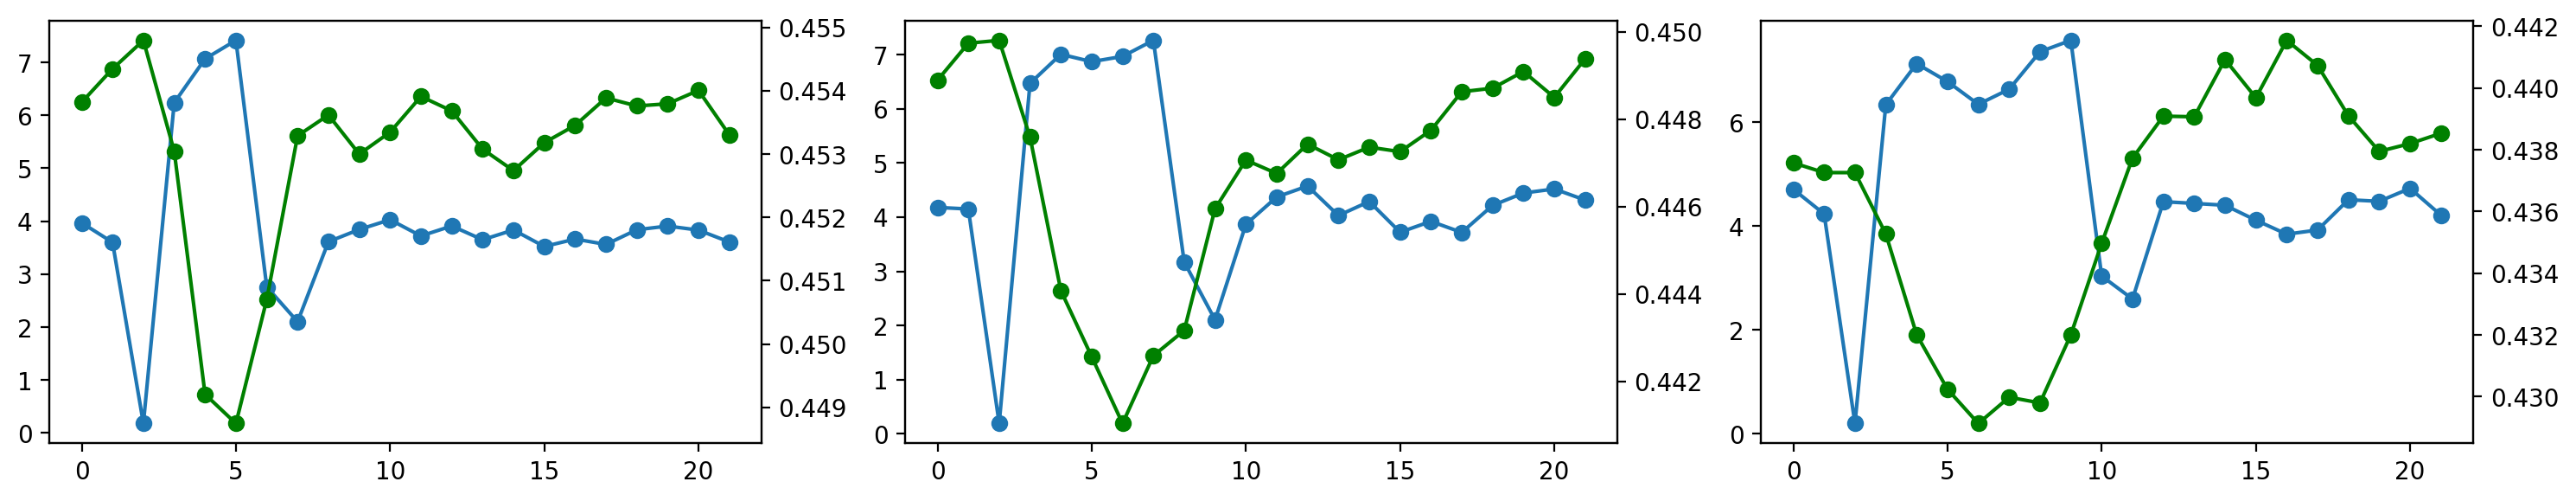

In [76]:
f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(131)
ax1 = ax.twinx()
ax.plot(ch3/chcnt3, marker='o')
ax1.plot(vod3/vodcnt3, color='green', marker='o')

ax = f.add_subplot(132)
ax1 = ax.twinx()
ax.plot(ch5/chcnt5, marker='o')
ax1.plot(vod5/vodcnt5, color='green', marker='o')

ax = f.add_subplot(133)
ax1 = ax.twinx()
ax.plot(ch7/chcnt7, marker='o')
ax1.plot(vod7/vodcnt7, color='green', marker='o')
plt.tight_layout()

In [77]:
ch3_so, chcnt3_so, vod3_so, vodcnt3_so, vodclim3_so, vodclimcnt3_so = vod_composite(dat, vod, vod_clim, chdat, 3, topo_on_g, region='southern')
ch5_so, chcnt5_so, vod5_so, vodcnt5_so, vodclim5_so, vodclimcnt5_so = vod_composite(dat, vod, vod_clim, chdat, 5, topo_on_g, region='southern')
ch7_so, chcnt7_so, vod7_so, vodcnt7_so, vodclim7_so, vodclimcnt7_so = vod_composite(dat, vod, vod_clim, chdat, 7, topo_on_g, region='southern')

Doing -81.0 -18.0
Doing -81.0 -17.75
Doing -81.0 -17.5
Doing -81.0 -17.25
Doing -81.0 -17.0
Doing -81.0 -16.75
Doing -81.0 -16.5
Doing -81.0 -16.25
Doing -81.0 -16.0
Doing -81.0 -15.75
Doing -81.0 -15.5
Doing -81.0 -15.25
Doing -81.0 -15.0
Doing -81.0 -14.75
Doing -81.0 -14.5
Doing -81.0 -14.25
Doing -81.0 -14.0
Doing -81.0 -13.75
Doing -81.0 -13.5
Doing -81.0 -13.25
Doing -81.0 -13.0
Doing -81.0 -12.75
Doing -81.0 -12.5
Doing -81.0 -12.25
Doing -81.0 -12.0
Doing -80.75 -18.0
Doing -80.75 -17.75
Doing -80.75 -17.5
Doing -80.75 -17.25
Doing -80.75 -17.0
Doing -80.75 -16.75
Doing -80.75 -16.5
Doing -80.75 -16.25
Doing -80.75 -16.0
Doing -80.75 -15.75
Doing -80.75 -15.5
Doing -80.75 -15.25
Doing -80.75 -15.0
Doing -80.75 -14.75
Doing -80.75 -14.5
Doing -80.75 -14.25
Doing -80.75 -14.0
Doing -80.75 -13.75
Doing -80.75 -13.5
Doing -80.75 -13.25
Doing -80.75 -13.0
Doing -80.75 -12.75
Doing -80.75 -12.5
Doing -80.75 -12.25
Doing -80.75 -12.0
Doing -80.5 -18.0
Doing -80.5 -17.75
Doing -80.5 -1

Doing -76.75 -13.0
Doing -76.75 -12.75
Doing -76.75 -12.5
Doing -76.75 -12.25
Doing -76.75 -12.0
Doing -76.5 -18.0
Doing -76.5 -17.75
Doing -76.5 -17.5
Doing -76.5 -17.25
Doing -76.5 -17.0
Doing -76.5 -16.75
Doing -76.5 -16.5
Doing -76.5 -16.25
Doing -76.5 -16.0
Doing -76.5 -15.75
Doing -76.5 -15.5
Doing -76.5 -15.25
Doing -76.5 -15.0
Doing -76.5 -14.75
Doing -76.5 -14.5
Doing -76.5 -14.25
Doing -76.5 -14.0
Doing -76.5 -13.75
Doing -76.5 -13.5
Doing -76.5 -13.25
Doing -76.5 -13.0
Doing -76.5 -12.75
Doing -76.5 -12.5
Doing -76.5 -12.25
something wrong
Doing 0
Doing 1
something wrong
something wrong
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
something wrong
Doing 15
Doing 16
Doing 17
Doing 18
Doing 19
Doing 20
something wrong
Doing 21
Doing 22
Doing 23
Doing 24
Doing 25
Doing 26
Doing 27
Doing 28
Doing 29
Doing 30
Doing 31
Doing 32
Doing 33
Doing 34
Doing 35
Doing 36
Doing 37
Doing 38
Doing 39
Doing 40
Doing 41
Doing 42
Do

Doing 545
Doing 546
Doing 547
something wrong
something wrong
something wrong
Doing 548
Doing 549
Doing 550
Doing 551
Doing 552
Doing -76.0 -12.75
Doing 553
Doing 554
Doing 555
Doing 556
Doing 557
Doing 558
Doing 559
Doing 560
Doing 561
Doing 562
Doing 563
Doing 564
Doing 565
Doing 566
Doing 567
Doing 568
Doing 569
Doing 570
Doing 571
Doing 572
Doing 573
something wrong
Doing 574
Doing 575
Doing 576
Doing 577
Doing 578
something wrong
something wrong
Doing 579
Doing 580
Doing 581
Doing 582
Doing 583
something wrong
Doing 584
Doing 585
Doing 586
Doing 587
Doing 588
Doing 589
Doing 590
Doing 591
Doing 592
Doing 593
Doing 594
Doing 595
Doing 596
Doing 597
Doing 598
Doing 599
Doing 600
Doing 601
Doing 602
Doing 603
something wrong
something wrong
Doing 604
Doing 605
Doing 606
Doing 607
Doing 608
Doing 609
something wrong
Doing 610
Doing 611
Doing 612
Doing 613
Doing 614
Doing 615
something wrong
something wrong
Doing 616
Doing 617
Doing 618
Doing 619
Doing 620
Doing 621
Doing 622
Doing 623

Doing 1171
Doing 1172
Doing 1173
Doing 1174
Doing 1175
Doing 1176
Doing 1177
something wrong
Doing 1178
Doing 1179
Doing 1180
Doing 1181
Doing 1182
Doing 1183
Doing 1184
Doing 1185
Doing 1186
something wrong
Doing 1187
Doing 1188
Doing 1189
Doing 1190
Doing -75.75 -13.0
something wrong
Doing 1191
Doing 1192
Doing 1193
Doing 1194
Doing 1195
Doing 1196
Doing 1197
Doing 1198
Doing 1199
Doing 1200
Doing 1201
Doing 1202
Doing 1203
Doing 1204
Doing 1205
Doing 1206
Doing 1207
Doing 1208
Doing 1209
Doing 1210
Doing 1211
Doing 1212
Doing 1213
something wrong
Doing 1214
Doing 1215
Doing 1216
Doing 1217
Doing 1218
Doing 1219
Doing 1220
Doing 1221
Doing 1222
Doing 1223
Doing 1224
Doing 1225
Doing 1226
Doing 1227
Doing 1228
Doing 1229
Doing 1230
Doing 1231
Doing 1232
Doing 1233
Doing 1234
Doing 1235
Doing 1236
Doing 1237
Doing 1238
something wrong
Doing 1239
Doing 1240
Doing 1241
Doing 1242
Doing 1243
Doing 1244
something wrong
something wrong
Doing 1245
Doing 1246
Doing 1247
Doing 1248
something w

Doing 1798
Doing 1799
Doing 1800
Doing 1801
Doing 1802
Doing 1803
Doing 1804
Doing 1805
Doing 1806
Doing 1807
Doing 1808
Doing 1809
Doing -75.5 -18.0
Doing -75.5 -17.75
Doing -75.5 -17.5
Doing -75.5 -17.25
Doing -75.5 -17.0
Doing -75.5 -16.75
Doing -75.5 -16.5
Doing -75.5 -16.25
Doing -75.5 -16.0
Doing -75.5 -15.75
Doing -75.5 -15.5
Doing -75.5 -15.25
Doing -75.5 -15.0
Doing -75.5 -14.75
Doing -75.5 -14.5
Doing -75.5 -14.25
Doing -75.5 -14.0
Doing -75.5 -13.75
Doing 1810
Doing 1811
Doing 1812
something wrong
something wrong
Doing 1813
Doing 1814
Doing 1815
Doing 1816
Doing 1817
Doing 1818
something wrong
Doing 1819
Doing 1820
Doing 1821
Doing 1822
something wrong
Doing 1823
Doing 1824
Doing 1825
Doing 1826
Doing 1827
Doing 1828
Doing 1829
Doing 1830
Doing 1831
Doing 1832
Doing 1833
Doing 1834
Doing 1835
Doing 1836
Doing 1837
something wrong
Doing 1838
Doing 1839
Doing 1840
something wrong
Doing 1841
Doing 1842
Doing 1843
Doing 1844
Doing 1845
Doing 1846
Doing 1847
something wrong
Doing

Doing 2384
Doing 2385
Doing 2386
Doing 2387
something wrong
Doing 2388
Doing 2389
Doing 2390
Doing 2391
Doing 2392
Doing 2393
Doing 2394
Doing 2395
something wrong
Doing 2396
Doing 2397
Doing 2398
Doing 2399
Doing 2400
Doing 2401
Doing -75.5 -12.25
Doing 2402
Doing 2403
Doing 2404
Doing 2405
Doing 2406
Doing 2407
Doing 2408
Doing 2409
Doing 2410
Doing 2411
something wrong
Doing 2412
Doing 2413
Doing 2414
Doing 2415
Doing 2416
Doing 2417
something wrong
something wrong
Doing 2418
Doing 2419
Doing 2420
Doing 2421
Doing 2422
Doing 2423
something wrong
something wrong
something wrong
Doing 2424
Doing 2425
Doing 2426
Doing 2427
Doing 2428
Doing 2429
Doing 2430
Doing 2431
Doing 2432
Doing 2433
Doing 2434
Doing 2435
Doing 2436
Doing 2437
Doing 2438
Doing 2439
Doing 2440
Doing 2441
Doing 2442
Doing 2443
something wrong
Doing 2444
Doing 2445
Doing 2446
Doing 2447
Doing 2448
Doing 2449
Doing 2450
Doing 2451
something wrong
Doing 2452
Doing 2453
Doing 2454
Doing 2455
Doing 2456
Doing 2457
Doing 2

Doing 2976
something wrong
Doing 2977
Doing 2978
Doing 2979
Doing 2980
Doing 2981
Doing 2982
Doing 2983
Doing 2984
Doing 2985
Doing 2986
Doing 2987
Doing 2988
Doing 2989
Doing 2990
Doing 2991
Doing 2992
Doing 2993
Doing 2994
Doing 2995
Doing 2996
Doing 2997
Doing 2998
Doing 2999
Doing 3000
something wrong
Doing 3001
Doing 3002
Doing 3003
Doing 3004
Doing 3005
Doing -75.25 -13.0
Doing 3006
Doing 3007
Doing 3008
Doing 3009
Doing 3010
Doing 3011
Doing 3012
Doing 3013
Doing 3014
Doing 3015
Doing 3016
Doing 3017
Doing 3018
Doing 3019
Doing 3020
Doing 3021
Doing 3022
Doing 3023
Doing 3024
Doing 3025
Doing 3026
Doing 3027
Doing 3028
Doing 3029
Doing 3030
Doing 3031
Doing 3032
Doing 3033
Doing 3034
Doing 3035
Doing 3036
Doing 3037
Doing 3038
Doing 3039
Doing 3040
Doing 3041
something wrong
Doing 3042
Doing 3043
Doing 3044
Doing 3045
Doing 3046
Doing 3047
Doing 3048
Doing 3049
Doing 3050
something wrong
something wrong
Doing 3051
Doing 3052
Doing 3053
Doing 3054
Doing 3055
Doing 3056
something 

Doing 3573
Doing 3574
Doing 3575
Doing 3576
Doing 3577
something wrong
Doing 3578
Doing 3579
Doing 3580
Doing 3581
Doing 3582
Doing 3583
Doing 3584
Doing 3585
Doing 3586
Doing 3587
Doing 3588
something wrong
Doing 3589
Doing 3590
Doing 3591
Doing 3592
Doing 3593
something wrong
something wrong
Doing 3594
something wrong
Doing -75.0 -14.0
Doing 3595
Doing 3596
Doing 3597
Doing 3598
Doing 3599
Doing 3600
Doing 3601
Doing 3602
Doing 3603
Doing 3604
something wrong
something wrong
something wrong
Doing 3605
Doing 3606
Doing 3607
Doing 3608
Doing 3609
Doing 3610
something wrong
something wrong
Doing 3611
Doing 3612
Doing 3613
Doing 3614
Doing 3615
Doing 3616
Doing 3617
Doing 3618
Doing 3619
something wrong
Doing 3620
Doing 3621
Doing 3622
Doing 3623
Doing 3624
Doing 3625
Doing 3626
Doing 3627
Doing 3628
Doing 3629
Doing 3630
Doing 3631
something wrong
something wrong
Doing 3632
Doing 3633
Doing 3634
Doing 3635
Doing 3636
Doing 3637
Doing 3638
Doing 3639
Doing 3640
Doing 3641
Doing 3642
Doin

Doing 4189
Doing 4190
Doing 4191
Doing 4192
Doing 4193
Doing 4194
Doing 4195
something wrong
something wrong
Doing 4196
Doing 4197
Doing 4198
Doing 4199
something wrong
something wrong
Doing 4200
Doing 4201
Doing 4202
Doing 4203
Doing 4204
Doing 4205
Doing 4206
Doing 4207
Doing 4208
something wrong
something wrong
Doing 4209
Doing 4210
Doing 4211
Doing 4212
Doing 4213
something wrong
something wrong
Doing 4214
Doing 4215
Doing 4216
something wrong
something wrong
Doing 4217
Doing 4218
Doing 4219
Doing 4220
Doing 4221
Doing 4222
Doing 4223
something wrong
something wrong
Doing 4224
Doing 4225
Doing 4226
Doing 4227
Doing 4228
Doing 4229
Doing 4230
Doing 4231
Doing 4232
Doing 4233
something wrong
Doing 4234
Doing 4235
Doing 4236
Doing 4237
Doing 4238
something wrong
something wrong
Doing 4239
Doing 4240
Doing 4241
Doing 4242
something wrong
Doing 4243
Doing 4244
Doing 4245
something wrong
something wrong
Doing 4246
Doing 4247
Doing 4248
Doing 4249
something wrong
something wrong
Doing 425

Doing 4753
Doing 4754
Doing 4755
Doing 4756
Doing 4757
Doing 4758
Doing 4759
Doing 4760
Doing 4761
something wrong
Doing 4762
Doing 4763
Doing 4764
Doing 4765
Doing 4766
something wrong
Doing 4767
Doing 4768
Doing 4769
Doing 4770
Doing 4771
Doing 4772
Doing 4773
something wrong
Doing 4774
Doing 4775
Doing 4776
Doing 4777
something wrong
something wrong
Doing 4778
Doing 4779
Doing 4780
Doing 4781
Doing 4782
Doing 4783
Doing 4784
Doing 4785
Doing 4786
Doing 4787
Doing 4788
Doing 4789
Doing 4790
Doing 4791
Doing 4792
Doing 4793
Doing 4794
Doing 4795
Doing 4796
Doing 4797
Doing 4798
Doing 4799
Doing 4800
Doing 4801
Doing 4802
Doing 4803
Doing 4804
Doing 4805
Doing 4806
something wrong
Doing 4807
Doing 4808
Doing 4809
Doing 4810
Doing 4811
Doing 4812
Doing 4813
something wrong
Doing 4814
Doing 4815
Doing 4816
Doing 4817
Doing 4818
something wrong
something wrong
Doing 4819
Doing 4820
Doing 4821
something wrong
something wrong
Doing 4822
Doing 4823
Doing 4824
Doing 4825
Doing 4826
Doing 4827

Doing 5322
Doing 5323
Doing 5324
Doing 5325
Doing 5326
Doing 5327
Doing 5328
Doing 5329
something wrong
Doing 5330
Doing 5331
something wrong
Doing 5332
Doing 5333
Doing 5334
Doing 5335
Doing 5336
something wrong
Doing 5337
Doing 5338
Doing 5339
Doing 5340
Doing 5341
Doing 5342
Doing 5343
Doing 5344
something wrong
Doing 5345
Doing 5346
Doing 5347
Doing 5348
something wrong
Doing 5349
Doing 5350
Doing 5351
Doing 5352
something wrong
Doing 5353
Doing 5354
Doing 5355
Doing 5356
Doing 5357
Doing 5358
Doing 5359
Doing 5360
Doing 5361
something wrong
Doing 5362
Doing 5363
Doing 5364
Doing 5365
something wrong
Doing 5366
Doing 5367
Doing 5368
Doing 5369
Doing 5370
Doing 5371
something wrong
Doing 5372
Doing 5373
Doing 5374
Doing 5375
Doing 5376
Doing 5377
something wrong
Doing 5378
Doing 5379
Doing 5380
Doing 5381
Doing 5382
Doing 5383
Doing 5384
Doing 5385
Doing 5386
Doing 5387
Doing 5388
Doing 5389
Doing 5390
Doing 5391
Doing 5392
Doing 5393
Doing 5394
something wrong
something wrong
Doing

Doing 5918
Doing 5919
Doing 5920
Doing 5921
Doing 5922
Doing 5923
Doing 5924
Doing 5925
Doing 5926
Doing 5927
Doing 5928
something wrong
something wrong
something wrong
Doing 5929
Doing 5930
Doing 5931
Doing 5932
Doing 5933
something wrong
Doing 5934
Doing 5935
something wrong
Doing 5936
Doing 5937
Doing 5938
Doing 5939
Doing 5940
Doing 5941
something wrong
Doing 5942
Doing 5943
Doing 5944
Doing 5945
Doing 5946
Doing 5947
Doing 5948
Doing 5949
Doing 5950
Doing 5951
Doing 5952
Doing 5953
Doing 5954
Doing 5955
Doing 5956
something wrong
something wrong
Doing 5957
Doing 5958
Doing 5959
Doing 5960
Doing 5961
Doing 5962
Doing 5963
Doing 5964
something wrong
something wrong
Doing 5965
Doing 5966
Doing 5967
Doing 5968
Doing 5969
something wrong
Doing 5970
Doing 5971
Doing 5972
Doing 5973
Doing 5974
Doing 5975
Doing 5976
Doing 5977
Doing 5978
Doing 5979
Doing 5980
Doing 5981
something wrong
Doing 5982
Doing 5983
Doing 5984
Doing 5985
Doing -74.5 -12.25
something wrong
Doing 5986
Doing 5987
Doi

Doing 6489
Doing 6490
something wrong
Doing 6491
Doing 6492
Doing 6493
Doing 6494
something wrong
something wrong
Doing 6495
Doing 6496
Doing 6497
Doing 6498
Doing 6499
Doing 6500
Doing 6501
Doing 6502
something wrong
Doing 6503
Doing 6504
Doing 6505
Doing 6506
Doing 6507
Doing 6508
Doing 6509
Doing 6510
Doing 6511
Doing 6512
Doing 6513
something wrong
something wrong
Doing 6514
Doing 6515
Doing 6516
Doing 6517
something wrong
Doing 6518
Doing 6519
Doing 6520
Doing 6521
Doing 6522
Doing -74.25 -14.5
Doing 6523
Doing 6524
Doing 6525
Doing 6526
Doing 6527
Doing 6528
Doing 6529
Doing 6530
Doing 6531
Doing 6532
Doing 6533
Doing 6534
Doing 6535
Doing 6536
something wrong
Doing 6537
Doing 6538
Doing 6539
Doing 6540
Doing 6541
something wrong
Doing 6542
Doing 6543
Doing 6544
Doing 6545
Doing 6546
Doing 6547
Doing 6548
Doing 6549
Doing 6550
Doing 6551
Doing 6552
Doing 6553
Doing 6554
Doing 6555
Doing 6556
Doing 6557
something wrong
Doing 6558
Doing 6559
Doing 6560
Doing 6561
Doing 6562
Doing 6

Doing 7109
Doing 7110
Doing 7111
Doing 7112
something wrong
Doing 7113
Doing 7114
Doing 7115
Doing 7116
Doing 7117
something wrong
something wrong
something wrong
Doing 7118
Doing 7119
Doing 7120
Doing 7121
Doing 7122
Doing 7123
Doing 7124
Doing 7125
Doing 7126
Doing -74.25 -12.5
something wrong
Doing 7127
Doing 7128
Doing 7129
Doing 7130
Doing 7131
Doing 7132
Doing 7133
Doing 7134
something wrong
something wrong
Doing 7135
Doing 7136
Doing 7137
Doing 7138
Doing 7139
Doing 7140
Doing 7141
Doing 7142
Doing 7143
Doing 7144
something wrong
something wrong
Doing 7145
Doing 7146
Doing 7147
Doing 7148
Doing 7149
Doing 7150
Doing 7151
Doing 7152
Doing 7153
Doing 7154
Doing 7155
Doing 7156
something wrong
something wrong
something wrong
something wrong
Doing 7157
Doing 7158
Doing 7159
Doing 7160
Doing 7161
Doing 7162
Doing 7163
Doing 7164
Doing 7165
something wrong
Doing 7166
Doing 7167
Doing 7168
Doing 7169
Doing 7170
Doing 7171
Doing 7172
Doing 7173
Doing 7174
Doing 7175
Doing 7176
something

Doing 7710
Doing 7711
Doing 7712
something wrong
something wrong
Doing 7713
Doing 7714
Doing 7715
Doing 7716
Doing 7717
Doing 7718
Doing 7719
Doing 7720
Doing 7721
Doing 7722
Doing 7723
Doing 7724
something wrong
something wrong
Doing 7725
Doing 7726
Doing 7727
Doing 7728
Doing 7729
Doing 7730
Doing 7731
Doing 7732
Doing 7733
Doing 7734
Doing 7735
Doing 7736
Doing 7737
Doing 7738
Doing 7739
Doing 7740
Doing 7741
Doing 7742
something wrong
Doing 7743
Doing 7744
Doing 7745
Doing 7746
something wrong
Doing 7747
Doing 7748
Doing 7749
something wrong
Doing -74.0 -14.5
Doing 7750
Doing 7751
Doing 7752
Doing 7753
Doing 7754
Doing 7755
Doing 7756
Doing 7757
Doing 7758
something wrong
Doing 7759
Doing 7760
Doing 7761
Doing 7762
Doing 7763
something wrong
Doing 7764
Doing 7765
Doing 7766
Doing 7767
Doing 7768
Doing 7769
Doing 7770
Doing 7771
Doing 7772
Doing 7773
Doing 7774
Doing 7775
Doing 7776
Doing 7777
Doing 7778
Doing 7779
something wrong
Doing 7780
Doing 7781
Doing 7782
something wrong
Doi

Doing 8265
Doing 8266
Doing 8267
Doing 8268
Doing -74.0 -12.75
Doing 8269
Doing 8270
Doing 8271
Doing 8272
Doing 8273
Doing 8274
Doing 8275
Doing 8276
something wrong
something wrong
Doing 8277
Doing 8278
Doing 8279
Doing 8280
Doing 8281
Doing 8282
Doing 8283
Doing 8284
Doing 8285
something wrong
something wrong
Doing 8286
Doing 8287
Doing 8288
Doing 8289
Doing 8290
Doing 8291
Doing 8292
Doing 8293
something wrong
something wrong
Doing 8294
Doing 8295
Doing 8296
Doing 8297
Doing 8298
Doing 8299
Doing 8300
Doing 8301
something wrong
something wrong
something wrong
Doing 8302
Doing 8303
Doing 8304
Doing 8305
Doing 8306
Doing 8307
Doing 8308
something wrong
something wrong
Doing 8309
Doing 8310
Doing 8311
Doing 8312
Doing 8313
Doing 8314
Doing 8315
Doing 8316
Doing 8317
Doing 8318
Doing 8319
Doing 8320
Doing 8321
Doing 8322
Doing 8323
Doing 8324
something wrong
Doing 8325
Doing 8326
Doing 8327
Doing 8328
Doing 8329
Doing 8330
Doing 8331
something wrong
something wrong
Doing 8332
Doing 833

Doing 8868
something wrong
something wrong
Doing 8869
Doing 8870
Doing 8871
Doing 8872
Doing 8873
Doing 8874
Doing 8875
Doing 8876
Doing 8877
Doing 8878
Doing 8879
Doing 8880
Doing 8881
Doing 8882
Doing 8883
Doing 8884
Doing 8885
Doing 8886
Doing 8887
Doing 8888
Doing 8889
Doing 8890
something wrong
something wrong
Doing 8891
Doing 8892
Doing 8893
Doing 8894
Doing 8895
Doing 8896
Doing 8897
Doing 8898
Doing 8899
Doing 8900
Doing 8901
Doing 8902
Doing 8903
Doing 8904
Doing 8905
Doing 8906
Doing 8907
Doing 8908
Doing 8909
Doing 8910
Doing 8911
Doing 8912
Doing 8913
Doing 8914
Doing 8915
Doing 8916
Doing 8917
Doing 8918
Doing 8919
Doing 8920
Doing 8921
Doing 8922
Doing 8923
Doing 8924
something wrong
Doing 8925
Doing 8926
Doing 8927
something wrong
something wrong
Doing 8928
Doing 8929
Doing 8930
Doing 8931
Doing 8932
Doing 8933
Doing -73.75 -14.0
Doing 8934
Doing 8935
Doing 8936
something wrong
something wrong
Doing 8937
Doing 8938
Doing 8939
something wrong
something wrong
Doing 8940
Do

Doing 9448
Doing 9449
Doing 9450
something wrong
Doing 9451
Doing 9452
something wrong
something wrong
Doing 9453
Doing 9454
Doing 9455
Doing 9456
Doing 9457
Doing 9458
something wrong
Doing 9459
Doing 9460
Doing 9461
Doing 9462
Doing 9463
Doing 9464
Doing 9465
Doing 9466
Doing 9467
something wrong
something wrong
Doing 9468
Doing 9469
Doing 9470
Doing 9471
Doing 9472
Doing 9473
Doing 9474
something wrong
Doing 9475
Doing 9476
Doing 9477
Doing 9478
Doing 9479
Doing 9480
Doing 9481
Doing 9482
Doing 9483
something wrong
Doing 9484
Doing 9485
Doing 9486
Doing 9487
Doing 9488
Doing 9489
Doing 9490
Doing 9491
Doing 9492
something wrong
Doing -73.5 -15.0
Doing 9493
Doing 9494
Doing 9495
Doing 9496
Doing 9497
Doing 9498
Doing 9499
Doing 9500
Doing 9501
Doing 9502
Doing 9503
something wrong
Doing 9504
Doing 9505
Doing 9506
something wrong
Doing 9507
something wrong
Doing 9508
Doing 9509
Doing 9510
Doing 9511
Doing 9512
Doing 9513
Doing 9514
something wrong
Doing 9515
Doing 9516
Doing 9517
Doin

Doing 10053
something wrong
something wrong
Doing 10054
Doing 10055
Doing 10056
Doing 10057
Doing 10058
Doing 10059
something wrong
something wrong
Doing 10060
Doing 10061
Doing 10062
Doing 10063
Doing 10064
Doing 10065
Doing 10066
Doing 10067
Doing 10068
Doing 10069
Doing 10070
Doing 10071
Doing 10072
Doing 10073
something wrong
Doing 10074
Doing 10075
Doing 10076
Doing 10077
Doing 10078
Doing 10079
Doing 10080
Doing 10081
Doing 10082
something wrong
something wrong
something wrong
Doing 10083
Doing 10084
Doing 10085
Doing 10086
Doing 10087
Doing 10088
Doing 10089
Doing 10090
Doing 10091
Doing 10092
Doing 10093
something wrong
something wrong
Doing 10094
Doing 10095
Doing 10096
Doing 10097
Doing 10098
Doing 10099
something wrong
Doing 10100
Doing 10101
Doing 10102
Doing 10103
Doing 10104
Doing 10105
something wrong
Doing 10106
Doing 10107
Doing 10108
Doing 10109
Doing 10110
Doing 10111
something wrong
Doing 10112
Doing 10113
Doing 10114
Doing 10115
Doing 10116
Doing 10117
something wr

Doing 10598
Doing 10599
Doing 10600
something wrong
Doing 10601
Doing 10602
something wrong
Doing 10603
Doing 10604
Doing 10605
something wrong
Doing 10606
Doing 10607
something wrong
Doing 10608
Doing 10609
something wrong
Doing 10610
Doing 10611
Doing 10612
something wrong
something wrong
Doing 10613
Doing 10614
Doing 10615
Doing 10616
Doing 10617
Doing 10618
Doing 10619
Doing 10620
something wrong
something wrong
Doing 10621
Doing 10622
Doing 10623
Doing 10624
Doing 10625
Doing 10626
Doing 10627
Doing 10628
something wrong
something wrong
Doing 10629
Doing 10630
Doing 10631
Doing 10632
Doing 10633
Doing 10634
Doing 10635
Doing 10636
Doing 10637
Doing 10638
Doing 10639
Doing 10640
Doing 10641
Doing 10642
Doing 10643
something wrong
Doing -73.25 -15.25
Doing 10644
Doing 10645
Doing 10646
Doing 10647
Doing 10648
Doing 10649
Doing 10650
Doing 10651
Doing 10652
Doing 10653
Doing 10654
Doing 10655
something wrong
something wrong
Doing 10656
Doing 10657
Doing 10658
Doing 10659
Doing 10660


Doing 11158
Doing 11159
Doing 11160
Doing 11161
something wrong
something wrong
Doing 11162
Doing 11163
Doing 11164
Doing 11165
Doing 11166
Doing 11167
Doing 11168
Doing 11169
Doing 11170
Doing 11171
Doing 11172
Doing 11173
something wrong
Doing 11174
Doing 11175
Doing 11176
Doing 11177
Doing 11178
something wrong
Doing 11179
Doing 11180
Doing 11181
Doing 11182
Doing 11183
Doing 11184
Doing 11185
Doing 11186
Doing 11187
Doing 11188
Doing 11189
Doing 11190
Doing 11191
Doing 11192
Doing 11193
Doing 11194
Doing 11195
Doing 11196
Doing 11197
Doing 11198
Doing 11199
Doing 11200
Doing 11201
Doing 11202
Doing 11203
Doing 11204
Doing 11205
Doing 11206
Doing 11207
Doing 11208
Doing 11209
Doing 11210
Doing 11211
Doing 11212
Doing 11213
Doing 11214
something wrong
Doing 11215
Doing 11216
Doing 11217
Doing 11218
Doing 11219
something wrong
something wrong
Doing 11220
Doing 11221
Doing 11222
Doing 11223
Doing 11224
Doing 11225
Doing 11226
Doing 11227
Doing 11228
Doing 11229
Doing 11230
something wr

Doing 11719
Doing 11720
Doing 11721
Doing 11722
Doing 11723
Doing 11724
something wrong
Doing 11725
Doing 11726
Doing 11727
Doing 11728
something wrong
something wrong
Doing 11729
Doing 11730
Doing 11731
Doing 11732
Doing 11733
Doing 11734
Doing 11735
Doing 11736
Doing 11737
something wrong
Doing 11738
Doing 11739
Doing 11740
Doing 11741
Doing 11742
something wrong
Doing 11743
Doing 11744
Doing 11745
Doing 11746
Doing 11747
something wrong
something wrong
something wrong
Doing 11748
Doing 11749
Doing 11750
Doing 11751
Doing 11752
Doing 11753
Doing 11754
something wrong
Doing 11755
Doing 11756
Doing 11757
Doing 11758
Doing 11759
Doing 11760
Doing 11761
Doing 11762
Doing 11763
Doing 11764
Doing 11765
something wrong
Doing 11766
Doing 11767
Doing 11768
something wrong
Doing -73.0 -15.5
Doing 11769
Doing 11770
Doing 11771
Doing 11772
something wrong
Doing 11773
Doing 11774
Doing 11775
Doing 11776
Doing 11777
Doing 11778
Doing 11779
Doing 11780
Doing 11781
Doing 11782
Doing 11783
Doing 1178

Doing 12316
Doing 12317
something wrong
Doing 12318
Doing 12319
Doing 12320
Doing 12321
Doing 12322
Doing 12323
Doing 12324
Doing 12325
something wrong
Doing 12326
Doing 12327
Doing 12328
Doing 12329
Doing 12330
something wrong
something wrong
Doing 12331
Doing 12332
Doing 12333
Doing 12334
Doing 12335
Doing 12336
Doing 12337
Doing 12338
Doing 12339
Doing 12340
Doing 12341
Doing 12342
Doing 12343
something wrong
Doing 12344
Doing 12345
Doing 12346
something wrong
Doing 12347
Doing 12348
Doing 12349
Doing 12350
Doing -73.0 -13.75
Doing 12351
Doing 12352
Doing 12353
Doing 12354
something wrong
Doing 12355
Doing 12356
Doing 12357
Doing 12358
Doing 12359
something wrong
Doing 12360
Doing 12361
something wrong
Doing 12362
Doing 12363
Doing 12364
Doing 12365
Doing 12366
Doing 12367
Doing 12368
Doing 12369
something wrong
Doing 12370
Doing 12371
Doing 12372
Doing 12373
something wrong
Doing 12374
Doing 12375
Doing 12376
Doing 12377
Doing 12378
Doing 12379
Doing 12380
Doing 12381
Doing 12382
s

something wrong
something wrong
Doing -72.75 -15.75
Doing 12864
Doing 12865
Doing 12866
Doing 12867
Doing 12868
Doing 12869
something wrong
something wrong
Doing 12870
Doing 12871
Doing 12872
Doing 12873
Doing 12874
Doing 12875
Doing 12876
Doing 12877
Doing 12878
Doing 12879
Doing 12880
Doing 12881
something wrong
Doing 12882
Doing 12883
Doing 12884
Doing 12885
Doing 12886
something wrong
Doing 12887
Doing 12888
Doing 12889
Doing 12890
Doing 12891
something wrong
Doing 12892
Doing 12893
something wrong
Doing 12894
Doing 12895
Doing 12896
something wrong
something wrong
Doing 12897
Doing 12898
something wrong
Doing 12899
Doing 12900
Doing 12901
Doing 12902
Doing 12903
something wrong
something wrong
something wrong
Doing 12904
Doing 12905
Doing 12906
Doing 12907
something wrong
Doing 12908
Doing 12909
Doing 12910
Doing 12911
Doing 12912
Doing 12913
Doing 12914
something wrong
Doing 12915
Doing 12916
Doing 12917
Doing 12918
Doing 12919
something wrong
something wrong
Doing 12920
Doing 12

Doing 13435
Doing 13436
Doing 13437
Doing 13438
Doing 13439
Doing 13440
Doing 13441
Doing 13442
Doing 13443
Doing 13444
Doing 13445
Doing 13446
Doing 13447
Doing 13448
Doing 13449
Doing 13450
Doing 13451
Doing 13452
Doing 13453
Doing 13454
Doing 13455
Doing 13456
Doing 13457
Doing 13458
Doing 13459
Doing 13460
Doing 13461
Doing 13462
Doing 13463
something wrong
Doing 13464
Doing 13465
Doing 13466
Doing 13467
Doing 13468
Doing 13469
Doing 13470
Doing 13471
Doing 13472
Doing 13473
Doing 13474
Doing 13475
something wrong
Doing 13476
Doing 13477
Doing 13478
Doing 13479
Doing 13480
Doing 13481
Doing 13482
Doing 13483
Doing 13484
Doing 13485
Doing 13486
Doing 13487
Doing 13488
Doing 13489
Doing 13490
something wrong
Doing 13491
Doing 13492
Doing 13493
Doing 13494
Doing 13495
Doing -72.75 -13.75
Doing 13496
Doing 13497
Doing 13498
Doing 13499
Doing 13500
something wrong
Doing 13501
Doing 13502
Doing 13503
something wrong
Doing 13504
Doing 13505
Doing 13506
Doing 13507
Doing 13508
Doing 13509


Doing 14005
Doing 14006
Doing 14007
Doing 14008
Doing 14009
Doing 14010
Doing 14011
Doing 14012
something wrong
Doing 14013
Doing 14014
Doing 14015
something wrong
Doing 14016
Doing 14017
Doing 14018
Doing 14019
something wrong
Doing 14020
Doing 14021
Doing 14022
Doing 14023
Doing 14024
Doing 14025
something wrong
something wrong
Doing 14026
Doing 14027
Doing 14028
Doing 14029
Doing 14030
Doing 14031
Doing 14032
Doing 14033
Doing 14034
Doing 14035
Doing 14036
Doing 14037
Doing 14038
Doing 14039
Doing 14040
Doing 14041
Doing 14042
Doing 14043
Doing 14044
Doing 14045
Doing 14046
Doing 14047
Doing 14048
something wrong
something wrong
Doing 14049
Doing 14050
Doing 14051
Doing 14052
Doing 14053
Doing 14054
Doing 14055
Doing 14056
Doing 14057
Doing 14058
Doing 14059
something wrong
Doing -72.5 -15.25
Doing 14060
Doing 14061
Doing 14062
Doing 14063
Doing 14064
something wrong
something wrong
Doing 14065
Doing 14066
Doing 14067
Doing 14068
Doing 14069
Doing 14070
Doing 14071
Doing 14072
Doing

Doing 14611
Doing 14612
Doing 14613
Doing 14614
Doing 14615
Doing 14616
Doing 14617
Doing 14618
Doing 14619
something wrong
Doing 14620
Doing 14621
Doing 14622
Doing 14623
Doing 14624
Doing 14625
something wrong
Doing 14626
Doing 14627
Doing 14628
Doing 14629
Doing 14630
Doing 14631
something wrong
Doing 14632
Doing 14633
Doing 14634
something wrong
something wrong
Doing 14635
Doing 14636
Doing 14637
Doing 14638
Doing 14639
Doing 14640
Doing 14641
Doing 14642
Doing 14643
Doing 14644
Doing 14645
Doing 14646
something wrong
Doing 14647
Doing 14648
Doing 14649
Doing 14650
Doing 14651
Doing 14652
Doing 14653
something wrong
something wrong
something wrong
Doing 14654
Doing 14655
Doing 14656
Doing 14657
Doing 14658
Doing 14659
Doing 14660
Doing 14661
Doing 14662
Doing 14663
Doing 14664
something wrong
something wrong
Doing 14665
Doing 14666
Doing 14667
Doing 14668
Doing 14669
Doing 14670
Doing 14671
Doing 14672
Doing 14673
Doing 14674
something wrong
Doing 14675
Doing 14676
Doing 14677
Doin

Doing 15145
Doing 15146
Doing 15147
Doing 15148
Doing 15149
Doing 15150
Doing 15151
something wrong
something wrong
Doing 15152
Doing 15153
Doing 15154
Doing 15155
Doing 15156
something wrong
Doing 15157
Doing 15158
Doing 15159
Doing 15160
Doing 15161
Doing 15162
Doing 15163
Doing 15164
Doing 15165
something wrong
Doing 15166
Doing 15167
Doing 15168
Doing 15169
Doing 15170
Doing 15171
Doing 15172
something wrong
Doing 15173
Doing 15174
Doing 15175
Doing 15176
Doing 15177
Doing 15178
Doing 15179
Doing 15180
something wrong
something wrong
Doing -72.25 -15.25
Doing 15181
Doing 15182
Doing 15183
Doing 15184
Doing 15185
Doing 15186
Doing 15187
Doing 15188
Doing 15189
Doing 15190
Doing 15191
Doing 15192
Doing 15193
Doing 15194
Doing 15195
Doing 15196
Doing 15197
Doing 15198
Doing 15199
Doing 15200
Doing 15201
Doing 15202
something wrong
Doing 15203
Doing 15204
Doing 15205
Doing 15206
Doing 15207
Doing 15208
Doing 15209
Doing 15210
Doing 15211
Doing 15212
Doing 15213
Doing 15214
something wr

Doing 15765
Doing 15766
Doing 15767
Doing 15768
Doing 15769
something wrong
Doing 15770
Doing 15771
Doing 15772
Doing 15773
Doing 15774
Doing -72.25 -13.5
Doing 15775
Doing 15776
Doing 15777
Doing 15778
Doing 15779
Doing 15780
Doing 15781
Doing 15782
Doing 15783
Doing 15784
Doing 15785
Doing 15786
something wrong
something wrong
Doing 15787
Doing 15788
Doing 15789
Doing 15790
Doing 15791
Doing 15792
Doing 15793
Doing 15794
Doing 15795
something wrong
something wrong
Doing 15796
Doing 15797
Doing 15798
Doing 15799
Doing 15800
something wrong
something wrong
something wrong
Doing 15801
Doing 15802
Doing 15803
Doing 15804
Doing 15805
Doing 15806
Doing 15807
Doing 15808
Doing 15809
Doing 15810
Doing 15811
Doing 15812
Doing 15813
Doing 15814
Doing 15815
Doing 15816
Doing 15817
Doing 15818
something wrong
Doing 15819
Doing 15820
Doing 15821
Doing 15822
Doing 15823
Doing 15824
Doing 15825
Doing 15826
Doing 15827
Doing 15828
Doing 15829
Doing 15830
something wrong
something wrong
something wro

something wrong
Doing 16374
Doing 16375
Doing 16376
Doing 16377
Doing 16378
Doing 16379
Doing 16380
Doing 16381
Doing 16382
Doing 16383
Doing 16384
something wrong
Doing 16385
Doing 16386
Doing 16387
Doing 16388
Doing 16389
Doing 16390
Doing 16391
Doing 16392
Doing 16393
something wrong
something wrong
Doing 16394
Doing 16395
Doing 16396
Doing 16397
Doing 16398
something wrong
something wrong
something wrong
Doing 16399
Doing 16400
Doing 16401
Doing 16402
Doing 16403
Doing 16404
Doing 16405
Doing 16406
Doing 16407
something wrong
something wrong
Doing 16408
Doing 16409
Doing 16410
Doing 16411
Doing 16412
Doing 16413
Doing 16414
Doing 16415
Doing 16416
Doing 16417
Doing 16418
something wrong
Doing 16419
Doing 16420
Doing 16421
Doing 16422
Doing 16423
Doing 16424
something wrong
something wrong
Doing 16425
Doing 16426
Doing 16427
Doing 16428
Doing 16429
Doing 16430
Doing 16431
Doing 16432
Doing 16433
Doing 16434
Doing -72.25 -12.5
Doing -72.25 -12.25
Doing -72.25 -12.0
Doing -72.0 -18.0


Doing 16927
Doing 16928
Doing 16929
Doing 16930
Doing 16931
Doing 16932
Doing 16933
Doing 16934
Doing 16935
Doing 16936
Doing 16937
Doing 16938
Doing -72.0 -14.25
Doing 16939
Doing 16940
Doing 16941
Doing 16942
Doing 16943
Doing 16944
Doing 16945
Doing 16946
Doing 16947
Doing 16948
something wrong
Doing 16949
Doing 16950
Doing 16951
Doing 16952
Doing 16953
Doing 16954
Doing 16955
Doing 16956
Doing 16957
Doing 16958
Doing 16959
something wrong
Doing 16960
Doing 16961
Doing 16962
Doing 16963
Doing 16964
Doing 16965
Doing 16966
Doing 16967
Doing 16968
Doing 16969
Doing 16970
Doing 16971
Doing 16972
Doing 16973
Doing 16974
Doing 16975
Doing 16976
Doing 16977
Doing 16978
Doing 16979
Doing 16980
Doing 16981
Doing 16982
Doing 16983
Doing 16984
Doing 16985
Doing 16986
Doing 16987
something wrong
Doing 16988
Doing 16989
Doing 16990
Doing 16991
Doing 16992
Doing 16993
Doing 16994
Doing 16995
something wrong
Doing 16996
something wrong
Doing 16997
Doing 16998
Doing 16999
Doing 17000
Doing 17001
s

Doing 17526
Doing 17527
Doing 17528
Doing 17529
Doing 17530
Doing 17531
Doing 17532
Doing 17533
Doing 17534
Doing 17535
Doing 17536
Doing 17537
Doing 17538
Doing 17539
Doing 17540
Doing 17541
Doing 17542
something wrong
something wrong
Doing 17543
Doing 17544
Doing 17545
Doing 17546
Doing 17547
Doing 17548
Doing 17549
Doing -72.0 -13.0
Doing 17550
Doing 17551
Doing 17552
Doing 17553
Doing 17554
Doing 17555
Doing 17556
Doing 17557
Doing 17558
Doing 17559
Doing 17560
Doing 17561
Doing 17562
Doing 17563
Doing 17564
Doing 17565
Doing 17566
Doing 17567
Doing 17568
Doing 17569
Doing 17570
Doing 17571
Doing 17572
Doing 17573
Doing 17574
Doing 17575
Doing 17576
Doing 17577
something wrong
Doing 17578
Doing 17579
Doing 17580
Doing 17581
Doing 17582
Doing 17583
Doing 17584
Doing 17585
Doing 17586
Doing 17587
Doing 17588
Doing 17589
Doing 17590
Doing 17591
Doing 17592
Doing 17593
Doing 17594
Doing 17595
something wrong
something wrong
Doing 17596
Doing 17597
Doing 17598
Doing 17599
something wron

Doing 18074
Doing 18075
Doing 18076
Doing 18077
Doing 18078
Doing 18079
something wrong
Doing 18080
something wrong
Doing 18081
Doing 18082
Doing 18083
Doing 18084
Doing 18085
Doing 18086
Doing 18087
Doing 18088
Doing 18089
Doing 18090
Doing 18091
something wrong
something wrong
Doing 18092
Doing 18093
Doing 18094
Doing 18095
Doing 18096
Doing 18097
Doing 18098
Doing 18099
Doing 18100
Doing 18101
something wrong
Doing -71.75 -15.25
Doing 18102
Doing 18103
Doing 18104
Doing 18105
Doing 18106
Doing 18107
something wrong
Doing 18108
Doing 18109
Doing 18110
Doing 18111
Doing 18112
Doing 18113
Doing 18114
Doing 18115
Doing 18116
Doing 18117
Doing 18118
Doing 18119
Doing 18120
Doing 18121
Doing 18122
something wrong
Doing 18123
Doing 18124
Doing 18125
Doing 18126
Doing 18127
Doing 18128
something wrong
Doing 18129
Doing 18130
Doing 18131
Doing 18132
Doing 18133
Doing 18134
Doing 18135
something wrong
Doing 18136
Doing 18137
Doing 18138
Doing 18139
Doing 18140
Doing 18141
Doing 18142
Doing 18

Doing 18700
Doing 18701
Doing 18702
Doing 18703
Doing 18704
something wrong
something wrong
Doing 18705
Doing 18706
Doing 18707
Doing 18708
Doing 18709
Doing 18710
Doing 18711
Doing 18712
Doing 18713
Doing 18714
Doing 18715
something wrong
Doing 18716
Doing 18717
Doing 18718
Doing 18719
Doing 18720
Doing 18721
Doing 18722
Doing 18723
something wrong
Doing 18724
Doing 18725
something wrong
Doing 18726
Doing 18727
Doing 18728
Doing 18729
Doing 18730
Doing 18731
Doing 18732
Doing 18733
something wrong
Doing 18734
Doing 18735
Doing 18736
Doing 18737
Doing 18738
Doing 18739
something wrong
Doing 18740
Doing 18741
Doing 18742
Doing 18743
Doing 18744
Doing 18745
something wrong
Doing 18746
Doing 18747
Doing 18748
Doing 18749
Doing 18750
something wrong
Doing 18751
Doing 18752
Doing 18753
Doing 18754
Doing 18755
Doing 18756
Doing 18757
Doing 18758
Doing 18759
Doing -71.75 -13.5
Doing 18760
Doing 18761
Doing 18762
Doing 18763
Doing 18764
something wrong
Doing 18765
Doing 18766
Doing 18767
Doing

Doing 19288
Doing 19289
Doing 19290
Doing 19291
Doing 19292
Doing 19293
Doing 19294
Doing 19295
Doing 19296
Doing 19297
Doing 19298
Doing 19299
Doing 19300
Doing 19301
Doing 19302
Doing 19303
Doing 19304
Doing 19305
Doing 19306
Doing 19307
Doing 19308
Doing 19309
Doing 19310
Doing 19311
Doing 19312
Doing 19313
Doing 19314
Doing 19315
Doing 19316
Doing 19317
Doing 19318
Doing 19319
Doing 19320
Doing 19321
Doing 19322
Doing 19323
Doing 19324
Doing 19325
Doing 19326
Doing 19327
Doing 19328
Doing 19329
Doing 19330
Doing 19331
something wrong
Doing 19332
Doing 19333
Doing 19334
Doing 19335
Doing 19336
Doing 19337
Doing 19338
something wrong
something wrong
Doing 19339
Doing 19340
Doing 19341
Doing 19342
something wrong
something wrong
Doing 19343
Doing 19344
Doing 19345
Doing 19346
Doing 19347
Doing 19348
Doing 19349
Doing 19350
Doing 19351
Doing 19352
Doing 19353
Doing 19354
something wrong
Doing 19355
Doing 19356
Doing 19357
Doing 19358
Doing 19359
Doing 19360
something wrong
something wr

Doing 19824
Doing 19825
Doing 19826
Doing 19827
Doing -71.5 -14.75
Doing 19828
Doing 19829
Doing 19830
Doing 19831
Doing 19832
Doing 19833
Doing 19834
Doing 19835
Doing 19836
Doing 19837
Doing 19838
something wrong
something wrong
Doing 19839
Doing 19840
Doing 19841
Doing 19842
Doing 19843
Doing 19844
Doing 19845
Doing 19846
Doing 19847
Doing 19848
Doing 19849
Doing 19850
Doing 19851
Doing 19852
Doing 19853
Doing 19854
Doing 19855
Doing 19856
Doing 19857
Doing 19858
Doing 19859
Doing 19860
something wrong
Doing 19861
Doing 19862
Doing 19863
Doing 19864
Doing 19865
Doing 19866
Doing 19867
something wrong
Doing 19868
Doing 19869
Doing 19870
Doing 19871
Doing 19872
something wrong
Doing 19873
Doing 19874
Doing 19875
Doing 19876
something wrong
Doing 19877
Doing 19878
Doing 19879
Doing 19880
Doing 19881
Doing 19882
Doing 19883
Doing 19884
Doing 19885
something wrong
Doing 19886
Doing 19887
Doing 19888
Doing 19889
Doing 19890
Doing 19891
Doing 19892
Doing 19893
Doing 19894
Doing 19895
Doing

Doing 20447
Doing 20448
Doing 20449
Doing 20450
Doing 20451
Doing 20452
something wrong
something wrong
Doing 20453
Doing 20454
Doing 20455
Doing 20456
Doing 20457
Doing 20458
Doing 20459
Doing 20460
Doing 20461
Doing 20462
something wrong
Doing 20463
Doing 20464
Doing 20465
Doing 20466
something wrong
something wrong
something wrong
Doing 20467
Doing 20468
Doing 20469
Doing 20470
Doing 20471
Doing 20472
Doing 20473
Doing 20474
something wrong
Doing 20475
Doing 20476
Doing 20477
Doing 20478
Doing 20479
Doing 20480
Doing 20481
something wrong
Doing 20482
Doing 20483
Doing 20484
Doing 20485
Doing 20486
Doing 20487
Doing 20488
Doing -71.5 -13.25
Doing 20489
Doing 20490
Doing 20491
Doing 20492
Doing 20493
Doing 20494
Doing 20495
Doing 20496
Doing 20497
Doing 20498
Doing 20499
Doing 20500
Doing 20501
Doing 20502
Doing 20503
Doing 20504
Doing 20505
Doing 20506
Doing 20507
Doing 20508
Doing 20509
Doing 20510
Doing 20511
Doing 20512
Doing 20513
Doing 20514
Doing 20515
Doing 20516
Doing 20517
D

Doing 20990
Doing 20991
Doing 20992
Doing 20993
Doing 20994
Doing 20995
Doing 20996
something wrong
something wrong
Doing 20997
Doing 20998
Doing 20999
Doing 21000
Doing 21001
something wrong
Doing 21002
Doing 21003
Doing 21004
Doing 21005
Doing 21006
Doing 21007
Doing 21008
Doing 21009
Doing 21010
Doing 21011
Doing 21012
Doing 21013
something wrong
Doing 21014
Doing 21015
Doing 21016
Doing 21017
Doing 21018
Doing 21019
Doing 21020
Doing 21021
Doing 21022
Doing 21023
Doing 21024
Doing 21025
Doing 21026
Doing 21027
Doing 21028
Doing 21029
Doing 21030
Doing 21031
Doing 21032
Doing 21033
Doing 21034
Doing 21035
Doing 21036
Doing 21037
Doing 21038
Doing 21039
something wrong
Doing 21040
Doing 21041
Doing 21042
Doing 21043
Doing 21044
Doing 21045
Doing 21046
Doing -71.25 -15.0
Doing 21047
Doing 21048
Doing 21049
Doing 21050
Doing 21051
Doing 21052
Doing 21053
Doing 21054
Doing 21055
Doing 21056
Doing 21057
Doing 21058
Doing 21059
Doing 21060
Doing 21061
Doing 21062
something wrong
Doing 210

Doing 21615
Doing 21616
something wrong
something wrong
Doing 21617
Doing 21618
Doing 21619
Doing 21620
Doing 21621
Doing 21622
Doing 21623
Doing 21624
Doing 21625
Doing 21626
Doing 21627
Doing 21628
Doing 21629
Doing 21630
Doing 21631
something wrong
Doing 21632
Doing 21633
Doing 21634
Doing 21635
Doing 21636
Doing 21637
Doing 21638
Doing 21639
Doing 21640
Doing 21641
Doing 21642
Doing -71.25 -13.5
Doing 21643
Doing 21644
Doing 21645
Doing 21646
Doing 21647
Doing 21648
Doing 21649
Doing 21650
Doing 21651
Doing 21652
Doing 21653
Doing 21654
Doing 21655
Doing 21656
Doing 21657
Doing 21658
Doing 21659
Doing 21660
Doing 21661
Doing 21662
Doing 21663
Doing 21664
Doing 21665
Doing 21666
Doing 21667
something wrong
Doing 21668
Doing 21669
Doing 21670
Doing 21671
Doing 21672
Doing 21673
Doing 21674
Doing 21675
Doing 21676
Doing 21677
Doing 21678
Doing 21679
Doing 21680
Doing 21681
Doing 21682
Doing 21683
Doing 21684
Doing 21685
Doing 21686
Doing 21687
Doing 21688
Doing 21689
Doing 21690
Doing

Doing 22176
Doing 22177
something wrong
something wrong
Doing 22178
Doing 22179
Doing 22180
Doing 22181
Doing 22182
Doing 22183
Doing 22184
Doing -71.0 -15.25
Doing 22185
Doing 22186
Doing 22187
Doing 22188
Doing 22189
Doing 22190
Doing 22191
Doing 22192
Doing 22193
Doing 22194
Doing 22195
Doing 22196
Doing 22197
Doing 22198
Doing 22199
Doing 22200
Doing 22201
Doing 22202
Doing 22203
Doing 22204
Doing 22205
Doing 22206
Doing 22207
Doing 22208
Doing 22209
Doing 22210
Doing 22211
Doing 22212
Doing 22213
Doing 22214
Doing 22215
Doing 22216
Doing 22217
something wrong
Doing 22218
Doing 22219
Doing 22220
Doing 22221
Doing 22222
Doing 22223
Doing 22224
Doing 22225
Doing 22226
Doing 22227
Doing 22228
Doing 22229
Doing 22230
Doing 22231
Doing 22232
Doing 22233
Doing 22234
something wrong
Doing 22235
Doing 22236
Doing 22237
Doing 22238
Doing 22239
Doing 22240
Doing 22241
Doing 22242
Doing 22243
Doing 22244
Doing 22245
Doing 22246
Doing 22247
Doing 22248
Doing 22249
Doing 22250
Doing 22251
Doing

Doing 22795
Doing 22796
Doing 22797
Doing 22798
Doing 22799
Doing 22800
Doing 22801
Doing 22802
Doing 22803
Doing 22804
Doing 22805
Doing 22806
Doing 22807
Doing 22808
Doing 22809
Doing 22810
Doing 22811
something wrong
Doing 22812
Doing 22813
Doing 22814
Doing 22815
Doing 22816
Doing 22817
Doing 22818
something wrong
Doing 22819
Doing 22820
Doing 22821
Doing 22822
Doing 22823
Doing 22824
Doing 22825
Doing 22826
Doing 22827
Doing 22828
Doing 22829
Doing 22830
Doing 22831
Doing 22832
Doing 22833
Doing 22834
Doing 22835
Doing 22836
Doing 22837
Doing 22838
Doing 22839
Doing 22840
Doing 22841
Doing 22842
Doing 22843
Doing 22844
Doing 22845
Doing 22846
Doing 22847
something wrong
Doing 22848
Doing 22849
Doing 22850
Doing 22851
Doing 22852
Doing 22853
Doing 22854
Doing 22855
Doing 22856
Doing 22857
Doing 22858
Doing 22859
Doing 22860
Doing 22861
Doing 22862
Doing 22863
Doing 22864
Doing 22865
Doing 22866
Doing 22867
Doing 22868
Doing 22869
Doing 22870
Doing 22871
Doing 22872
Doing 22873
Doin

Doing 23337
Doing 23338
Doing 23339
Doing 23340
Doing 23341
something wrong
Doing 23342
Doing 23343
Doing 23344
Doing 23345
Doing 23346
something wrong
Doing 23347
Doing 23348
Doing 23349
Doing 23350
Doing 23351
Doing 23352
Doing 23353
Doing 23354
Doing 23355
something wrong
Doing 23356
Doing 23357
Doing 23358
Doing 23359
Doing 23360
Doing 23361
Doing 23362
Doing 23363
Doing 23364
Doing 23365
Doing 23366
Doing 23367
Doing 23368
Doing 23369
Doing 23370
Doing 23371
Doing 23372
Doing 23373
Doing 23374
Doing 23375
Doing 23376
something wrong
Doing 23377
Doing 23378
Doing 23379
Doing 23380
Doing 23381
Doing 23382
Doing 23383
Doing 23384
Doing 23385
Doing 23386
Doing 23387
Doing 23388
something wrong
Doing 23389
Doing 23390
Doing 23391
Doing 23392
Doing 23393
Doing 23394
Doing 23395
Doing 23396
Doing 23397
Doing 23398
Doing 23399
Doing 23400
Doing 23401
Doing 23402
Doing -70.75 -15.25
Doing 23403
Doing 23404
Doing 23405
Doing 23406
Doing 23407
Doing 23408
Doing 23409
Doing 23410
Doing 23411


Doing 23911
Doing 23912
Doing 23913
Doing 23914
Doing 23915
Doing 23916
Doing 23917
Doing 23918
something wrong
something wrong
Doing 23919
Doing 23920
Doing 23921
Doing 23922
Doing 23923
Doing 23924
Doing 23925
Doing 23926
Doing 23927
Doing -70.5 -16.25
Doing 23928
Doing 23929
Doing 23930
Doing 23931
something wrong
something wrong
Doing 23932
Doing 23933
Doing 23934
something wrong
Doing 23935
Doing 23936
Doing 23937
Doing 23938
Doing 23939
something wrong
something wrong
Doing 23940
Doing 23941
something wrong
Doing 23942
Doing 23943
Doing 23944
Doing 23945
Doing 23946
Doing 23947
something wrong
Doing 23948
Doing 23949
Doing 23950
Doing 23951
Doing 23952
Doing 23953
something wrong
Doing 23954
Doing 23955
Doing 23956
Doing 23957
Doing 23958
Doing 23959
something wrong
Doing 23960
Doing 23961
Doing 23962
Doing 23963
Doing 23964
something wrong
something wrong
Doing 23965
Doing 23966
Doing 23967
Doing 23968
Doing 23969
Doing 23970
Doing 23971
Doing 23972
Doing 23973
Doing 23974
Doing

Doing 24501
Doing 24502
Doing 24503
something wrong
something wrong
Doing 24504
something wrong
Doing 24505
Doing 24506
Doing 24507
Doing 24508
Doing 24509
Doing 24510
something wrong
Doing 24511
Doing 24512
Doing 24513
Doing -70.25 -17.25
Doing 24514
Doing 24515
Doing 24516
Doing 24517
Doing 24518
Doing 24519
something wrong
Doing 24520
Doing 24521
Doing 24522
Doing 24523
Doing 24524
Doing 24525
Doing 24526
Doing 24527
Doing 24528
something wrong
Doing 24529
Doing 24530
Doing 24531
Doing 24532
Doing 24533
Doing 24534
Doing 24535
Doing 24536
Doing 24537
Doing 24538
Doing 24539
Doing 24540
Doing 24541
Doing 24542
Doing 24543
Doing 24544
Doing 24545
something wrong
Doing 24546
Doing 24547
Doing 24548
Doing 24549
something wrong
Doing 24550
Doing 24551
something wrong
Doing 24552
Doing 24553
Doing 24554
Doing 24555
Doing 24556
Doing -70.25 -17.0
Doing 24557
something wrong
something wrong
Doing 24558
something wrong
Doing 24559
something wrong
Doing 24560
Doing 24561
Doing 24562
something

Doing 25078
Doing 25079
Doing 25080
Doing 25081
Doing 25082
Doing 25083
Doing 25084
Doing 25085
Doing 25086
Doing 25087
Doing 25088
Doing 25089
Doing 25090
Doing 25091
Doing 25092
Doing 25093
Doing 25094
Doing 25095
Doing 25096
Doing 25097
something wrong
Doing -70.25 -14.75
Doing 25098
Doing 25099
Doing 25100
Doing 25101
Doing 25102
Doing 25103
Doing 25104
something wrong
Doing 25105
Doing 25106
Doing 25107
something wrong
Doing 25108
Doing 25109
Doing 25110
Doing 25111
Doing 25112
Doing 25113
Doing 25114
Doing 25115
Doing 25116
Doing 25117
Doing 25118
Doing 25119
something wrong
Doing 25120
Doing 25121
Doing 25122
Doing 25123
Doing 25124
Doing 25125
Doing 25126
Doing 25127
Doing 25128
Doing 25129
Doing 25130
Doing 25131
Doing 25132
Doing 25133
Doing 25134
Doing 25135
Doing 25136
Doing 25137
Doing 25138
Doing 25139
Doing 25140
Doing 25141
something wrong
Doing 25142
Doing 25143
Doing 25144
Doing 25145
Doing 25146
Doing 25147
Doing 25148
Doing 25149
something wrong
something wrong
Doin

Doing 25617
Doing 25618
Doing 25619
Doing 25620
Doing 25621
something wrong
Doing 25622
Doing 25623
Doing 25624
Doing 25625
something wrong
Doing 25626
Doing 25627
Doing 25628
Doing 25629
Doing 25630
Doing 25631
something wrong
something wrong
Doing 25632
Doing 25633
Doing 25634
Doing 25635
Doing 25636
Doing 25637
Doing 25638
Doing 25639
Doing 25640
Doing 25641
Doing 25642
Doing 25643
Doing 25644
Doing 25645
something wrong
something wrong
Doing 25646
Doing 25647
Doing 25648
Doing 25649
Doing 25650
Doing 25651
Doing 25652
Doing 25653
Doing 25654
Doing 25655
Doing 25656
something wrong
Doing 25657
Doing 25658
Doing 25659
Doing 25660
Doing 25661
Doing 25662
Doing 25663
Doing 25664
Doing 25665
Doing 25666
Doing -70.0 -15.75
Doing -70.0 -15.5
Doing -70.0 -15.25
Doing -70.0 -15.0
Doing 25667
Doing 25668
Doing 25669
something wrong
Doing 25670
Doing 25671
Doing 25672
Doing 25673
Doing 25674
Doing 25675
Doing 25676
Doing 25677
Doing 25678
Doing 25679
Doing 25680
Doing 25681
Doing 25682
Doing 

Doing 26149
something wrong
Doing 26150
Doing 26151
Doing 26152
Doing 26153
Doing 26154
Doing 26155
Doing 26156
Doing 26157
Doing 26158
Doing 26159
Doing 26160
Doing 26161
something wrong
Doing 26162
Doing 26163
Doing 26164
Doing 26165
Doing 26166
Doing 26167
Doing 26168
Doing 26169
Doing 26170
Doing 26171
Doing 26172
Doing 26173
Doing 26174
Doing 26175
Doing 26176
Doing 26177
something wrong
Doing 26178
Doing 26179
Doing 26180
Doing 26181
Doing 26182
Doing 26183
Doing 26184
Doing 26185
Doing 26186
Doing 26187
Doing 26188
Doing 26189
Doing 26190
Doing 26191
Doing 26192
Doing 26193
Doing 26194
Doing 26195
Doing 26196
something wrong
Doing 26197
Doing 26198
Doing 26199
Doing 26200
something wrong
something wrong
Doing 26201
Doing 26202
Doing 26203
Doing 26204
Doing 26205
Doing 26206
Doing 26207
Doing 26208
Doing 26209
Doing 26210
Doing 26211
Doing 26212
Doing 26213
Doing 26214
Doing -69.75 -16.25
Doing 26215
Doing 26216
Doing 26217
Doing 26218
Doing 26219
Doing 26220
something wrong
some

something wrong
Doing 26665
Doing 26666
Doing 26667
something wrong
Doing 26668
Doing 26669
Doing 26670
Doing 26671
Doing 26672
Doing 26673
Doing 26674
Doing 26675
something wrong
Doing 26676
Doing 26677
Doing 26678
Doing 26679
Doing 26680
Doing 26681
Doing 26682
Doing 26683
Doing 26684
Doing 26685
Doing 26686
Doing 26687
Doing 26688
Doing 26689
Doing 26690
Doing 26691
Doing 26692
Doing 26693
Doing 26694
Doing 26695
Doing 26696
Doing 26697
Doing 26698
Doing 26699
Doing 26700
Doing 26701
Doing 26702
Doing 26703
Doing -69.5 -16.75
Doing 26704
something wrong
Doing 26705
Doing 26706
Doing 26707
Doing 26708
Doing 26709
Doing 26710
Doing 26711
something wrong
Doing 26712
Doing 26713
Doing 26714
Doing 26715
Doing 26716
Doing 26717
Doing 26718
Doing 26719
Doing 26720
Doing 26721
Doing 26722
Doing 26723
Doing 26724
Doing 26725
Doing 26726
Doing 26727
Doing 26728
Doing 26729
Doing 26730
Doing 26731
Doing 26732
Doing 26733
Doing 26734
Doing 26735
Doing 26736
Doing 26737
Doing 26738
Doing 26739
D

Doing 27189
something wrong
Doing -69.25 -17.75
Doing 27190
Doing 27191
something wrong
Doing 27192
something wrong
Doing 27193
Doing 27194
something wrong
something wrong
Doing 27195
Doing 27196
Doing 27197
Doing 27198
Doing 27199
Doing 27200
Doing 27201
Doing 27202
something wrong
Doing 27203
Doing 27204
Doing 27205
Doing 27206
Doing 27207
something wrong
something wrong
something wrong
Doing 27208
Doing 27209
something wrong
something wrong
Doing 27210
Doing 27211
Doing 27212
something wrong
Doing 27213
Doing 27214
Doing 27215
Doing 27216
something wrong
Doing 27217
Doing 27218
Doing 27219
something wrong
something wrong
Doing 27220
Doing 27221
Doing 27222
Doing 27223
Doing 27224
something wrong
Doing 27225
Doing 27226
Doing 27227
something wrong
Doing 27228
Doing -69.25 -17.5
Doing 27229
Doing 27230
something wrong
Doing 27231
Doing 27232
Doing 27233
Doing 27234
Doing 27235
Doing 27236
something wrong
Doing 27237
something wrong
Doing 27238
Doing 27239
Doing 27240
Doing 27241
Doing

Doing 27743
Doing 27744
Doing 27745
Doing 27746
Doing 27747
Doing 27748
Doing 27749
something wrong
Doing 27750
Doing 27751
Doing 27752
Doing 27753
Doing 27754
Doing 27755
Doing 27756
Doing 27757
Doing 27758
something wrong
Doing 27759
Doing 27760
Doing 27761
Doing 27762
something wrong
Doing 27763
Doing 27764
something wrong
Doing 27765
Doing 27766
Doing 27767
something wrong
Doing 27768
Doing 27769
Doing 27770
Doing 27771
something wrong
Doing 27772
Doing 27773
Doing 27774
Doing 27775
Doing 27776
Doing 27777
Doing 27778
something wrong
Doing 27779
Doing 27780
Doing 27781
Doing 27782
something wrong
something wrong
Doing 27783
Doing 27784
something wrong
Doing 27785
Doing 27786
Doing 27787
Doing 27788
something wrong
Doing 27789
Doing 27790
Doing 27791
Doing 27792
Doing 27793
Doing 27794
Doing 27795
Doing 27796
something wrong
Doing 27797
Doing 27798
Doing 27799
Doing 27800
something wrong
something wrong
Doing 27801
Doing 27802
Doing 27803
Doing 27804
Doing 27805
Doing 27806
Doing 27

Doing 28278
Doing 28279
Doing 28280
Doing 28281
Doing 28282
something wrong
Doing 28283
Doing 28284
Doing 28285
Doing 28286
Doing 28287
Doing 28288
something wrong
Doing 28289
Doing 28290
Doing 28291
something wrong
Doing 28292
Doing 28293
Doing 28294
something wrong
something wrong
Doing 28295
Doing 28296
Doing 28297
Doing 28298
Doing 28299
something wrong
Doing 28300
Doing 28301
something wrong
something wrong
Doing 28302
Doing 28303
Doing 28304
Doing 28305
something wrong
Doing 28306
Doing 28307
Doing 28308
Doing 28309
Doing 28310
something wrong
Doing 28311
Doing 28312
Doing 28313
Doing 28314
Doing 28315
Doing 28316
Doing 28317
Doing 28318
Doing 28319
Doing 28320
Doing 28321
Doing 28322
Doing 28323
something wrong
Doing 28324
Doing 28325
Doing 28326
something wrong
Doing 28327
Doing 28328
Doing 28329
Doing 28330
Doing 28331
Doing 28332
Doing -69.0 -16.25
Doing 28333
Doing 28334
Doing 28335
Doing 28336
something wrong
Doing 28337
Doing 28338
Doing 28339
Doing 28340
Doing 28341
somet

Doing 28845
something wrong
Doing 28846
Doing 28847
Doing 28848
Doing 28849
Doing 28850
Doing 28851
something wrong
Doing -69.0 -14.75
something wrong
Doing 28852
Doing 28853
Doing 28854
Doing 28855
Doing 28856
Doing 28857
Doing 28858
Doing 28859
Doing 28860
Doing 28861
Doing 28862
Doing 28863
Doing 28864
something wrong
something wrong
something wrong
Doing 28865
Doing 28866
Doing 28867
something wrong
Doing 28868
Doing 28869
Doing 28870
Doing 28871
Doing 28872
Doing 28873
Doing 28874
Doing 28875
Doing 28876
Doing 28877
Doing 28878
Doing 28879
something wrong
Doing 28880
Doing 28881
Doing 28882
Doing 28883
Doing 28884
Doing 28885
Doing 28886
Doing 28887
Doing 28888
something wrong
Doing 28889
Doing 28890
Doing 28891
Doing 28892
Doing 28893
Doing 28894
something wrong
something wrong
Doing 28895
Doing 28896
Doing 28897
Doing 28898
Doing 28899
Doing 28900
Doing 28901
something wrong
Doing 28902
Doing 28903
Doing 28904
Doing 28905
Doing 28906
Doing 28907
Doing 28908
something wrong
Doing

Doing 29410
Doing 29411
Doing 29412
Doing 29413
something wrong
Doing 29414
Doing 29415
Doing 29416
Doing 29417
Doing 29418
Doing 29419
something wrong
something wrong
Doing 29420
Doing 29421
Doing 29422
Doing 29423
Doing 29424
Doing 29425
Doing 29426
Doing 29427
Doing 29428
something wrong
Doing 29429
Doing 29430
Doing 29431
Doing 29432
Doing 29433
something wrong
Doing 29434
Doing 29435
Doing 29436
Doing 29437
Doing 29438
Doing 29439
Doing 29440
Doing 29441
Doing 29442
Doing 29443
Doing 29444
Doing -68.75 -16.25
Doing 29445
Doing 29446
Doing 29447
something wrong
Doing 29448
Doing 29449
something wrong
Doing 29450
Doing 29451
Doing 29452
Doing 29453
something wrong
something wrong
Doing 29454
Doing 29455
something wrong
something wrong
Doing 29456
Doing 29457
Doing 29458
Doing 29459
Doing 29460
something wrong
something wrong
Doing 29461
Doing 29462
Doing 29463
Doing 29464
Doing 29465
something wrong
something wrong
something wrong
Doing 29466
Doing 29467
Doing 29468
Doing 29469
Doin

Doing 29961
Doing 29962
Doing 29963
Doing 29964
Doing 29965
Doing 29966
Doing 29967
something wrong
Doing 29968
Doing 29969
Doing 29970
Doing 29971
Doing 29972
Doing 29973
Doing 29974
Doing 29975
Doing 29976
Doing 29977
something wrong
something wrong
Doing 29978
Doing 29979
Doing 29980
Doing 29981
something wrong
Doing 29982
Doing 29983
Doing 29984
something wrong
something wrong
Doing 29985
Doing 29986
Doing 29987
Doing 29988
Doing 29989
Doing 29990
Doing 29991
something wrong
Doing -68.75 -14.75
Doing -68.75 -14.5
Doing -68.75 -14.25
Doing -68.75 -14.0
Doing -68.75 -13.75
Doing -68.75 -13.5
Doing -68.75 -13.25
Doing -68.75 -13.0
Doing -68.75 -12.75
Doing -68.75 -12.5
Doing -68.75 -12.25
Doing -68.75 -12.0
Doing -68.5 -18.0
Doing 29992
Doing 29993
Doing 29994
Doing 29995
Doing 29996
Doing 29997
Doing 29998
Doing 29999
Doing 30000
Doing 30001
Doing 30002
Doing 30003
Doing 30004
Doing 30005
Doing 30006
Doing 30007
Doing 30008
Doing 30009
Doing 30010
Doing 30011
Doing 30012
Doing 30013


Doing 30525
Doing 30526
Doing 30527
Doing 30528
Doing 30529
Doing 30530
something wrong
Doing 30531
Doing 30532
Doing 30533
Doing 30534
something wrong
something wrong
Doing 30535
Doing 30536
Doing 30537
Doing 30538
Doing 30539
Doing 30540
something wrong
something wrong
something wrong
Doing 30541
Doing 30542
Doing 30543
Doing 30544
Doing 30545
Doing 30546
Doing 30547
something wrong
something wrong
Doing 30548
Doing 30549
Doing 30550
something wrong
Doing 30551
Doing 30552
Doing 30553
Doing 30554
Doing 30555
Doing 30556
Doing 30557
Doing 30558
Doing 30559
Doing 30560
Doing 30561
Doing 30562
Doing 30563
Doing 30564
Doing 30565
something wrong
Doing 30566
Doing 30567
Doing 30568
Doing 30569
something wrong
Doing 30570
Doing 30571
Doing 30572
Doing 30573
Doing 30574
Doing 30575
Doing 30576
Doing 30577
Doing 30578
Doing 30579
Doing 30580
something wrong
something wrong
Doing 30581
Doing 30582
Doing 30583
Doing 30584
something wrong
something wrong
Doing 30585
Doing 30586
Doing 30587
Doin

Doing 31056
Doing 31057
Doing 31058
Doing 31059
Doing 31060
Doing 31061
Doing 31062
Doing 31063
Doing 31064
Doing 31065
Doing -68.25 -17.0
Doing 31066
Doing 31067
something wrong
Doing 31068
Doing 31069
Doing 31070
Doing 31071
Doing 31072
Doing 31073
Doing 31074
Doing 31075
Doing 31076
Doing 31077
Doing 31078
Doing 31079
something wrong
something wrong
Doing 31080
Doing 31081
Doing 31082
Doing 31083
Doing 31084
Doing 31085
Doing 31086
Doing 31087
Doing 31088
Doing 31089
Doing 31090
Doing 31091
Doing 31092
Doing 31093
Doing 31094
something wrong
Doing 31095
Doing 31096
Doing 31097
Doing 31098
Doing 31099
Doing 31100
Doing 31101
Doing 31102
Doing 31103
Doing 31104
Doing 31105
Doing 31106
Doing 31107
Doing 31108
Doing 31109
something wrong
Doing 31110
Doing 31111
Doing 31112
Doing 31113
Doing 31114
Doing 31115
Doing 31116
Doing 31117
Doing 31118
Doing 31119
Doing 31120
Doing 31121
Doing 31122
Doing 31123
Doing 31124
Doing 31125
Doing -68.25 -16.75
Doing -68.25 -16.5
Doing -68.25 -16.25
Do

Doing 31596
Doing 31597
Doing 31598
Doing 31599
something wrong
Doing 31600
Doing 31601
Doing 31602
Doing 31603
Doing 31604
Doing 31605
Doing 31606
Doing 31607
Doing 31608
Doing 31609
Doing 31610
Doing 31611
Doing 31612
something wrong
something wrong
Doing 31613
Doing 31614
Doing 31615
Doing 31616
something wrong
something wrong
something wrong
Doing 31617
Doing 31618
Doing 31619
Doing 31620
Doing 31621
Doing 31622
Doing 31623
Doing 31624
Doing 31625
Doing 31626
Doing 31627
Doing 31628
Doing 31629
something wrong
Doing 31630
Doing 31631
something wrong
Doing 31632
Doing 31633
Doing 31634
Doing 31635
something wrong
Doing 31636
Doing 31637
Doing 31638
Doing 31639
something wrong
Doing 31640
Doing 31641
Doing 31642
something wrong
something wrong
Doing 31643
Doing 31644
Doing -68.0 -17.25
Doing 31645
Doing 31646
Doing 31647
something wrong
Doing 31648
Doing 31649
Doing 31650
Doing 31651
Doing 31652
Doing 31653
something wrong
Doing 31654
something wrong
something wrong
Doing 31655
Doing

Doing 32114
Doing 32115
Doing 32116
something wrong
Doing 32117
Doing 32118
Doing 32119
Doing 32120
Doing 32121
Doing 32122
something wrong
Doing 32123
Doing 32124
Doing 32125
Doing 32126
Doing 32127
Doing 32128
Doing 32129
something wrong
something wrong
Doing 32130
Doing 32131
Doing 32132
Doing 32133
something wrong
Doing 32134
Doing 32135
Doing 32136
Doing 32137
Doing 32138
Doing 32139
Doing 32140
Doing 32141
Doing 32142
Doing 32143
Doing 32144
Doing 32145
Doing 32146
Doing 32147
Doing 32148
Doing 32149
Doing 32150
Doing 32151
Doing -67.75 -17.0
Doing 32152
Doing 32153
Doing 32154
Doing 32155
Doing 32156
Doing 32157
Doing 32158
Doing 32159
Doing 32160
Doing 32161
Doing 32162
Doing 32163
Doing 32164
Doing 32165
something wrong
something wrong
Doing 32166
Doing 32167
Doing 32168
Doing 32169
something wrong
Doing 32170
Doing 32171
Doing 32172
Doing 32173
Doing 32174
Doing 32175
something wrong
Doing 32176
Doing 32177
Doing 32178
Doing 32179
Doing 32180
Doing 32181
Doing 32182
something

Doing 32647
something wrong
Doing 32648
Doing 32649
Doing 32650
Doing 32651
Doing 32652
Doing 32653
something wrong
Doing 32654
something wrong
something wrong
Doing 32655
Doing 32656
Doing 32657
Doing 32658
Doing 32659
Doing 32660
Doing 32661
Doing 32662
Doing 32663
Doing 32664
something wrong
Doing 32665
Doing 32666
Doing 32667
Doing 32668
something wrong
something wrong
Doing 32669
Doing 32670
Doing 32671
Doing 32672
Doing 32673
Doing -67.5 -17.25
Doing 32674
Doing 32675
Doing 32676
Doing 32677
Doing 32678
something wrong
something wrong
Doing 32679
Doing 32680
Doing 32681
something wrong
Doing 32682
Doing 32683
Doing 32684
Doing 32685
Doing 32686
Doing 32687
Doing 32688
Doing 32689
Doing 32690
Doing 32691
Doing 32692
Doing 32693
Doing 32694
something wrong
Doing 32695
Doing 32696
Doing 32697
Doing 32698
Doing 32699
Doing 32700
Doing 32701
Doing 32702
Doing 32703
something wrong
something wrong
Doing 32704
Doing 32705
Doing 32706
Doing 32707
something wrong
something wrong
Doing 327

Doing 33179
Doing 33180
Doing 33181
Doing 33182
Doing 33183
Doing 33184
something wrong
something wrong
Doing 33185
Doing 33186
Doing 33187
Doing 33188
Doing 33189
Doing 33190
Doing 33191
Doing 33192
Doing 33193
Doing 33194
Doing 33195
Doing 33196
Doing 33197
Doing 33198
Doing 33199
Doing 33200
Doing 33201
something wrong
Doing 33202
Doing 33203
Doing 33204
Doing 33205
Doing 33206
something wrong
Doing 33207
Doing 33208
Doing 33209
something wrong
Doing 33210
Doing 33211
Doing 33212
Doing 33213
something wrong
Doing 33214
something wrong
Doing 33215
Doing 33216
Doing 33217
Doing 33218
something wrong
something wrong
Doing 33219
Doing 33220
Doing 33221
Doing 33222
Doing 33223
Doing 33224
Doing 33225
something wrong
something wrong
Doing 33226
Doing 33227
Doing 33228
something wrong
something wrong
Doing 33229
Doing 33230
Doing 33231
Doing 33232
Doing 33233
Doing 33234
something wrong
Doing 33235
Doing 33236
Doing 33237
Doing 33238
Doing 33239
Doing 33240
something wrong
Doing 33241
Doin

Doing 33709
Doing 33710
something wrong
Doing 33711
Doing 33712
something wrong
Doing 33713
Doing 33714
something wrong
Doing 33715
Doing 33716
something wrong
something wrong
Doing 33717
Doing 33718
something wrong
Doing 33719
Doing 33720
Doing 33721
something wrong
Doing 33722
Doing 33723
Doing 33724
Doing 33725
Doing 33726
Doing 33727
Doing 33728
Doing 33729
Doing 33730
Doing 33731
Doing -67.0 -17.5
Doing 33732
Doing 33733
Doing 33734
something wrong
something wrong
Doing 33735
Doing 33736
Doing 33737
Doing 33738
Doing 33739
Doing 33740
Doing 33741
Doing 33742
something wrong
Doing 33743
Doing 33744
Doing 33745
Doing 33746
Doing 33747
Doing 33748
Doing 33749
Doing 33750
Doing 33751
something wrong
Doing 33752
Doing 33753
Doing 33754
something wrong
Doing 33755
Doing 33756
Doing 33757
Doing 33758
something wrong
Doing 33759
Doing 33760
Doing 33761
Doing 33762
something wrong
Doing 33763
Doing 33764
Doing 33765
Doing 33766
Doing 33767
something wrong
Doing 33768
Doing 33769
Doing 3377

Doing 34239
Doing 34240
something wrong
Doing 34241
Doing 34242
Doing 34243
something wrong
Doing 34244
Doing 34245
Doing 34246
Doing 34247
Doing 34248
Doing 34249
Doing 34250
something wrong
Doing 34251
Doing 34252
Doing 34253
Doing 34254
Doing 34255
Doing 34256
something wrong
something wrong
Doing 34257
Doing 34258
Doing 34259
Doing 34260
Doing 34261
something wrong
Doing 34262
Doing 34263
Doing 34264
something wrong
Doing 34265
Doing 34266
something wrong
Doing 34267
Doing 34268
something wrong
something wrong
Doing 34269
Doing 34270
something wrong
something wrong
Doing 34271
Doing 34272
Doing 34273
Doing 34274
Doing 34275
Doing 34276
Doing 34277
something wrong
Doing 34278
Doing 34279
Doing 34280
Doing 34281
Doing -66.75 -17.75
something wrong
Doing 34282
Doing 34283
something wrong
Doing 34284
Doing 34285
Doing 34286
Doing 34287
Doing 34288
Doing 34289
something wrong
Doing 34290
Doing 34291
Doing 34292
Doing 34293
Doing 34294
Doing 34295
Doing 34296
Doing 34297
Doing 34298
Doin

Doing 34795
Doing 34796
Doing 34797
something wrong
Doing 34798
Doing 34799
Doing 34800
Doing 34801
Doing 34802
something wrong
Doing 34803
Doing 34804
Doing 34805
Doing 34806
Doing 34807
Doing 34808
Doing 34809
Doing 34810
Doing 34811
Doing 34812
Doing 34813
Doing 34814
Doing 34815
Doing 34816
Doing 34817
Doing 34818
Doing 34819
Doing 34820
Doing 34821
Doing 34822
Doing 34823
Doing 34824
Doing 34825
Doing 34826
Doing 34827
something wrong
something wrong
Doing 34828
Doing 34829
Doing 34830
Doing 34831
Doing 34832
Doing 34833
Doing 34834
Doing 34835
Doing 34836
something wrong
Doing 34837
Doing 34838
Doing 34839
Doing 34840
Doing 34841
Doing 34842
Doing 34843
Doing 34844
Doing 34845
Doing 34846
something wrong
Doing -66.75 -16.5
Doing 34847
Doing 34848
Doing 34849
Doing 34850
Doing 34851
Doing 34852
Doing 34853
Doing 34854
Doing 34855
Doing 34856
Doing 34857
Doing 34858
Doing 34859
Doing 34860
Doing 34861
something wrong
Doing 34862
Doing 34863
Doing 34864
something wrong
something wro

Doing 35322
Doing 35323
Doing 35324
Doing 35325
Doing 35326
Doing 35327
Doing 35328
Doing 35329
something wrong
Doing 35330
Doing 35331
Doing 35332
Doing 35333
Doing 35334
Doing 35335
Doing 35336
Doing 35337
Doing 35338
Doing 35339
Doing 35340
Doing 35341
Doing 35342
something wrong
Doing 35343
Doing 35344
Doing 35345
Doing 35346
Doing 35347
Doing 35348
Doing 35349
Doing 35350
Doing 35351
something wrong
something wrong
Doing 35352
Doing 35353
Doing 35354
Doing 35355
Doing 35356
Doing 35357
Doing 35358
Doing 35359
something wrong
something wrong
Doing 35360
Doing 35361
Doing 35362
Doing 35363
Doing 35364
Doing 35365
Doing 35366
Doing 35367
something wrong
Doing 35368
Doing 35369
Doing 35370
Doing 35371
Doing 35372
Doing 35373
Doing 35374
Doing 35375
Doing 35376
something wrong
something wrong
Doing 35377
Doing 35378
Doing 35379
Doing 35380
Doing 35381
Doing 35382
Doing 35383
Doing 35384
Doing 35385
Doing 35386
Doing 35387
Doing 35388
something wrong
Doing 35389
Doing 35390
Doing 35391


Doing 35867
Doing 35868
Doing 35869
Doing 35870
Doing 35871
Doing 35872
Doing 35873
Doing 35874
Doing 35875
Doing 35876
Doing 35877
Doing 35878
Doing 35879
Doing 35880
Doing 35881
Doing 35882
something wrong
Doing 35883
Doing 35884
Doing 35885
Doing 35886
Doing 35887
Doing 35888
something wrong
Doing 35889
Doing 35890
Doing 35891
Doing 35892
Doing 35893
something wrong
Doing 35894
Doing 35895
Doing 35896
Doing 35897
Doing 35898
Doing 35899
Doing 35900
Doing 35901
Doing 35902
Doing 35903
Doing 35904
Doing 35905
Doing 35906
Doing 35907
Doing 35908
Doing 35909
Doing 35910
Doing 35911
Doing 35912
Doing 35913
Doing 35914
Doing 35915
something wrong
Doing 35916
Doing 35917
Doing 35918
Doing 35919
Doing 35920
Doing 35921
Doing 35922
something wrong
Doing 35923
Doing 35924
Doing 35925
Doing 35926
Doing 35927
Doing 35928
Doing 35929
Doing 35930
Doing 35931
something wrong
Doing 35932
Doing 35933
Doing 35934
Doing 35935
Doing 35936
Doing 35937
Doing 35938
Doing 35939
Doing 35940
Doing 35941
Doin

something wrong
something wrong
Doing 36440
Doing 36441
Doing 36442
Doing 36443
Doing 36444
Doing 36445
Doing 36446
Doing 36447
Doing 36448
Doing 36449
something wrong
Doing -66.25 -16.5
Doing -66.25 -16.25
Doing -66.25 -16.0
Doing -66.25 -15.75
Doing -66.25 -15.5
Doing -66.25 -15.25
Doing -66.25 -15.0
Doing -66.25 -14.75
Doing -66.25 -14.5
Doing -66.25 -14.25
Doing -66.25 -14.0
Doing -66.25 -13.75
Doing -66.25 -13.5
Doing -66.25 -13.25
Doing -66.25 -13.0
Doing -66.25 -12.75
Doing -66.25 -12.5
Doing -66.25 -12.25
Doing -66.25 -12.0
Doing -66.0 -18.0
Doing -66.0 -17.75
something wrong
Doing 36450
Doing 36451
Doing 36452
Doing 36453
Doing 36454
something wrong
something wrong
Doing 36455
Doing 36456
Doing 36457
Doing 36458
Doing 36459
Doing 36460
Doing 36461
Doing 36462
Doing 36463
Doing 36464
Doing 36465
Doing 36466
Doing 36467
Doing 36468
Doing 36469
something wrong
Doing 36470
Doing 36471
Doing 36472
Doing 36473
Doing 36474
Doing 36475
Doing 36476
something wrong
Doing 36477
Doing 364

Doing 36949
Doing 36950
Doing 36951
Doing 36952
Doing 36953
Doing 36954
Doing 36955
something wrong
Doing 36956
Doing 36957
Doing 36958
something wrong
Doing 36959
Doing 36960
Doing 36961
Doing 36962
Doing 36963
Doing 36964
Doing 36965
Doing 36966
Doing 36967
Doing 36968
something wrong
Doing 36969
Doing 36970
Doing 36971
something wrong
Doing 36972
Doing 36973
Doing 36974
Doing 36975
Doing 36976
Doing 36977
Doing 36978
something wrong
Doing 36979
Doing 36980
Doing 36981
Doing 36982
Doing 36983
Doing 36984
something wrong
Doing 36985
Doing 36986
Doing 36987
Doing 36988
Doing 36989
something wrong
something wrong
Doing 36990
Doing 36991
Doing 36992
Doing 36993
Doing 36994
something wrong
something wrong
Doing 36995
Doing 36996
Doing 36997
Doing 36998
Doing 36999
Doing 37000
Doing 37001
Doing 37002
Doing 37003
Doing 37004
Doing 37005
Doing 37006
Doing 37007
Doing -65.75 -17.5
Doing -65.75 -17.25
Doing 37008
Doing 37009
Doing 37010
Doing 37011
Doing 37012
Doing 37013
Doing 37014
something

Doing 37443
something wrong
something wrong
Doing 37444
Doing 37445
Doing 37446
something wrong
Doing 37447
Doing 37448
Doing 37449
Doing 37450
Doing 37451
Doing 37452
Doing 37453
something wrong
Doing 37454
Doing 37455
Doing 37456
Doing 37457
Doing 37458
Doing 37459
Doing 37460
Doing 37461
Doing 37462
Doing 37463
Doing -65.25 -17.5
Doing 37464
Doing 37465
Doing 37466
Doing 37467
Doing 37468
Doing 37469
Doing 37470
Doing 37471
Doing 37472
Doing 37473
Doing 37474
Doing 37475
Doing 37476
Doing 37477
Doing 37478
Doing 37479
Doing 37480
Doing 37481
Doing 37482
Doing 37483
Doing 37484
Doing 37485
Doing 37486
Doing 37487
Doing 37488
Doing 37489
Doing 37490
Doing 37491
Doing 37492
Doing 37493
Doing 37494
Doing 37495
Doing 37496
Doing 37497
Doing 37498
Doing 37499
something wrong
Doing 37500
Doing 37501
Doing 37502
Doing 37503
Doing 37504
Doing 37505
Doing 37506
something wrong
Doing 37507
Doing 37508
Doing 37509
Doing 37510
something wrong
Doing 37511
Doing 37512
Doing 37513
Doing 37514
Doing

Doing -79.5 -17.25
Doing -79.5 -17.0
Doing -79.5 -16.75
Doing -79.5 -16.5
Doing -79.5 -16.25
Doing -79.5 -16.0
Doing -79.5 -15.75
Doing -79.5 -15.5
Doing -79.5 -15.25
Doing -79.5 -15.0
Doing -79.5 -14.75
Doing -79.5 -14.5
Doing -79.5 -14.25
Doing -79.5 -14.0
Doing -79.5 -13.75
Doing -79.5 -13.5
Doing -79.5 -13.25
Doing -79.5 -13.0
Doing -79.5 -12.75
Doing -79.5 -12.5
Doing -79.5 -12.25
Doing -79.5 -12.0
Doing -79.25 -18.0
Doing -79.25 -17.75
Doing -79.25 -17.5
Doing -79.25 -17.25
Doing -79.25 -17.0
Doing -79.25 -16.75
Doing -79.25 -16.5
Doing -79.25 -16.25
Doing -79.25 -16.0
Doing -79.25 -15.75
Doing -79.25 -15.5
Doing -79.25 -15.25
Doing -79.25 -15.0
Doing -79.25 -14.75
Doing -79.25 -14.5
Doing -79.25 -14.25
Doing -79.25 -14.0
Doing -79.25 -13.75
Doing -79.25 -13.5
Doing -79.25 -13.25
Doing -79.25 -13.0
Doing -79.25 -12.75
Doing -79.25 -12.5
Doing -79.25 -12.25
Doing -79.25 -12.0
Doing -79.0 -18.0
Doing -79.0 -17.75
Doing -79.0 -17.5
Doing -79.0 -17.25
Doing -79.0 -17.0
Doing -79.0 -1

Doing 173
Doing 174
Doing 175
Doing 176
Doing 177
Doing 178
something wrong
Doing 179
Doing 180
Doing 181
Doing 182
Doing 183
Doing 184
Doing 185
Doing 186
Doing -76.0 -18.0
Doing -76.0 -17.75
Doing -76.0 -17.5
Doing -76.0 -17.25
Doing -76.0 -17.0
Doing -76.0 -16.75
Doing -76.0 -16.5
Doing -76.0 -16.25
Doing -76.0 -16.0
Doing -76.0 -15.75
Doing -76.0 -15.5
Doing -76.0 -15.25
Doing -76.0 -15.0
Doing -76.0 -14.75
Doing -76.0 -14.5
Doing -76.0 -14.25
Doing -76.0 -14.0
Doing -76.0 -13.75
Doing -76.0 -13.5
Doing -76.0 -13.25
Doing -76.0 -13.0
Doing 187
Doing 188
Doing 189
Doing 190
Doing 191
Doing 192
Doing 193
something wrong
Doing 194
Doing 195
Doing 196
something wrong
something wrong
Doing 197
Doing 198
Doing 199
Doing 200
Doing 201
Doing 202
Doing 203
Doing 204
Doing 205
Doing 206
Doing 207
Doing 208
Doing 209
Doing 210
Doing 211
Doing 212
Doing 213
Doing 214
Doing 215
Doing 216
something wrong
Doing -76.0 -12.75
Doing 217
something wrong
Doing 218
Doing 219
something wrong
something w

Doing 707
Doing 708
Doing 709
Doing 710
Doing 711
Doing 712
Doing 713
Doing 714
Doing 715
something wrong
Doing 716
Doing 717
Doing 718
Doing 719
Doing 720
something wrong
something wrong
Doing 721
Doing 722
Doing 723
Doing -75.5 -18.0
Doing -75.5 -17.75
Doing -75.5 -17.5
Doing -75.5 -17.25
Doing -75.5 -17.0
Doing -75.5 -16.75
Doing -75.5 -16.5
Doing -75.5 -16.25
Doing -75.5 -16.0
Doing -75.5 -15.75
Doing -75.5 -15.5
Doing -75.5 -15.25
Doing -75.5 -15.0
Doing -75.5 -14.75
Doing -75.5 -14.5
Doing -75.5 -14.25
Doing -75.5 -14.0
Doing -75.5 -13.75
Doing 724
something wrong
Doing 725
Doing 726
Doing 727
something wrong
Doing 728
Doing 729
Doing 730
something wrong
Doing 731
Doing 732
Doing 733
Doing 734
Doing 735
Doing 736
Doing 737
Doing 738
Doing 739
Doing 740
something wrong
Doing 741
Doing 742
Doing 743
Doing 744
Doing 745
something wrong
Doing 746
Doing 747
Doing 748
Doing 749
Doing 750
something wrong
something wrong
Doing 751
Doing 752
Doing 753
something wrong
Doing -75.5 -13.5
Doi

Doing 1254
Doing 1255
Doing 1256
Doing 1257
Doing 1258
Doing 1259
Doing 1260
Doing 1261
Doing 1262
Doing 1263
Doing 1264
Doing 1265
something wrong
something wrong
Doing 1266
Doing 1267
something wrong
Doing 1268
Doing 1269
Doing 1270
Doing 1271
Doing 1272
Doing 1273
Doing 1274
Doing 1275
Doing 1276
Doing 1277
Doing 1278
Doing 1279
Doing 1280
Doing 1281
Doing 1282
Doing 1283
something wrong
Doing 1284
Doing 1285
Doing 1286
Doing 1287
something wrong
Doing 1288
Doing 1289
Doing 1290
something wrong
Doing 1291
Doing 1292
Doing 1293
Doing 1294
Doing 1295
Doing 1296
Doing 1297
Doing 1298
something wrong
something wrong
Doing 1299
something wrong
Doing 1300
Doing 1301
Doing 1302
Doing 1303
Doing 1304
Doing 1305
Doing 1306
Doing 1307
Doing 1308
Doing 1309
Doing 1310
Doing -75.25 -12.75
Doing 1311
Doing 1312
Doing 1313
Doing 1314
something wrong
Doing 1315
Doing 1316
Doing 1317
Doing 1318
Doing 1319
Doing 1320
Doing 1321
something wrong
Doing 1322
Doing 1323
Doing 1324
Doing 1325
Doing 1326
D

Doing 1783
Doing 1784
something wrong
Doing 1785
Doing 1786
Doing 1787
Doing 1788
something wrong
Doing 1789
Doing 1790
Doing 1791
Doing 1792
Doing 1793
Doing 1794
Doing 1795
Doing 1796
Doing 1797
Doing 1798
something wrong
something wrong
Doing 1799
Doing 1800
Doing 1801
Doing 1802
Doing 1803
Doing 1804
Doing -74.75 -14.25
Doing 1805
Doing 1806
Doing 1807
Doing 1808
Doing 1809
Doing 1810
Doing 1811
something wrong
something wrong
Doing 1812
Doing 1813
Doing 1814
something wrong
something wrong
something wrong
Doing 1815
Doing 1816
Doing 1817
Doing 1818
something wrong
Doing 1819
Doing 1820
Doing 1821
something wrong
Doing 1822
something wrong
Doing 1823
Doing 1824
Doing 1825
Doing 1826
Doing 1827
Doing 1828
Doing 1829
Doing 1830
Doing 1831
something wrong
Doing 1832
Doing 1833
Doing 1834
Doing 1835
Doing 1836
Doing 1837
Doing 1838
Doing 1839
Doing 1840
something wrong
Doing 1841
Doing 1842
Doing 1843
Doing 1844
something wrong
Doing 1845
something wrong
Doing 1846
Doing 1847
Doing 184

something wrong
Doing 2330
Doing 2331
Doing 2332
something wrong
Doing 2333
Doing 2334
Doing 2335
Doing 2336
Doing 2337
Doing 2338
Doing 2339
something wrong
Doing 2340
Doing 2341
Doing 2342
Doing 2343
Doing 2344
Doing 2345
Doing 2346
Doing 2347
Doing 2348
Doing 2349
Doing 2350
Doing 2351
Doing 2352
Doing 2353
something wrong
something wrong
something wrong
Doing 2354
Doing 2355
Doing 2356
Doing 2357
Doing 2358
Doing 2359
Doing -74.5 -12.75
Doing 2360
something wrong
Doing 2361
Doing 2362
Doing 2363
Doing 2364
Doing 2365
Doing 2366
Doing 2367
something wrong
Doing 2368
Doing 2369
Doing 2370
Doing 2371
Doing 2372
Doing 2373
Doing 2374
Doing 2375
Doing 2376
Doing 2377
something wrong
Doing 2378
Doing 2379
Doing 2380
Doing 2381
something wrong
Doing 2382
Doing 2383
Doing 2384
Doing 2385
Doing 2386
Doing 2387
Doing 2388
Doing 2389
Doing 2390
Doing 2391
Doing 2392
something wrong
Doing 2393
Doing -74.5 -12.5
Doing 2394
something wrong
Doing 2395
Doing 2396
Doing 2397
Doing 2398
Doing 2399
D

Doing 2893
Doing 2894
Doing 2895
Doing 2896
Doing 2897
Doing 2898
Doing 2899
something wrong
Doing 2900
Doing 2901
something wrong
Doing 2902
Doing 2903
Doing 2904
Doing 2905
something wrong
Doing 2906
Doing 2907
Doing 2908
Doing 2909
Doing 2910
Doing 2911
Doing -74.25 -12.5
Doing 2912
Doing 2913
Doing 2914
Doing 2915
Doing 2916
Doing 2917
Doing 2918
Doing 2919
Doing 2920
Doing 2921
Doing 2922
something wrong
something wrong
Doing 2923
Doing 2924
Doing 2925
Doing 2926
Doing 2927
Doing 2928
Doing 2929
Doing 2930
Doing 2931
something wrong
Doing 2932
Doing 2933
Doing 2934
Doing 2935
Doing 2936
Doing 2937
something wrong
Doing 2938
Doing 2939
Doing 2940
Doing 2941
Doing 2942
Doing 2943
Doing 2944
Doing 2945
Doing 2946
Doing 2947
Doing 2948
something wrong
Doing 2949
Doing 2950
Doing 2951
Doing 2952
Doing 2953
something wrong
something wrong
Doing 2954
Doing 2955
something wrong
Doing 2956
Doing 2957
Doing 2958
Doing 2959
Doing 2960
Doing 2961
Doing 2962
Doing 2963
Doing 2964
Doing 2965
so

Doing 3452
something wrong
Doing -73.75 -15.5
Doing 3453
something wrong
Doing 3454
Doing 3455
Doing 3456
Doing 3457
Doing 3458
Doing 3459
Doing 3460
something wrong
Doing 3461
Doing 3462
Doing 3463
Doing 3464
Doing 3465
Doing 3466
Doing 3467
Doing 3468
Doing 3469
Doing 3470
Doing 3471
Doing 3472
Doing 3473
Doing 3474
Doing 3475
Doing 3476
something wrong
Doing 3477
Doing -73.75 -15.25
Doing 3478
Doing 3479
something wrong
Doing 3480
something wrong
Doing 3481
Doing 3482
Doing 3483
Doing 3484
Doing 3485
Doing 3486
Doing 3487
something wrong
something wrong
Doing 3488
Doing 3489
Doing 3490
Doing 3491
Doing 3492
Doing 3493
Doing 3494
Doing 3495
Doing 3496
Doing 3497
Doing 3498
Doing 3499
something wrong
something wrong
Doing 3500
Doing 3501
Doing 3502
Doing 3503
Doing 3504
Doing 3505
Doing 3506
something wrong
something wrong
Doing 3507
Doing 3508
something wrong
something wrong
Doing 3509
something wrong
Doing -73.75 -15.0
Doing 3510
Doing 3511
Doing 3512
Doing 3513
something wrong
some

something wrong
Doing 3967
Doing 3968
Doing 3969
Doing 3970
something wrong
Doing 3971
something wrong
Doing 3972
Doing 3973
Doing -73.5 -14.75
Doing 3974
Doing 3975
Doing 3976
Doing 3977
Doing 3978
something wrong
Doing 3979
Doing 3980
Doing 3981
Doing 3982
something wrong
Doing 3983
Doing 3984
Doing 3985
Doing 3986
Doing 3987
Doing 3988
Doing 3989
Doing 3990
something wrong
Doing 3991
Doing 3992
Doing 3993
Doing 3994
Doing 3995
Doing 3996
something wrong
Doing 3997
Doing 3998
Doing 3999
something wrong
Doing 4000
Doing 4001
Doing 4002
Doing 4003
Doing 4004
Doing 4005
Doing 4006
Doing 4007
Doing 4008
Doing 4009
Doing 4010
Doing 4011
something wrong
Doing 4012
Doing 4013
Doing 4014
Doing -73.5 -14.5
Doing 4015
Doing 4016
Doing 4017
Doing 4018
Doing 4019
Doing 4020
Doing 4021
Doing 4022
Doing 4023
Doing 4024
Doing 4025
something wrong
Doing 4026
Doing 4027
Doing 4028
Doing 4029
something wrong
Doing 4030
Doing 4031
Doing 4032
Doing 4033
Doing 4034
Doing 4035
Doing 4036
Doing 4037
Doing 

Doing 4538
Doing 4539
Doing 4540
Doing 4541
Doing 4542
Doing 4543
something wrong
Doing 4544
Doing 4545
something wrong
Doing 4546
Doing 4547
Doing 4548
Doing 4549
something wrong
Doing 4550
something wrong
Doing 4551
something wrong
something wrong
Doing 4552
Doing 4553
Doing 4554
something wrong
Doing 4555
Doing 4556
Doing 4557
Doing -73.25 -14.75
Doing 4558
Doing 4559
Doing 4560
Doing 4561
Doing 4562
something wrong
Doing 4563
Doing 4564
Doing 4565
Doing 4566
something wrong
Doing 4567
Doing 4568
Doing 4569
something wrong
Doing 4570
Doing 4571
Doing 4572
something wrong
Doing 4573
Doing 4574
Doing 4575
Doing 4576
Doing 4577
Doing 4578
Doing 4579
Doing 4580
Doing 4581
Doing 4582
Doing 4583
Doing 4584
Doing 4585
Doing 4586
Doing 4587
Doing 4588
Doing 4589
Doing 4590
Doing 4591
Doing 4592
Doing 4593
something wrong
Doing 4594
Doing 4595
Doing 4596
Doing 4597
something wrong
Doing 4598
Doing 4599
Doing 4600
Doing -73.25 -14.5
Doing 4601
Doing 4602
Doing 4603
Doing 4604
Doing 4605
Doing

Doing 5116
Doing 5117
Doing 5118
Doing 5119
Doing 5120
Doing 5121
Doing 5122
Doing 5123
Doing 5124
Doing 5125
Doing 5126
Doing 5127
Doing 5128
Doing -73.0 -14.75
Doing 5129
Doing 5130
Doing 5131
Doing 5132
Doing 5133
Doing 5134
Doing 5135
Doing 5136
Doing 5137
Doing 5138
Doing 5139
Doing 5140
something wrong
Doing 5141
Doing 5142
Doing 5143
Doing 5144
Doing 5145
Doing 5146
Doing 5147
Doing 5148
Doing 5149
Doing 5150
Doing 5151
something wrong
Doing 5152
Doing 5153
Doing 5154
Doing 5155
Doing 5156
Doing 5157
Doing 5158
Doing 5159
Doing 5160
Doing 5161
something wrong
Doing 5162
Doing 5163
Doing 5164
Doing 5165
something wrong
Doing 5166
Doing 5167
Doing 5168
Doing 5169
Doing 5170
Doing 5171
Doing 5172
Doing 5173
Doing 5174
Doing 5175
Doing 5176
Doing 5177
Doing 5178
Doing 5179
Doing 5180
Doing 5181
Doing -73.0 -14.5
Doing 5182
Doing 5183
Doing 5184
Doing 5185
something wrong
Doing 5186
Doing 5187
Doing 5188
Doing 5189
Doing 5190
Doing 5191
Doing 5192
Doing 5193
Doing 5194
something wron

Doing 5717
Doing 5718
Doing 5719
Doing 5720
Doing 5721
Doing 5722
Doing 5723
Doing 5724
Doing 5725
Doing 5726
Doing 5727
Doing 5728
Doing 5729
Doing 5730
Doing 5731
Doing 5732
Doing 5733
something wrong
Doing 5734
Doing 5735
Doing 5736
Doing 5737
something wrong
Doing 5738
Doing 5739
Doing 5740
Doing 5741
Doing 5742
something wrong
Doing 5743
Doing 5744
Doing 5745
Doing 5746
Doing 5747
Doing 5748
Doing 5749
Doing 5750
Doing 5751
Doing 5752
Doing 5753
Doing 5754
Doing -72.75 -14.5
Doing 5755
Doing 5756
Doing 5757
Doing 5758
Doing 5759
Doing 5760
Doing 5761
Doing 5762
Doing 5763
Doing 5764
Doing 5765
Doing 5766
Doing 5767
Doing 5768
Doing 5769
Doing 5770
something wrong
Doing 5771
Doing 5772
Doing 5773
Doing 5774
Doing 5775
Doing 5776
Doing 5777
Doing 5778
Doing 5779
Doing 5780
Doing 5781
Doing 5782
Doing 5783
Doing 5784
Doing 5785
Doing 5786
Doing 5787
Doing 5788
Doing 5789
Doing 5790
Doing 5791
something wrong
Doing 5792
Doing 5793
Doing 5794
Doing 5795
something wrong
Doing 5796
Doing

Doing 6324
Doing 6325
Doing 6326
Doing 6327
Doing 6328
Doing 6329
Doing 6330
something wrong
something wrong
Doing 6331
Doing 6332
something wrong
Doing 6333
Doing 6334
Doing 6335
Doing 6336
Doing 6337
Doing 6338
Doing 6339
Doing 6340
Doing 6341
Doing 6342
Doing 6343
something wrong
Doing 6344
something wrong
Doing 6345
Doing 6346
Doing 6347
Doing 6348
Doing 6349
Doing 6350
Doing 6351
Doing 6352
Doing 6353
Doing 6354
Doing -72.5 -14.25
Doing 6355
Doing 6356
Doing 6357
Doing 6358
Doing 6359
Doing 6360
Doing 6361
Doing 6362
Doing 6363
Doing 6364
Doing 6365
Doing 6366
Doing 6367
Doing 6368
Doing 6369
Doing 6370
Doing 6371
Doing 6372
Doing 6373
something wrong
Doing 6374
Doing 6375
Doing 6376
Doing 6377
Doing 6378
Doing 6379
Doing 6380
Doing 6381
Doing 6382
something wrong
Doing 6383
Doing 6384
something wrong
something wrong
Doing 6385
Doing 6386
Doing 6387
Doing 6388
something wrong
Doing 6389
Doing 6390
Doing 6391
Doing 6392
Doing 6393
Doing 6394
Doing 6395
Doing 6396
Doing 6397
Doing 6

Doing 6891
Doing 6892
Doing -72.25 -14.25
Doing 6893
something wrong
Doing 6894
Doing 6895
Doing 6896
Doing 6897
Doing 6898
Doing 6899
something wrong
Doing 6900
Doing 6901
Doing 6902
Doing 6903
Doing 6904
Doing 6905
Doing 6906
Doing 6907
Doing 6908
Doing 6909
something wrong
Doing 6910
Doing 6911
Doing 6912
Doing 6913
Doing 6914
Doing 6915
Doing 6916
Doing 6917
Doing 6918
Doing 6919
Doing 6920
something wrong
Doing 6921
Doing 6922
Doing 6923
Doing 6924
something wrong
Doing 6925
Doing 6926
Doing 6927
Doing 6928
Doing 6929
Doing 6930
something wrong
Doing 6931
Doing 6932
Doing 6933
Doing -72.25 -14.0
Doing 6934
Doing 6935
Doing 6936
Doing 6937
something wrong
Doing 6938
Doing 6939
Doing 6940
Doing 6941
Doing 6942
Doing 6943
Doing 6944
Doing 6945
Doing 6946
Doing 6947
Doing 6948
Doing 6949
Doing 6950
Doing 6951
Doing 6952
Doing 6953
Doing 6954
Doing 6955
Doing 6956
Doing 6957
Doing 6958
Doing 6959
Doing 6960
something wrong
Doing 6961
Doing 6962
Doing 6963
Doing 6964
Doing 6965
Doing 69

Doing 7468
Doing 7469
Doing 7470
Doing 7471
something wrong
Doing 7472
Doing 7473
Doing 7474
Doing 7475
Doing 7476
Doing 7477
Doing 7478
Doing 7479
Doing 7480
Doing 7481
Doing 7482
Doing 7483
Doing 7484
Doing 7485
something wrong
Doing 7486
Doing 7487
Doing 7488
Doing 7489
Doing 7490
Doing 7491
Doing -72.0 -14.5
Doing 7492
Doing 7493
Doing 7494
Doing 7495
something wrong
Doing 7496
Doing 7497
Doing 7498
Doing 7499
Doing 7500
Doing 7501
Doing 7502
Doing 7503
Doing 7504
Doing 7505
Doing 7506
Doing 7507
Doing 7508
Doing 7509
Doing 7510
Doing 7511
Doing 7512
Doing 7513
Doing 7514
Doing 7515
Doing 7516
Doing 7517
Doing 7518
Doing 7519
Doing 7520
Doing 7521
Doing 7522
Doing 7523
Doing 7524
Doing 7525
Doing 7526
Doing 7527
Doing 7528
Doing 7529
something wrong
Doing 7530
Doing 7531
Doing 7532
Doing 7533
Doing 7534
Doing 7535
Doing 7536
Doing 7537
Doing 7538
Doing -72.0 -14.25
Doing 7539
Doing 7540
Doing 7541
Doing 7542
Doing 7543
Doing 7544
something wrong
something wrong
Doing 7545
Doing 754

Doing 8084
Doing 8085
Doing 8086
Doing 8087
Doing 8088
Doing 8089
something wrong
Doing 8090
Doing 8091
Doing 8092
Doing 8093
something wrong
Doing 8094
Doing 8095
Doing 8096
Doing 8097
something wrong
Doing 8098
Doing 8099
Doing 8100
Doing 8101
Doing 8102
Doing 8103
Doing 8104
something wrong
something wrong
Doing 8105
Doing 8106
Doing 8107
Doing -71.75 -15.25
Doing 8108
Doing 8109
something wrong
Doing 8110
Doing 8111
Doing 8112
Doing 8113
Doing 8114
Doing 8115
Doing 8116
Doing 8117
Doing 8118
Doing 8119
Doing 8120
Doing 8121
something wrong
Doing 8122
Doing 8123
Doing 8124
something wrong
something wrong
Doing 8125
something wrong
Doing 8126
something wrong
Doing 8127
Doing 8128
Doing 8129
Doing 8130
Doing 8131
Doing 8132
Doing 8133
Doing 8134
something wrong
something wrong
Doing 8135
Doing 8136
Doing 8137
Doing 8138
Doing 8139
Doing 8140
Doing 8141
Doing -71.75 -15.0
Doing 8142
Doing 8143
Doing 8144
something wrong
Doing 8145
Doing 8146
Doing 8147
Doing 8148
Doing 8149
Doing 8150


something wrong
Doing -71.5 -16.5
Doing 8698
Doing 8699
something wrong
Doing 8700
Doing 8701
Doing 8702
Doing 8703
Doing 8704
Doing 8705
Doing 8706
Doing 8707
Doing 8708
Doing 8709
Doing 8710
Doing 8711
Doing 8712
something wrong
Doing 8713
Doing 8714
Doing 8715
Doing 8716
Doing 8717
Doing 8718
Doing 8719
Doing 8720
Doing 8721
something wrong
Doing -71.5 -16.25
Doing 8722
something wrong
Doing 8723
Doing 8724
Doing 8725
Doing 8726
Doing 8727
Doing 8728
Doing 8729
Doing 8730
Doing 8731
Doing 8732
something wrong
Doing 8733
Doing 8734
Doing 8735
Doing 8736
something wrong
Doing 8737
Doing 8738
Doing 8739
Doing 8740
something wrong
Doing 8741
Doing 8742
Doing 8743
Doing 8744
Doing 8745
Doing 8746
something wrong
Doing 8747
Doing 8748
Doing 8749
Doing 8750
something wrong
Doing -71.5 -16.0
Doing 8751
Doing 8752
Doing 8753
Doing 8754
Doing 8755
Doing 8756
Doing 8757
something wrong
Doing 8758
Doing 8759
Doing 8760
Doing 8761
Doing 8762
Doing 8763
something wrong
Doing 8764
Doing 8765
somet

Doing 9308
Doing 9309
Doing 9310
Doing 9311
Doing 9312
Doing 9313
Doing 9314
Doing 9315
Doing 9316
Doing 9317
Doing 9318
something wrong
Doing 9319
something wrong
Doing 9320
Doing 9321
Doing 9322
Doing 9323
something wrong
Doing 9324
something wrong
Doing -71.25 -16.5
Doing 9325
Doing 9326
Doing 9327
Doing 9328
Doing 9329
Doing 9330
Doing 9331
something wrong
Doing 9332
Doing 9333
Doing 9334
Doing 9335
Doing 9336
Doing 9337
Doing 9338
Doing 9339
Doing 9340
something wrong
Doing 9341
something wrong
Doing 9342
Doing 9343
Doing 9344
Doing 9345
something wrong
Doing 9346
something wrong
Doing 9347
Doing 9348
something wrong
Doing 9349
Doing 9350
Doing -71.25 -16.25
Doing 9351
Doing 9352
Doing 9353
something wrong
Doing 9354
Doing 9355
Doing 9356
Doing 9357
something wrong
Doing 9358
Doing 9359
Doing 9360
something wrong
Doing 9361
Doing 9362
Doing 9363
Doing 9364
Doing 9365
something wrong
Doing 9366
Doing 9367
Doing 9368
Doing 9369
Doing 9370
Doing 9371
something wrong
Doing 9372
Doing 

Doing 9901
Doing 9902
Doing 9903
Doing 9904
Doing 9905
Doing 9906
something wrong
Doing 9907
Doing 9908
Doing 9909
Doing 9910
Doing 9911
Doing 9912
Doing 9913
something wrong
something wrong
Doing 9914
Doing 9915
something wrong
Doing -71.0 -16.75
Doing 9916
Doing 9917
something wrong
Doing 9918
something wrong
something wrong
Doing 9919
something wrong
Doing 9920
Doing 9921
Doing 9922
something wrong
Doing 9923
Doing 9924
Doing 9925
Doing 9926
something wrong
Doing 9927
Doing -71.0 -16.5
Doing 9928
Doing 9929
Doing 9930
Doing 9931
something wrong
Doing 9932
Doing 9933
Doing 9934
something wrong
Doing 9935
Doing 9936
Doing 9937
something wrong
Doing 9938
Doing 9939
something wrong
Doing 9940
Doing 9941
something wrong
Doing 9942
Doing 9943
Doing 9944
something wrong
Doing 9945
Doing 9946
something wrong
Doing 9947
Doing 9948
Doing 9949
Doing 9950
something wrong
Doing 9951
Doing 9952
Doing 9953
something wrong
Doing 9954
something wrong
Doing 9955
Doing -71.0 -16.25
Doing 9956
Doing 99

Doing 10486
Doing 10487
something wrong
Doing 10488
Doing 10489
Doing 10490
Doing 10491
something wrong
Doing 10492
Doing 10493
Doing 10494
Doing 10495
Doing 10496
Doing 10497
Doing 10498
something wrong
Doing 10499
something wrong
Doing 10500
Doing 10501
Doing 10502
Doing 10503
Doing 10504
Doing 10505
Doing 10506
Doing 10507
Doing 10508
something wrong
something wrong
Doing 10509
Doing 10510
Doing 10511
Doing -71.0 -13.25
Doing -71.0 -13.0
Doing -71.0 -12.75
Doing -71.0 -12.5
Doing -71.0 -12.25
Doing -71.0 -12.0
Doing -70.75 -18.0
Doing -70.75 -17.75
Doing -70.75 -17.5
Doing -70.75 -17.25
Doing 10512
Doing 10513
Doing 10514
Doing 10515
Doing 10516
Doing 10517
Doing 10518
Doing 10519
Doing 10520
Doing 10521
Doing 10522
something wrong
Doing 10523
Doing 10524
Doing 10525
Doing -70.75 -17.0
Doing 10526
Doing 10527
Doing 10528
Doing 10529
Doing 10530
Doing 10531
something wrong
something wrong
Doing 10532
Doing 10533
something wrong
Doing 10534
Doing 10535
Doing 10536
something wrong
Doin

Doing 11031
something wrong
Doing 11032
something wrong
something wrong
something wrong
Doing 11033
Doing 11034
Doing 11035
something wrong
Doing 11036
Doing 11037
Doing 11038
Doing 11039
Doing 11040
something wrong
something wrong
Doing 11041
Doing -70.5 -16.75
Doing 11042
Doing 11043
Doing 11044
Doing 11045
Doing 11046
Doing 11047
Doing 11048
Doing 11049
Doing 11050
something wrong
Doing 11051
Doing 11052
Doing 11053
Doing 11054
Doing 11055
Doing 11056
Doing 11057
Doing 11058
something wrong
Doing 11059
Doing 11060
something wrong
Doing 11061
something wrong
Doing 11062
Doing 11063
Doing 11064
Doing 11065
Doing 11066
something wrong
Doing 11067
Doing 11068
Doing 11069
something wrong
Doing 11070
Doing 11071
Doing 11072
something wrong
Doing 11073
Doing -70.5 -16.5
Doing 11074
Doing 11075
Doing 11076
Doing 11077
Doing 11078
something wrong
something wrong
Doing 11079
Doing 11080
Doing 11081
Doing 11082
Doing 11083
Doing 11084
Doing 11085
Doing 11086
something wrong
Doing 11087
Doing 1

Doing 11537
Doing 11538
Doing 11539
Doing 11540
something wrong
something wrong
Doing 11541
Doing 11542
Doing 11543
Doing 11544
Doing 11545
Doing 11546
Doing 11547
Doing 11548
Doing 11549
something wrong
Doing 11550
Doing 11551
Doing 11552
Doing 11553
Doing 11554
Doing 11555
Doing 11556
Doing 11557
Doing 11558
Doing -70.25 -16.0
Doing 11559
something wrong
Doing 11560
Doing 11561
Doing 11562
Doing 11563
Doing 11564
Doing 11565
Doing 11566
something wrong
Doing 11567
Doing 11568
Doing 11569
Doing 11570
Doing 11571
Doing 11572
Doing 11573
Doing 11574
something wrong
Doing 11575
Doing 11576
Doing 11577
something wrong
Doing 11578
Doing 11579
Doing 11580
Doing 11581
something wrong
something wrong
Doing 11582
Doing 11583
something wrong
Doing 11584
Doing 11585
Doing 11586
Doing 11587
Doing 11588
Doing 11589
Doing 11590
Doing 11591
Doing 11592
Doing -70.25 -15.75
Doing -70.25 -15.5
Doing 11593
Doing 11594
Doing 11595
Doing 11596
Doing 11597
Doing 11598
something wrong
Doing 11599
Doing 1160

Doing 12083
something wrong
Doing 12084
Doing 12085
Doing 12086
something wrong
Doing 12087
Doing 12088
Doing 12089
Doing 12090
Doing 12091
Doing 12092
Doing 12093
Doing 12094
Doing 12095
Doing 12096
Doing 12097
Doing 12098
Doing 12099
something wrong
Doing 12100
Doing 12101
Doing 12102
Doing 12103
Doing 12104
Doing 12105
Doing 12106
Doing -70.0 -14.5
Doing -70.0 -14.25
Doing -70.0 -14.0
Doing -70.0 -13.75
Doing -70.0 -13.5
Doing -70.0 -13.25
Doing -70.0 -13.0
Doing -70.0 -12.75
Doing -70.0 -12.5
Doing -70.0 -12.25
Doing -70.0 -12.0
Doing -69.75 -18.0
Doing 12107
Doing 12108
Doing 12109
Doing 12110
Doing 12111
Doing 12112
Doing 12113
Doing 12114
Doing 12115
Doing 12116
Doing 12117
Doing 12118
Doing 12119
Doing 12120
Doing 12121
Doing 12122
Doing 12123
Doing 12124
Doing 12125
Doing 12126
Doing 12127
something wrong
Doing 12128
Doing 12129
Doing 12130
Doing 12131
Doing -69.75 -17.75
Doing 12132
something wrong
Doing 12133
something wrong
Doing 12134
something wrong
Doing 12135
Doing 1213

something wrong
Doing 12570
Doing 12571
Doing 12572
Doing 12573
Doing 12574
something wrong
Doing 12575
Doing 12576
Doing 12577
Doing 12578
Doing 12579
Doing 12580
Doing 12581
Doing 12582
Doing 12583
Doing 12584
Doing 12585
Doing 12586
Doing 12587
Doing -69.5 -16.5
Doing 12588
Doing 12589
something wrong
Doing 12590
Doing 12591
Doing 12592
something wrong
Doing 12593
Doing 12594
Doing 12595
Doing 12596
Doing 12597
Doing 12598
Doing 12599
Doing 12600
something wrong
Doing 12601
Doing 12602
Doing 12603
Doing 12604
Doing 12605
Doing 12606
Doing 12607
Doing 12608
Doing 12609
something wrong
Doing 12610
Doing 12611
Doing 12612
Doing 12613
Doing 12614
Doing 12615
Doing 12616
Doing 12617
Doing 12618
Doing 12619
Doing -69.5 -16.25
Doing 12620
Doing 12621
Doing 12622
something wrong
Doing 12623
Doing 12624
Doing 12625
Doing 12626
Doing 12627
something wrong
something wrong
something wrong
Doing 12628
something wrong
something wrong
Doing 12629
Doing 12630
Doing 12631
Doing 12632
Doing 12633
Doi

Doing 13012
Doing 13013
something wrong
Doing 13014
Doing 13015
Doing 13016
Doing 13017
Doing 13018
Doing 13019
something wrong
Doing 13020
Doing 13021
Doing 13022
Doing 13023
something wrong
Doing 13024
Doing 13025
Doing 13026
Doing 13027
something wrong
Doing 13028
Doing 13029
Doing 13030
Doing 13031
Doing 13032
something wrong
something wrong
Doing -69.0 -17.75
Doing 13033
something wrong
something wrong
Doing 13034
Doing 13035
Doing 13036
something wrong
Doing 13037
something wrong
something wrong
Doing 13038
Doing 13039
Doing 13040
Doing 13041
Doing 13042
Doing 13043
Doing 13044
Doing 13045
Doing 13046
Doing 13047
Doing 13048
Doing 13049
Doing 13050
Doing 13051
something wrong
Doing 13052
Doing 13053
Doing 13054
Doing 13055
Doing 13056
something wrong
something wrong
Doing -69.0 -17.5
something wrong
something wrong
Doing 13057
something wrong
Doing 13058
Doing 13059
something wrong
Doing 13060
Doing 13061
something wrong
something wrong
Doing 13062
Doing 13063
something wrong
Doi

Doing 13456
Doing 13457
Doing 13458
something wrong
Doing -68.75 -17.5
Doing 13459
Doing 13460
Doing 13461
Doing 13462
Doing 13463
Doing 13464
Doing 13465
Doing 13466
something wrong
Doing 13467
Doing 13468
Doing 13469
Doing 13470
something wrong
Doing 13471
Doing 13472
Doing 13473
Doing 13474
something wrong
Doing 13475
Doing 13476
Doing 13477
something wrong
Doing 13478
Doing 13479
Doing 13480
something wrong
Doing 13481
Doing 13482
something wrong
Doing 13483
Doing 13484
something wrong
Doing 13485
Doing 13486
Doing 13487
Doing 13488
something wrong
Doing 13489
Doing 13490
something wrong
Doing -68.75 -17.25
Doing 13491
Doing 13492
something wrong
Doing 13493
something wrong
something wrong
Doing 13494
Doing 13495
something wrong
Doing 13496
Doing 13497
Doing 13498
Doing 13499
Doing 13500
Doing 13501
Doing 13502
Doing 13503
Doing 13504
something wrong
Doing 13505
Doing 13506
Doing 13507
Doing 13508
Doing 13509
Doing 13510
something wrong
Doing 13511
Doing 13512
Doing 13513
Doing 135

Doing 13920
Doing 13921
Doing 13922
something wrong
Doing 13923
Doing 13924
Doing 13925
Doing 13926
Doing 13927
Doing 13928
something wrong
Doing 13929
Doing 13930
Doing 13931
something wrong
Doing 13932
Doing 13933
something wrong
Doing 13934
Doing 13935
Doing 13936
Doing 13937
Doing 13938
Doing 13939
Doing 13940
something wrong
something wrong
Doing -68.5 -17.0
Doing 13941
Doing 13942
Doing 13943
something wrong
Doing 13944
Doing 13945
Doing 13946
Doing 13947
Doing 13948
Doing 13949
Doing 13950
Doing 13951
Doing 13952
Doing 13953
Doing 13954
Doing 13955
Doing 13956
something wrong
Doing 13957
something wrong
Doing 13958
Doing 13959
Doing 13960
something wrong
Doing 13961
something wrong
something wrong
Doing 13962
Doing 13963
Doing 13964
Doing 13965
Doing 13966
Doing 13967
Doing 13968
Doing 13969
Doing 13970
Doing -68.5 -16.75
Doing 13971
Doing 13972
Doing 13973
Doing 13974
something wrong
something wrong
Doing 13975
Doing 13976
Doing 13977
Doing 13978
Doing 13979
Doing 13980
somethi

Doing 14419
something wrong
Doing 14420
something wrong
something wrong
Doing -68.25 -15.75
Doing 14421
Doing 14422
Doing 14423
Doing 14424
Doing 14425
something wrong
Doing 14426
Doing 14427
Doing 14428
Doing 14429
Doing 14430
Doing 14431
something wrong
Doing 14432
Doing 14433
Doing 14434
Doing 14435
Doing 14436
Doing 14437
something wrong
Doing 14438
Doing 14439
Doing 14440
Doing 14441
Doing 14442
Doing 14443
Doing 14444
Doing 14445
something wrong
something wrong
Doing 14446
Doing 14447
Doing 14448
Doing 14449
Doing 14450
Doing 14451
something wrong
something wrong
Doing 14452
Doing 14453
Doing 14454
Doing 14455
something wrong
Doing 14456
Doing 14457
Doing 14458
Doing 14459
Doing 14460
Doing 14461
Doing 14462
Doing 14463
Doing 14464
Doing 14465
Doing 14466
Doing 14467
Doing 14468
Doing 14469
something wrong
something wrong
Doing -68.25 -15.5
Doing -68.25 -15.25
Doing -68.25 -15.0
Doing -68.25 -14.75
Doing -68.25 -14.5
Doing -68.25 -14.25
Doing -68.25 -14.0
Doing -68.25 -13.75
Doin

Doing 14869
Doing 14870
Doing 14871
Doing 14872
Doing 14873
Doing 14874
Doing 14875
Doing 14876
Doing 14877
something wrong
Doing 14878
Doing 14879
Doing 14880
something wrong
Doing -67.75 -16.25
Doing -67.75 -16.0
Doing -67.75 -15.75
Doing -67.75 -15.5
Doing -67.75 -15.25
Doing -67.75 -15.0
Doing -67.75 -14.75
Doing -67.75 -14.5
Doing -67.75 -14.25
Doing -67.75 -14.0
Doing -67.75 -13.75
Doing -67.75 -13.5
Doing -67.75 -13.25
Doing -67.75 -13.0
Doing -67.75 -12.75
Doing -67.75 -12.5
Doing -67.75 -12.25
Doing -67.75 -12.0
Doing -67.5 -18.0
Doing 14881
Doing 14882
Doing 14883
Doing 14884
Doing 14885
Doing 14886
Doing 14887
Doing 14888
Doing 14889
Doing 14890
Doing 14891
Doing 14892
something wrong
Doing 14893
Doing 14894
something wrong
Doing 14895
Doing 14896
Doing 14897
Doing 14898
something wrong
Doing 14899
something wrong
something wrong
something wrong
Doing 14900
Doing 14901
Doing 14902
something wrong
Doing 14903
something wrong
Doing 14904
Doing 14905
something wrong
Doing 14906

Doing -67.25 -13.75
Doing -67.25 -13.5
Doing -67.25 -13.25
Doing -67.25 -13.0
Doing -67.25 -12.75
Doing -67.25 -12.5
Doing -67.25 -12.25
Doing -67.25 -12.0
Doing -67.0 -18.0
Doing 15311
Doing 15312
Doing 15313
Doing 15314
something wrong
Doing 15315
something wrong
something wrong
Doing 15316
something wrong
something wrong
Doing 15317
Doing 15318
Doing 15319
Doing 15320
Doing 15321
Doing 15322
Doing 15323
Doing 15324
Doing 15325
Doing 15326
something wrong
something wrong
Doing -67.0 -17.75
Doing 15327
Doing 15328
Doing 15329
Doing 15330
Doing 15331
Doing 15332
something wrong
Doing 15333
Doing 15334
Doing 15335
Doing 15336
something wrong
Doing 15337
Doing 15338
Doing 15339
Doing 15340
something wrong
something wrong
Doing 15341
Doing 15342
something wrong
Doing 15343
something wrong
Doing 15344
Doing 15345
Doing 15346
something wrong
Doing -67.0 -17.5
Doing 15347
Doing 15348
something wrong
Doing 15349
Doing 15350
Doing 15351
Doing 15352
something wrong
Doing 15353
Doing 15354
Doing

Doing -66.75 -12.5
Doing -66.75 -12.25
Doing -66.75 -12.0
Doing -66.5 -18.0
Doing 15752
Doing 15753
Doing 15754
Doing 15755
Doing 15756
Doing 15757
Doing 15758
Doing 15759
Doing 15760
Doing 15761
Doing 15762
Doing 15763
Doing 15764
Doing 15765
Doing 15766
Doing 15767
Doing 15768
Doing 15769
Doing 15770
Doing 15771
Doing 15772
Doing 15773
Doing 15774
Doing 15775
Doing 15776
Doing 15777
Doing 15778
Doing 15779
something wrong
Doing 15780
Doing 15781
Doing 15782
Doing 15783
something wrong
something wrong
Doing 15784
Doing 15785
Doing 15786
Doing 15787
Doing 15788
Doing 15789
Doing 15790
Doing 15791
something wrong
Doing 15792
Doing -66.5 -17.75
Doing 15793
Doing 15794
Doing 15795
Doing 15796
Doing 15797
Doing 15798
Doing 15799
Doing 15800
Doing 15801
Doing 15802
Doing 15803
Doing 15804
Doing 15805
Doing 15806
Doing 15807
Doing 15808
something wrong
Doing 15809
Doing 15810
Doing 15811
Doing 15812
Doing 15813
Doing 15814
Doing 15815
something wrong
Doing 15816
Doing 15817
Doing 15818
somet

Doing 16253
Doing 16254
something wrong
something wrong
Doing 16255
something wrong
Doing 16256
something wrong
something wrong
Doing -66.25 -16.5
Doing -66.25 -16.25
Doing -66.25 -16.0
Doing -66.25 -15.75
Doing -66.25 -15.5
Doing -66.25 -15.25
Doing -66.25 -15.0
Doing -66.25 -14.75
Doing -66.25 -14.5
Doing -66.25 -14.25
Doing -66.25 -14.0
Doing -66.25 -13.75
Doing -66.25 -13.5
Doing -66.25 -13.25
Doing -66.25 -13.0
Doing -66.25 -12.75
Doing -66.25 -12.5
Doing -66.25 -12.25
Doing -66.25 -12.0
Doing -66.0 -18.0
Doing -66.0 -17.75
Doing 16257
Doing 16258
Doing 16259
Doing 16260
Doing 16261
something wrong
something wrong
Doing 16262
Doing 16263
something wrong
Doing 16264
Doing 16265
Doing 16266
something wrong
something wrong
Doing 16267
Doing 16268
something wrong
Doing 16269
Doing 16270
Doing 16271
Doing 16272
Doing 16273
something wrong
Doing 16274
Doing 16275
Doing 16276
Doing 16277
Doing 16278
Doing 16279
Doing 16280
Doing 16281
Doing 16282
Doing 16283
Doing -66.0 -17.5
Doing 16284

something wrong
Doing 16646
Doing 16647
Doing 16648
Doing 16649
Doing 16650
Doing 16651
something wrong
Doing 16652
Doing 16653
Doing 16654
something wrong
Doing 16655
Doing 16656
Doing 16657
Doing 16658
something wrong
Doing 16659
Doing 16660
Doing 16661
Doing 16662
Doing 16663
something wrong
something wrong
Doing 16664
Doing 16665
Doing 16666
Doing 16667
Doing 16668
Doing 16669
Doing 16670
Doing -65.0 -17.5
Doing 16671
Doing 16672
Doing 16673
Doing 16674
Doing 16675
something wrong
Doing 16676
something wrong
Doing 16677
Doing 16678
Doing 16679
Doing 16680
Doing 16681
something wrong
Doing 16682
something wrong
Doing 16683
Doing 16684
Doing 16685
Doing 16686
something wrong
Doing 16687
Doing 16688
Doing 16689
Doing 16690
something wrong
Doing 16691
something wrong
Doing 16692
Doing 16693
Doing 16694
Doing 16695
Doing 16696
Doing 16697
Doing 16698
Doing 16699
Doing 16700
Doing 16701
Doing 16702
something wrong
something wrong
Doing 16703
Doing 16704
Doing 16705
Doing 16706
something 

Doing -77.25 -13.25
Doing -77.25 -13.0
Doing -77.25 -12.75
Doing -77.25 -12.5
Doing -77.25 -12.25
Doing -77.25 -12.0
Doing -77.0 -18.0
Doing -77.0 -17.75
Doing -77.0 -17.5
Doing -77.0 -17.25
Doing -77.0 -17.0
Doing -77.0 -16.75
Doing -77.0 -16.5
Doing -77.0 -16.25
Doing -77.0 -16.0
Doing -77.0 -15.75
Doing -77.0 -15.5
Doing -77.0 -15.25
Doing -77.0 -15.0
Doing -77.0 -14.75
Doing -77.0 -14.5
Doing -77.0 -14.25
Doing -77.0 -14.0
Doing -77.0 -13.75
Doing -77.0 -13.5
Doing -77.0 -13.25
Doing -77.0 -13.0
Doing -77.0 -12.75
Doing -77.0 -12.5
Doing -77.0 -12.25
Doing -77.0 -12.0
Doing -76.75 -18.0
Doing -76.75 -17.75
Doing -76.75 -17.5
Doing -76.75 -17.25
Doing -76.75 -17.0
Doing -76.75 -16.75
Doing -76.75 -16.5
Doing -76.75 -16.25
Doing -76.75 -16.0
Doing -76.75 -15.75
Doing -76.75 -15.5
Doing -76.75 -15.25
Doing -76.75 -15.0
Doing -76.75 -14.75
Doing -76.75 -14.5
Doing -76.75 -14.25
Doing -76.75 -14.0
Doing -76.75 -13.75
Doing -76.75 -13.5
Doing -76.75 -13.25
Doing -76.75 -13.0
Doing -76.75

Doing 420
Doing 421
Doing 422
Doing 423
Doing 424
Doing 425
Doing 426
Doing 427
Doing 428
Doing 429
Doing 430
Doing 431
Doing 432
something wrong
Doing 433
something wrong
Doing -75.5 -13.25
Doing 434
something wrong
something wrong
Doing 435
Doing 436
Doing 437
Doing 438
Doing 439
Doing 440
Doing 441
something wrong
something wrong
Doing 442
Doing 443
Doing 444
Doing 445
Doing 446
Doing 447
Doing 448
Doing 449
something wrong
Doing 450
Doing 451
Doing 452
Doing 453
Doing 454
Doing 455
Doing 456
Doing 457
Doing 458
Doing 459
Doing 460
Doing 461
Doing 462
something wrong
Doing -75.5 -13.0
Doing 463
Doing 464
Doing 465
Doing 466
something wrong
Doing 467
Doing 468
Doing 469
Doing 470
Doing 471
Doing 472
Doing 473
Doing 474
something wrong
Doing 475
Doing 476
Doing 477
Doing 478
Doing 479
Doing 480
Doing 481
Doing 482
Doing 483
Doing 484
Doing 485
Doing 486
Doing 487
Doing 488
Doing 489
Doing 490
Doing 491
Doing 492
something wrong
Doing -75.5 -12.75
Doing 493
Doing 494
Doing 495
Doing 49

Doing 965
something wrong
Doing 966
Doing 967
Doing 968
Doing 969
Doing 970
Doing 971
Doing 972
Doing 973
Doing 974
Doing 975
something wrong
something wrong
Doing 976
Doing 977
something wrong
Doing 978
Doing 979
Doing 980
Doing 981
Doing 982
something wrong
Doing -74.75 -13.75
Doing 983
Doing 984
Doing 985
Doing 986
something wrong
Doing 987
Doing 988
something wrong
Doing 989
Doing 990
Doing 991
Doing 992
Doing 993
Doing 994
something wrong
Doing 995
Doing 996
Doing 997
Doing 998
Doing 999
something wrong
Doing -74.75 -13.5
Doing 1000
Doing 1001
Doing 1002
something wrong
something wrong
something wrong
Doing 1003
something wrong
something wrong
Doing 1004
something wrong
Doing 1005
something wrong
Doing 1006
Doing 1007
something wrong
something wrong
Doing -74.75 -13.25
Doing -74.75 -13.0
Doing -74.75 -12.75
Doing -74.75 -12.5
Doing 1008
Doing 1009
Doing 1010
something wrong
Doing 1011
Doing 1012
Doing 1013
something wrong
Doing -74.75 -12.25
Doing 1014
Doing 1015
Doing 1016
Doing 

Doing 1494
Doing 1495
something wrong
Doing 1496
Doing 1497
Doing 1498
Doing 1499
Doing 1500
Doing 1501
Doing 1502
Doing 1503
Doing 1504
Doing 1505
Doing 1506
something wrong
Doing 1507
Doing -74.25 -12.25
Doing 1508
Doing 1509
something wrong
Doing 1510
Doing 1511
something wrong
Doing 1512
Doing 1513
Doing 1514
Doing 1515
Doing 1516
something wrong
Doing 1517
Doing 1518
something wrong
Doing 1519
Doing 1520
Doing 1521
something wrong
Doing 1522
Doing 1523
Doing 1524
Doing 1525
Doing 1526
Doing 1527
Doing 1528
Doing 1529
Doing -74.25 -12.0
Doing -74.0 -18.0
Doing -74.0 -17.75
Doing -74.0 -17.5
Doing -74.0 -17.25
Doing -74.0 -17.0
Doing -74.0 -16.75
Doing -74.0 -16.5
Doing -74.0 -16.25
Doing -74.0 -16.0
Doing -74.0 -15.75
Doing -74.0 -15.5
Doing 1530
Doing 1531
Doing 1532
something wrong
Doing 1533
Doing 1534
Doing 1535
Doing 1536
Doing 1537
Doing 1538
Doing 1539
Doing 1540
Doing -74.0 -15.25
Doing 1541
Doing 1542
Doing 1543
Doing 1544
Doing 1545
Doing 1546
Doing 1547
something wrong
D

Doing 2004
Doing 2005
Doing 2006
Doing 2007
Doing 2008
Doing 2009
Doing 2010
something wrong
Doing 2011
Doing 2012
Doing 2013
Doing 2014
Doing 2015
something wrong
Doing 2016
Doing 2017
Doing 2018
something wrong
Doing 2019
Doing 2020
Doing -73.5 -14.75
Doing 2021
Doing 2022
something wrong
Doing 2023
Doing 2024
Doing 2025
Doing 2026
Doing 2027
Doing 2028
Doing 2029
Doing 2030
Doing 2031
Doing 2032
Doing 2033
Doing 2034
Doing 2035
Doing 2036
Doing 2037
Doing 2038
Doing 2039
Doing 2040
Doing 2041
Doing 2042
Doing 2043
Doing 2044
Doing 2045
Doing 2046
Doing 2047
Doing 2048
Doing 2049
Doing 2050
Doing 2051
Doing -73.5 -14.5
Doing 2052
Doing 2053
Doing 2054
Doing 2055
something wrong
Doing 2056
Doing 2057
Doing 2058
Doing 2059
Doing 2060
Doing 2061
Doing 2062
Doing 2063
Doing 2064
Doing 2065
Doing 2066
Doing 2067
Doing 2068
Doing 2069
Doing 2070
Doing 2071
Doing 2072
Doing 2073
Doing 2074
Doing 2075
Doing 2076
Doing 2077
Doing 2078
Doing 2079
something wrong
Doing 2080
Doing 2081
Doing 208

Doing 2547
Doing 2548
Doing 2549
Doing 2550
Doing 2551
Doing 2552
something wrong
Doing 2553
Doing -73.0 -15.5
Doing 2554
Doing 2555
Doing 2556
Doing 2557
something wrong
Doing 2558
Doing 2559
Doing 2560
Doing 2561
Doing 2562
Doing 2563
Doing 2564
Doing 2565
Doing 2566
Doing 2567
Doing 2568
Doing 2569
Doing 2570
Doing 2571
Doing 2572
Doing 2573
Doing 2574
something wrong
Doing 2575
Doing -73.0 -15.25
Doing 2576
Doing 2577
Doing 2578
something wrong
Doing 2579
Doing 2580
Doing 2581
Doing 2582
Doing 2583
something wrong
Doing 2584
Doing 2585
Doing 2586
Doing 2587
Doing 2588
Doing 2589
Doing 2590
Doing 2591
Doing 2592
something wrong
Doing 2593
Doing 2594
Doing 2595
Doing 2596
Doing 2597
something wrong
Doing 2598
Doing 2599
something wrong
Doing 2600
Doing 2601
something wrong
something wrong
Doing 2602
Doing 2603
Doing 2604
Doing -73.0 -15.0
Doing 2605
Doing 2606
Doing 2607
Doing 2608
Doing 2609
Doing 2610
Doing 2611
Doing 2612
Doing 2613
Doing 2614
Doing 2615
something wrong
Doing 2616

Doing 3093
Doing 3094
Doing 3095
Doing 3096
Doing 3097
Doing 3098
Doing 3099
Doing 3100
Doing 3101
Doing 3102
Doing 3103
Doing 3104
Doing 3105
Doing 3106
Doing 3107
Doing 3108
Doing -72.75 -13.0
Doing -72.75 -12.75
Doing -72.75 -12.5
Doing -72.75 -12.25
Doing -72.75 -12.0
Doing -72.5 -18.0
Doing -72.5 -17.75
Doing -72.5 -17.5
Doing -72.5 -17.25
Doing -72.5 -17.0
Doing -72.5 -16.75
Doing -72.5 -16.5
Doing -72.5 -16.25
Doing -72.5 -16.0
Doing -72.5 -15.75
Doing 3109
something wrong
Doing 3110
something wrong
Doing 3111
something wrong
something wrong
Doing 3112
Doing 3113
Doing 3114
Doing 3115
Doing 3116
Doing 3117
Doing 3118
Doing 3119
Doing 3120
Doing 3121
something wrong
Doing -72.5 -15.5
Doing 3122
Doing 3123
Doing 3124
Doing 3125
something wrong
Doing 3126
Doing 3127
Doing 3128
Doing 3129
Doing 3130
Doing 3131
Doing 3132
something wrong
Doing 3133
Doing 3134
Doing 3135
Doing 3136
something wrong
Doing 3137
Doing 3138
Doing 3139
Doing 3140
Doing 3141
Doing 3142
Doing 3143
Doing 3144


Doing 3652
Doing 3653
Doing 3654
Doing 3655
Doing 3656
Doing -72.25 -13.0
Doing 3657
something wrong
something wrong
Doing 3658
Doing 3659
something wrong
Doing 3660
Doing 3661
Doing 3662
Doing 3663
Doing 3664
Doing 3665
Doing 3666
Doing 3667
something wrong
Doing 3668
Doing 3669
Doing 3670
Doing 3671
something wrong
Doing 3672
Doing 3673
Doing 3674
something wrong
Doing 3675
Doing 3676
Doing 3677
Doing 3678
Doing 3679
Doing 3680
Doing 3681
something wrong
Doing 3682
Doing 3683
something wrong
Doing -72.25 -12.75
Doing 3684
something wrong
Doing 3685
Doing 3686
something wrong
Doing 3687
Doing 3688
Doing 3689
Doing 3690
something wrong
Doing 3691
Doing 3692
Doing 3693
Doing 3694
Doing 3695
Doing 3696
Doing 3697
Doing 3698
Doing 3699
Doing 3700
Doing 3701
something wrong
Doing -72.25 -12.5
Doing -72.25 -12.25
Doing -72.25 -12.0
Doing -72.0 -18.0
Doing -72.0 -17.75
Doing -72.0 -17.5
Doing -72.0 -17.25
Doing -72.0 -17.0
Doing -72.0 -16.75
Doing -72.0 -16.5
Doing -72.0 -16.25
Doing -72.0 -

Doing 4186
Doing 4187
Doing 4188
Doing 4189
Doing 4190
Doing 4191
Doing 4192
Doing 4193
Doing 4194
Doing 4195
Doing 4196
Doing 4197
Doing 4198
Doing 4199
Doing 4200
Doing 4201
Doing 4202
Doing 4203
Doing 4204
Doing 4205
Doing 4206
something wrong
Doing 4207
Doing 4208
Doing -71.75 -14.5
Doing 4209
Doing 4210
Doing 4211
Doing 4212
Doing 4213
Doing 4214
Doing 4215
something wrong
Doing 4216
Doing 4217
Doing 4218
Doing 4219
Doing 4220
something wrong
Doing 4221
Doing 4222
Doing 4223
Doing 4224
Doing 4225
Doing 4226
something wrong
Doing 4227
something wrong
Doing 4228
Doing 4229
Doing 4230
Doing 4231
Doing -71.75 -14.25
Doing 4232
Doing 4233
Doing 4234
Doing 4235
Doing 4236
Doing 4237
Doing 4238
Doing 4239
Doing 4240
Doing 4241
something wrong
Doing 4242
Doing 4243
Doing 4244
Doing 4245
something wrong
Doing 4246
Doing 4247
Doing 4248
Doing 4249
Doing 4250
Doing 4251
Doing 4252
Doing 4253
Doing 4254
something wrong
Doing 4255
something wrong
Doing 4256
Doing 4257
Doing 4258
Doing 4259
Doi

Doing 4780
Doing 4781
Doing 4782
Doing 4783
Doing 4784
Doing -71.5 -13.5
Doing 4785
Doing 4786
Doing 4787
Doing 4788
Doing 4789
Doing 4790
Doing 4791
Doing 4792
something wrong
Doing 4793
Doing 4794
Doing 4795
Doing 4796
Doing 4797
Doing 4798
something wrong
Doing 4799
Doing 4800
Doing 4801
something wrong
Doing 4802
Doing 4803
Doing 4804
Doing 4805
Doing 4806
Doing 4807
Doing 4808
Doing -71.5 -13.25
Doing 4809
Doing 4810
Doing 4811
something wrong
Doing 4812
Doing 4813
Doing 4814
Doing 4815
Doing 4816
something wrong
Doing 4817
Doing 4818
Doing 4819
Doing 4820
Doing 4821
Doing 4822
something wrong
Doing 4823
Doing 4824
Doing 4825
Doing 4826
Doing 4827
Doing 4828
Doing 4829
something wrong
Doing 4830
Doing 4831
something wrong
Doing 4832
Doing 4833
Doing 4834
Doing 4835
Doing 4836
Doing -71.5 -13.0
Doing -71.5 -12.75
Doing -71.5 -12.5
Doing -71.5 -12.25
Doing -71.5 -12.0
Doing -71.25 -18.0
Doing -71.25 -17.75
Doing -71.25 -17.5
Doing -71.25 -17.25
Doing -71.25 -17.0
Doing -71.25 -16.75

Doing -71.0 -15.25
Doing 5353
Doing 5354
Doing 5355
Doing 5356
Doing 5357
Doing 5358
Doing 5359
Doing 5360
Doing 5361
Doing 5362
something wrong
Doing 5363
Doing 5364
Doing 5365
Doing 5366
Doing 5367
Doing 5368
Doing 5369
Doing 5370
Doing 5371
something wrong
something wrong
Doing 5372
something wrong
Doing 5373
Doing -71.0 -15.0
Doing 5374
Doing 5375
Doing 5376
something wrong
something wrong
Doing 5377
Doing 5378
Doing 5379
Doing 5380
Doing 5381
Doing 5382
something wrong
something wrong
Doing 5383
Doing 5384
Doing 5385
Doing 5386
Doing 5387
Doing 5388
Doing 5389
Doing 5390
Doing 5391
Doing 5392
Doing 5393
something wrong
something wrong
Doing 5394
something wrong
Doing 5395
Doing 5396
Doing 5397
Doing 5398
Doing -71.0 -14.75
Doing 5399
Doing 5400
something wrong
something wrong
Doing 5401
Doing 5402
Doing 5403
Doing 5404
something wrong
Doing 5405
Doing 5406
Doing 5407
Doing 5408
something wrong
Doing 5409
Doing 5410
something wrong
Doing 5411
Doing 5412
Doing 5413
Doing 5414
Doing 

Doing 5871
Doing 5872
something wrong
Doing -70.5 -16.75
Doing 5873
Doing 5874
Doing 5875
Doing 5876
Doing 5877
Doing 5878
Doing 5879
something wrong
Doing 5880
Doing 5881
Doing 5882
Doing 5883
Doing 5884
something wrong
Doing 5885
Doing 5886
Doing 5887
Doing 5888
something wrong
Doing 5889
Doing 5890
Doing 5891
Doing 5892
something wrong
Doing 5893
Doing 5894
something wrong
something wrong
Doing -70.5 -16.5
Doing 5895
Doing 5896
Doing 5897
something wrong
Doing 5898
Doing 5899
Doing 5900
Doing 5901
Doing 5902
something wrong
Doing 5903
Doing 5904
Doing 5905
Doing 5906
Doing 5907
Doing 5908
Doing 5909
Doing 5910
something wrong
Doing 5911
something wrong
something wrong
Doing -70.5 -16.25
Doing 5912
Doing 5913
Doing 5914
Doing 5915
something wrong
Doing 5916
Doing 5917
Doing 5918
something wrong
Doing 5919
Doing 5920
Doing 5921
Doing 5922
something wrong
Doing 5923
Doing 5924
Doing 5925
Doing 5926
Doing 5927
Doing 5928
Doing 5929
Doing 5930
Doing 5931
Doing 5932
Doing 5933
Doing 5934


Doing 6350
Doing 6351
Doing 6352
something wrong
Doing 6353
Doing 6354
Doing 6355
something wrong
something wrong
Doing -70.0 -16.25
Doing 6356
Doing 6357
Doing 6358
Doing 6359
Doing 6360
something wrong
Doing 6361
Doing 6362
Doing 6363
Doing 6364
Doing 6365
Doing 6366
Doing 6367
Doing 6368
Doing 6369
something wrong
something wrong
Doing 6370
something wrong
Doing 6371
Doing 6372
Doing 6373
Doing 6374
something wrong
Doing 6375
Doing 6376
Doing 6377
Doing 6378
Doing 6379
Doing 6380
Doing 6381
something wrong
Doing -70.0 -16.0
Doing 6382
something wrong
something wrong
Doing 6383
Doing 6384
Doing 6385
something wrong
something wrong
something wrong
Doing 6386
Doing 6387
Doing 6388
Doing 6389
Doing 6390
something wrong
Doing -70.0 -15.75
Doing -70.0 -15.5
Doing -70.0 -15.25
Doing -70.0 -15.0
Doing 6391
Doing 6392
Doing 6393
Doing 6394
something wrong
Doing 6395
Doing 6396
Doing 6397
Doing 6398
Doing 6399
Doing 6400
Doing 6401
something wrong
Doing 6402
Doing 6403
Doing 6404
Doing 6405
D

Doing 6784
Doing 6785
Doing 6786
Doing 6787
Doing 6788
Doing 6789
something wrong
Doing -69.25 -17.75
Doing 6790
Doing 6791
something wrong
Doing 6792
Doing 6793
Doing 6794
Doing 6795
Doing 6796
Doing 6797
Doing 6798
Doing 6799
something wrong
Doing 6800
Doing 6801
something wrong
Doing 6802
Doing 6803
Doing 6804
something wrong
Doing 6805
Doing 6806
Doing 6807
Doing 6808
Doing 6809
something wrong
Doing 6810
Doing 6811
Doing 6812
Doing 6813
something wrong
Doing 6814
Doing 6815
something wrong
Doing -69.25 -17.5
Doing 6816
Doing 6817
Doing 6818
Doing 6819
Doing 6820
Doing 6821
Doing 6822
Doing 6823
Doing 6824
something wrong
Doing 6825
something wrong
Doing 6826
Doing 6827
Doing 6828
something wrong
Doing 6829
Doing 6830
Doing 6831
something wrong
something wrong
Doing 6832
Doing 6833
Doing 6834
Doing 6835
Doing -69.25 -17.25
Doing 6836
Doing 6837
Doing 6838
something wrong
Doing 6839
Doing 6840
something wrong
Doing 6841
Doing 6842
Doing 6843
Doing 6844
Doing 6845
Doing 6846
Doing 68

something wrong
Doing 7229
Doing 7230
something wrong
something wrong
Doing -68.75 -17.75
Doing 7231
Doing 7232
Doing 7233
Doing 7234
Doing 7235
Doing 7236
Doing 7237
Doing 7238
Doing 7239
Doing 7240
Doing 7241
Doing 7242
Doing 7243
something wrong
Doing 7244
something wrong
Doing 7245
Doing 7246
something wrong
Doing 7247
Doing 7248
something wrong
Doing 7249
Doing 7250
something wrong
Doing 7251
Doing 7252
something wrong
Doing 7253
something wrong
something wrong
Doing -68.75 -17.5
Doing 7254
Doing 7255
Doing 7256
Doing 7257
Doing 7258
Doing 7259
Doing 7260
Doing 7261
something wrong
Doing 7262
Doing 7263
Doing 7264
something wrong
Doing 7265
Doing 7266
something wrong
something wrong
Doing 7267
something wrong
Doing 7268
something wrong
Doing 7269
Doing 7270
something wrong
Doing 7271
Doing 7272
Doing 7273
something wrong
something wrong
Doing -68.75 -17.25
Doing 7274
Doing 7275
Doing 7276
something wrong
Doing 7277
Doing 7278
Doing 7279
Doing 7280
Doing 7281
something wrong
Doing 

Doing 7664
Doing 7665
something wrong
something wrong
something wrong
Doing -68.25 -17.0
Doing 7666
something wrong
Doing 7667
Doing 7668
Doing 7669
something wrong
Doing 7670
Doing 7671
Doing 7672
something wrong
Doing 7673
Doing 7674
Doing 7675
Doing 7676
Doing 7677
Doing 7678
Doing 7679
Doing 7680
Doing 7681
Doing 7682
something wrong
something wrong
Doing -68.25 -16.75
Doing -68.25 -16.5
Doing -68.25 -16.25
Doing 7683
Doing 7684
Doing 7685
something wrong
Doing 7686
Doing 7687
Doing 7688
Doing 7689
something wrong
Doing 7690
Doing 7691
something wrong
Doing 7692
something wrong
Doing -68.25 -16.0
Doing 7693
Doing 7694
something wrong
something wrong
Doing 7695
Doing 7696
Doing 7697
Doing 7698
Doing 7699
something wrong
Doing 7700
Doing 7701
something wrong
Doing 7702
Doing 7703
Doing 7704
Doing 7705
something wrong
Doing 7706
Doing 7707
Doing 7708
Doing 7709
Doing -68.25 -15.75
something wrong
Doing 7710
something wrong
Doing 7711
Doing 7712
Doing 7713
Doing 7714
something wrong
Do

Doing 8070
Doing 8071
Doing 8072
something wrong
Doing 8073
Doing 8074
Doing 8075
Doing 8076
Doing 8077
something wrong
Doing 8078
Doing 8079
Doing 8080
Doing 8081
something wrong
Doing 8082
Doing 8083
Doing 8084
Doing -67.25 -16.75
Doing 8085
something wrong
something wrong
Doing 8086
Doing 8087
Doing 8088
Doing 8089
Doing 8090
Doing 8091
Doing 8092
Doing 8093
Doing 8094
something wrong
Doing 8095
Doing 8096
Doing 8097
Doing -67.25 -16.5
Doing -67.25 -16.25
Doing -67.25 -16.0
Doing -67.25 -15.75
Doing -67.25 -15.5
Doing -67.25 -15.25
Doing -67.25 -15.0
Doing -67.25 -14.75
Doing -67.25 -14.5
Doing -67.25 -14.25
Doing -67.25 -14.0
Doing -67.25 -13.75
Doing -67.25 -13.5
Doing -67.25 -13.25
Doing -67.25 -13.0
Doing -67.25 -12.75
Doing -67.25 -12.5
Doing -67.25 -12.25
Doing -67.25 -12.0
Doing -67.0 -18.0
Doing 8098
Doing 8099
Doing 8100
Doing 8101
Doing 8102
something wrong
Doing 8103
something wrong
Doing 8104
something wrong
Doing 8105
Doing 8106
Doing 8107
Doing 8108
Doing 8109
Doing 81

Doing 8513
Doing 8514
Doing 8515
Doing 8516
Doing 8517
Doing 8518
Doing 8519
Doing 8520
Doing -66.25 -16.5
Doing -66.25 -16.25
Doing -66.25 -16.0
Doing -66.25 -15.75
Doing -66.25 -15.5
Doing -66.25 -15.25
Doing -66.25 -15.0
Doing -66.25 -14.75
Doing -66.25 -14.5
Doing -66.25 -14.25
Doing -66.25 -14.0
Doing -66.25 -13.75
Doing -66.25 -13.5
Doing -66.25 -13.25
Doing -66.25 -13.0
Doing -66.25 -12.75
Doing -66.25 -12.5
Doing -66.25 -12.25
Doing -66.25 -12.0
Doing -66.0 -18.0
Doing -66.0 -17.75
Doing 8521
Doing 8522
Doing 8523
Doing 8524
Doing 8525
Doing 8526
Doing 8527
something wrong
Doing 8528
Doing 8529
Doing 8530
Doing 8531
Doing 8532
something wrong
Doing 8533
Doing 8534
Doing 8535
Doing 8536
Doing 8537
Doing 8538
Doing 8539
something wrong
Doing 8540
Doing -66.0 -17.5
Doing 8541
Doing 8542
Doing 8543
Doing 8544
Doing 8545
Doing 8546
Doing 8547
something wrong
Doing 8548
Doing 8549
something wrong
Doing 8550
Doing 8551
Doing 8552
something wrong
Doing 8553
Doing 8554
Doing 8555
Doing 

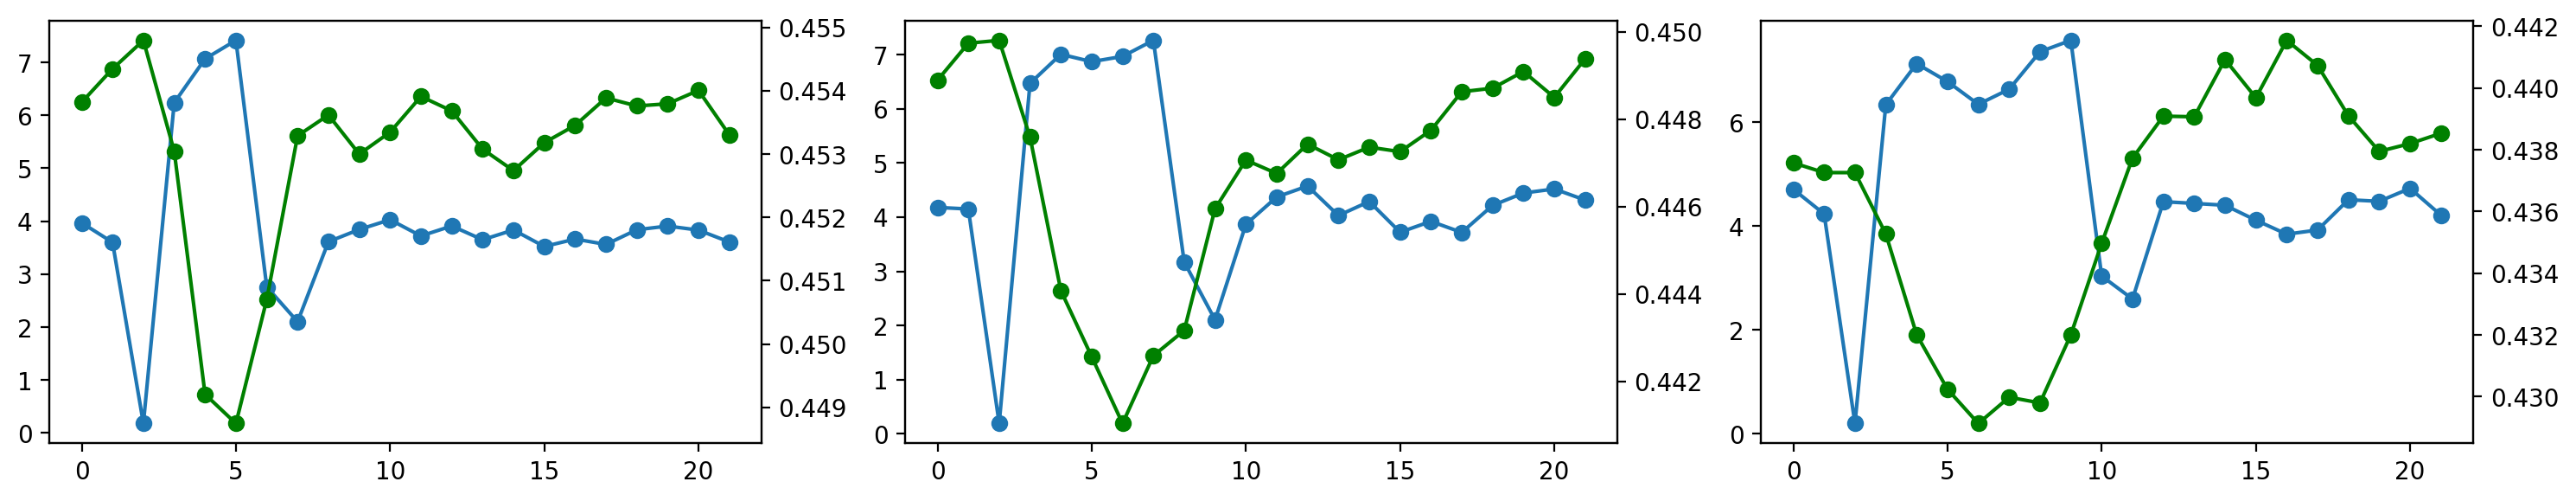

In [78]:
f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(131)
ax1 = ax.twinx()
ax.plot(ch3/chcnt3, marker='o')
ax1.plot(vod3/vodcnt3, color='green', marker='o')

ax = f.add_subplot(132)
ax1 = ax.twinx()
ax.plot(ch5/chcnt5, marker='o')
ax1.plot(vod5/vodcnt5, color='green', marker='o')

ax = f.add_subplot(133)
ax1 = ax.twinx()
ax.plot(ch7/chcnt7, marker='o')
ax1.plot(vod7/vodcnt7, color='green', marker='o')
plt.tight_layout()

In [79]:
dic_spells = {'southern' : {'chirps' : [ch3_so, ch5_so, ch7_so], 'chirps_cnt' : [chcnt3_so, chcnt5_so, chcnt7_so], 'vod' : [vod3_so, vod5_so, vod7_so], 'vod_cnt' : [vodcnt3_so, vodcnt5_so, vodcnt7_so], 'vodclim' : [vodclim3_so, vodclim5_so, vodclim7_so], 'vodclim_cnt' : [vodclimcnt3_so, vodclimcnt5_so, vodclimcnt7_so]}}

In [80]:
dic_spells['northern'] = {'chirps' : [ch3_eq, ch5_eq, ch7_eq], 'chirps_cnt' : [chcnt3_eq, chcnt5_eq, chcnt7_eq], 'vod' : [vod3_eq, vod5_eq, vod7_eq], 'vod_cnt' : [vodcnt3_eq, vodcnt5_eq, vodcnt7_eq], 'vodclim' : [vodclim3_eq, vodclim5_eq, vodclim7_eq], 'vodclim_cnt' : [vodclimcnt3_eq, vodclimcnt5_eq, vodclimcnt7_eq]}

In [81]:
dic_spells['central'] = {'chirps' : [ch3, ch5, ch7], 'chirps_cnt' : [chcnt3, chcnt5, chcnt7], 'vod' : [vod3, vod5, vod7], 'vod_cnt' : [vodcnt3, vodcnt5, vodcnt7], 'vodclim' : [vodclim3, vodclim5, vodclim7], 'vodclim_cnt' : [vodclimcnt3, vodclimcnt5, vodclimcnt7]}

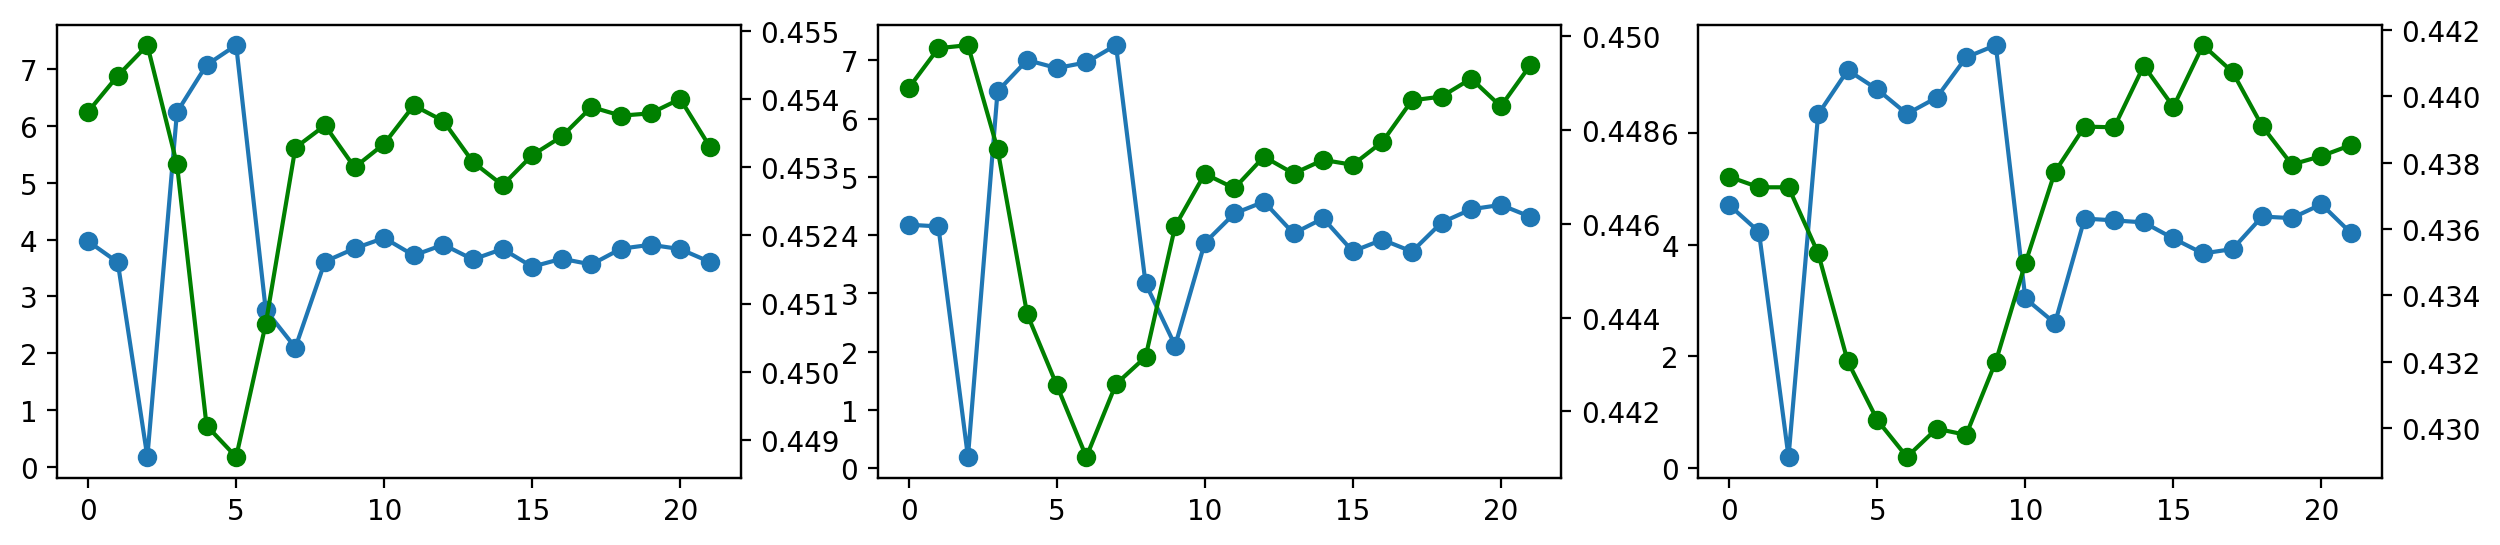

In [82]:
reg = 'central'
indx = 0

f = plt.figure(figsize=(15,3), dpi=200)
ax = f.add_subplot(131)
ax1 = ax.twinx()
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
ax1.plot(dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx], color='green', marker='o')

ax = f.add_subplot(132)
ax1 = ax.twinx()
indx=1
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
ax1.plot(dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx], color='green', marker='o')

ax = f.add_subplot(133)
ax1 = ax.twinx()
indx=2
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
ax1.plot(dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx], color='green', marker='o')

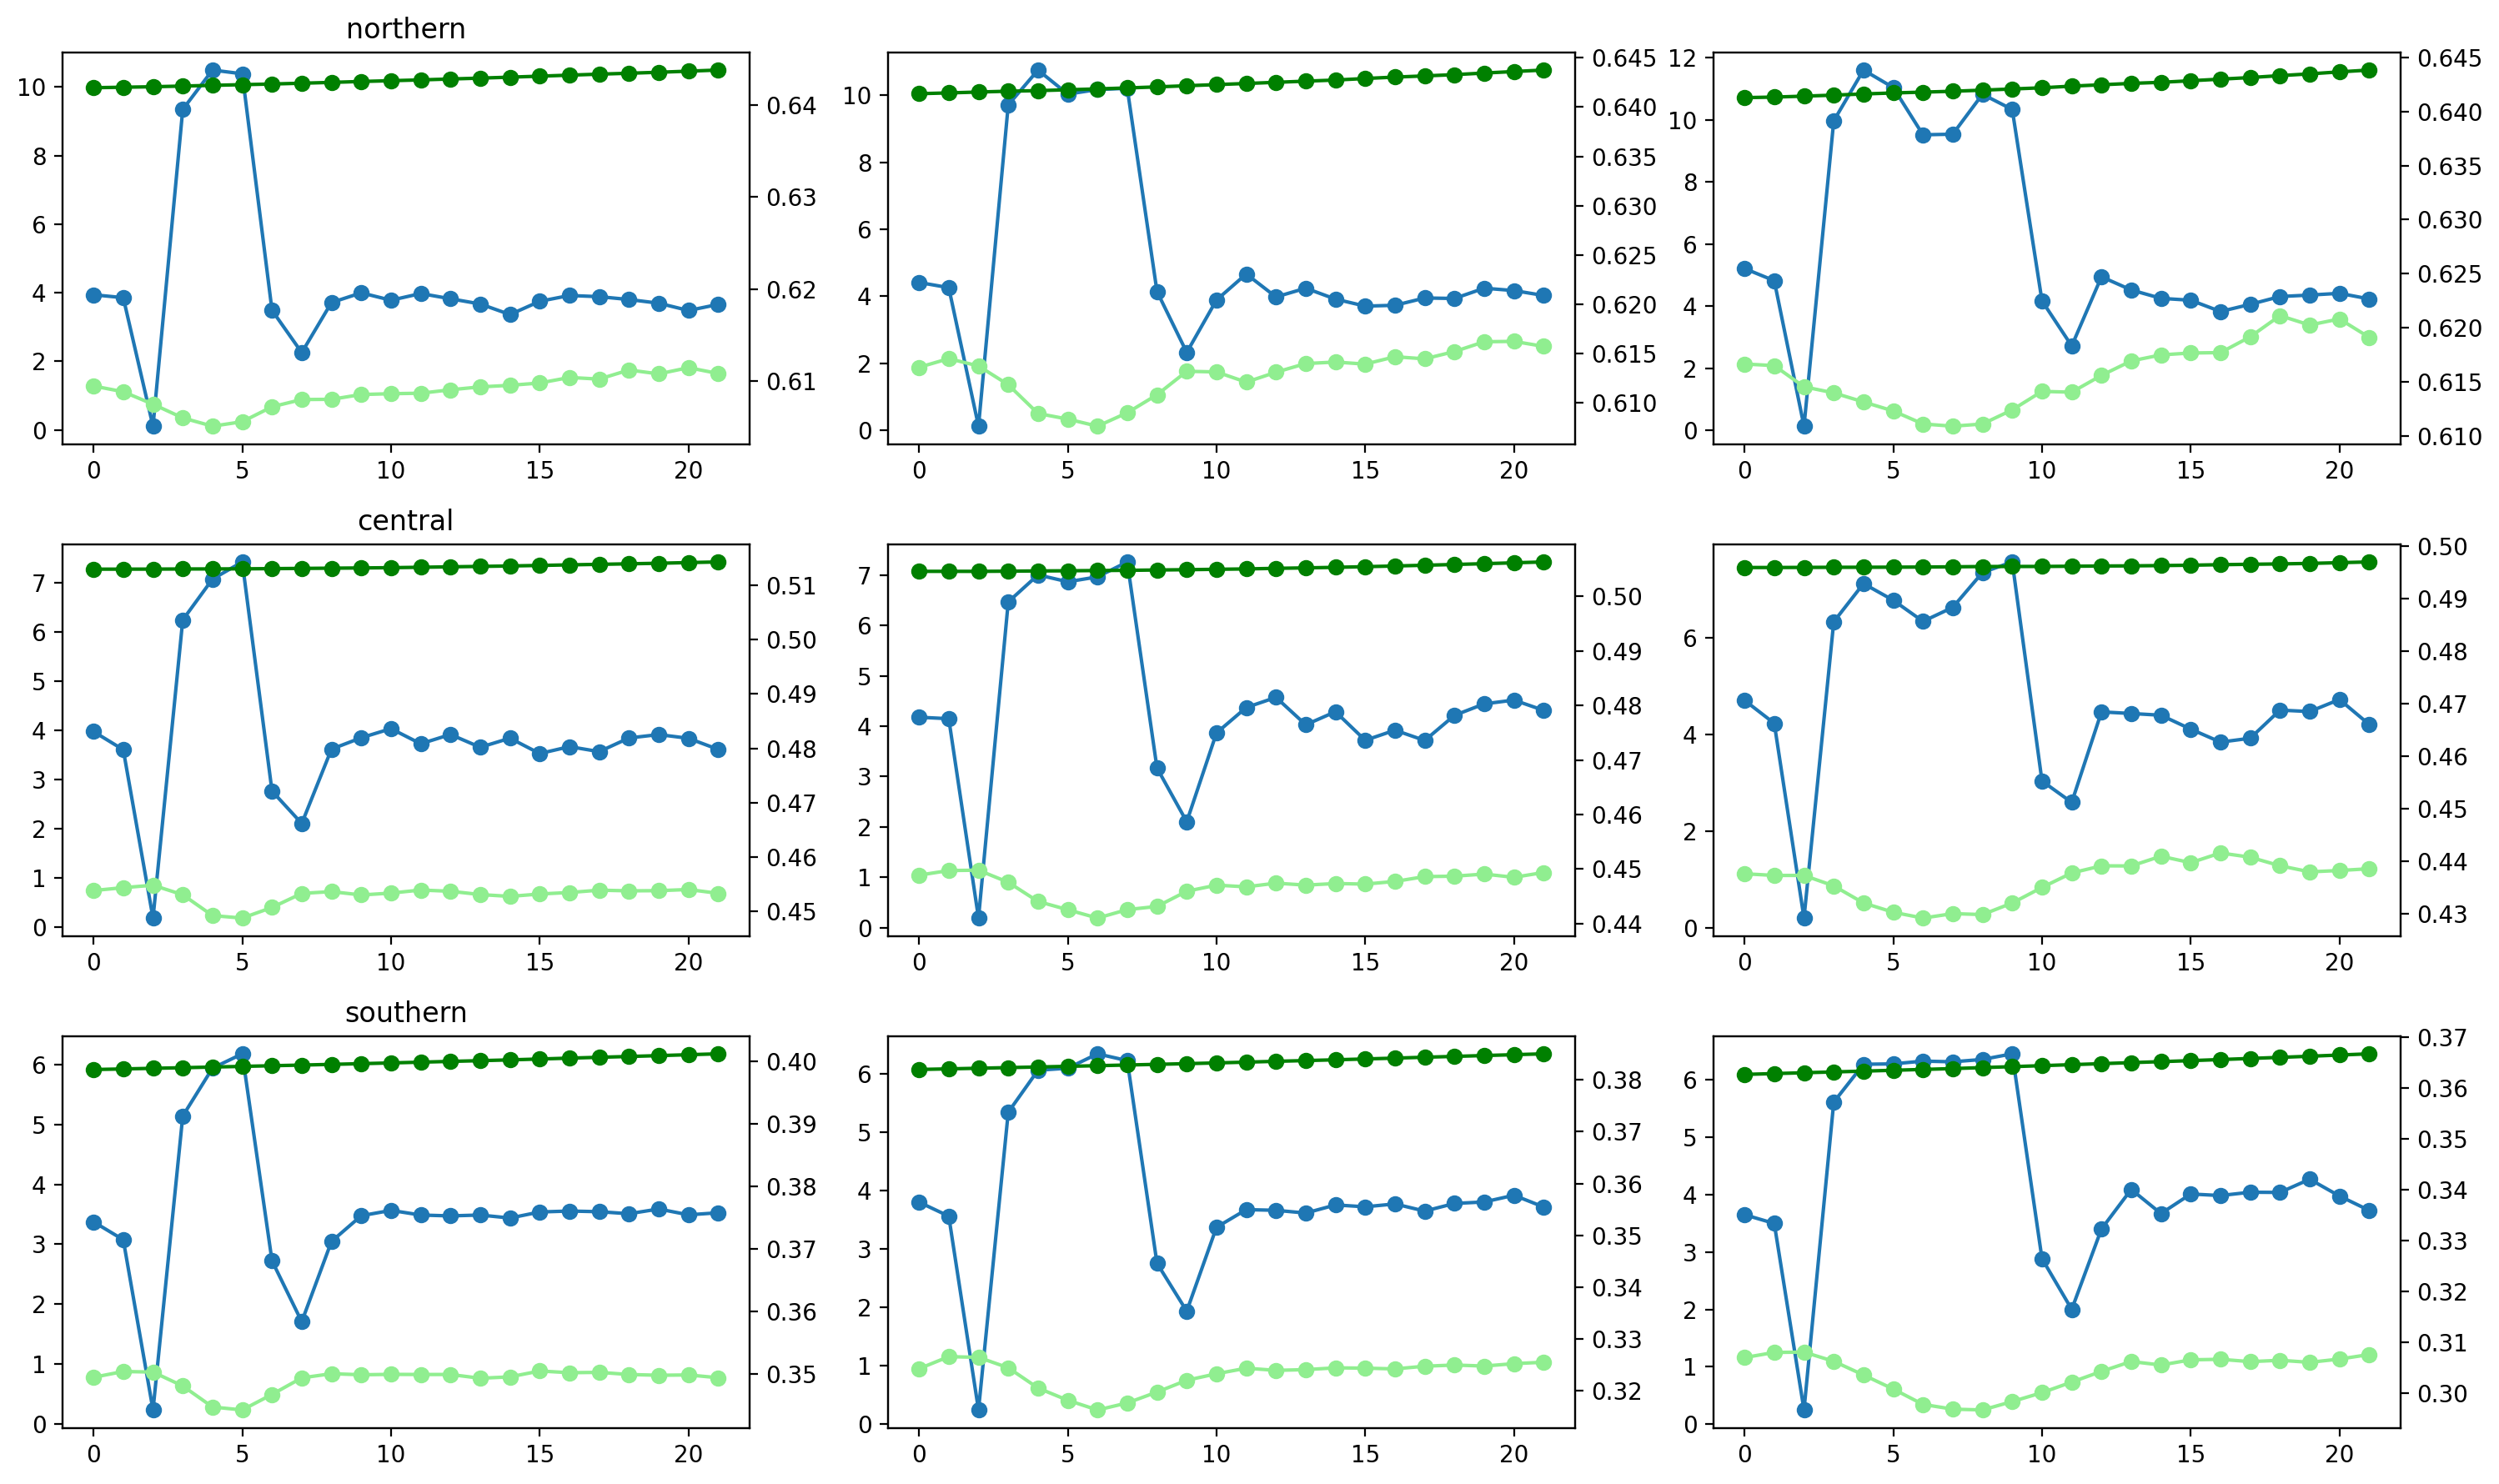

In [89]:
reg = 'northern'


f = plt.figure(figsize=(15,9), dpi=200)
ax = f.add_subplot(331)
ax1 = ax.twinx()
indx = 0
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')
plt.title(reg)

ax = f.add_subplot(332)
ax1 = ax.twinx()
indx=1
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')

ax = f.add_subplot(333)
ax1 = ax.twinx()
indx=2
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')





##################

reg = 'central'
ax = f.add_subplot(334)
ax1 = ax.twinx()
indx = 0
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')
plt.title(reg)

ax = f.add_subplot(335)
ax1 = ax.twinx()
indx=1
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')

ax = f.add_subplot(336)
ax1 = ax.twinx()
indx=2
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')



##################

reg = 'southern'
ax = f.add_subplot(337)
ax1 = ax.twinx()
indx = 0
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')
plt.title(reg)

ax = f.add_subplot(338)
ax1 = ax.twinx()
indx=1
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')

ax = f.add_subplot(339)
ax1 = ax.twinx()
indx=2
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vodp = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot(clim, color='green', marker='o')
ax1.plot(vodp, color='lightgreen', marker='o')

plt.tight_layout()


Text(0.5, 1.0, 'southern')

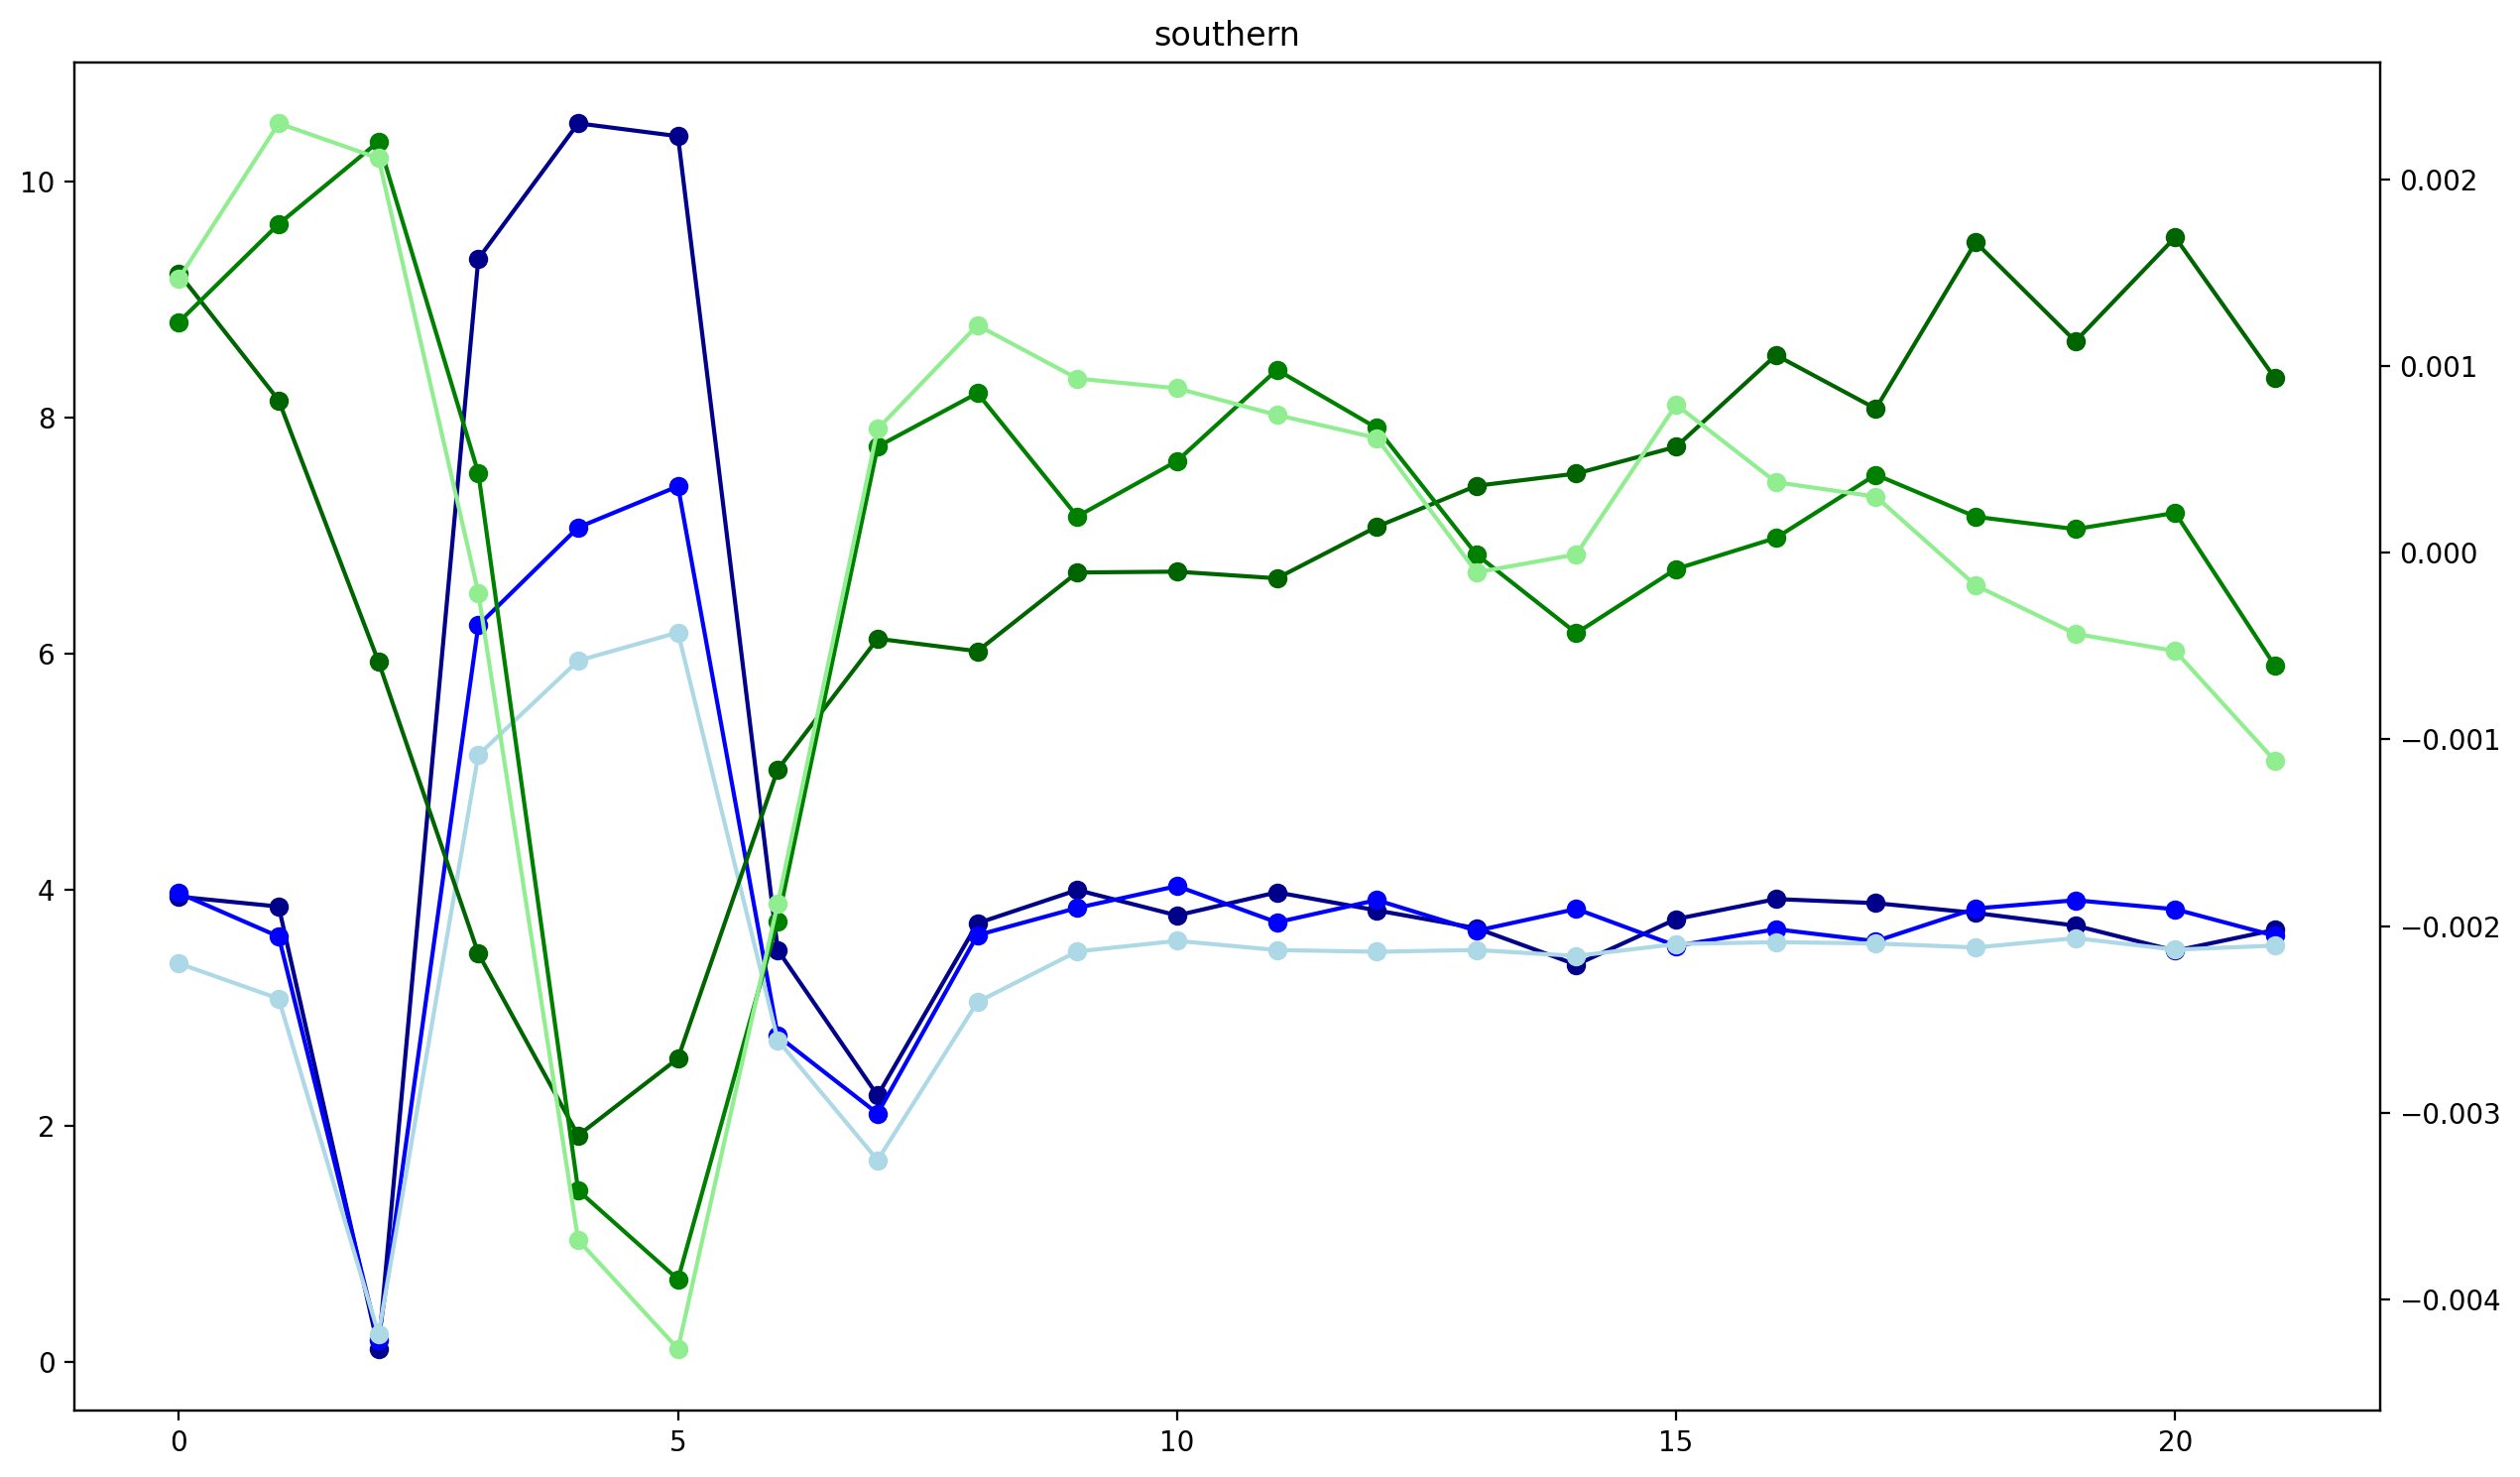

In [83]:


f = plt.figure(figsize=(15,9), dpi=200)
ax = f.add_subplot(111)
reg = 'northern'
ax1 = ax.twinx()
indx = 0
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='darkblue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='darkgreen', marker='o')
plt.title(reg)


reg='central'

ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='blue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='green', marker='o')
plt.title(reg)

reg='southern'

ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='lightblue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='lightgreen', marker='o')
plt.title(reg)

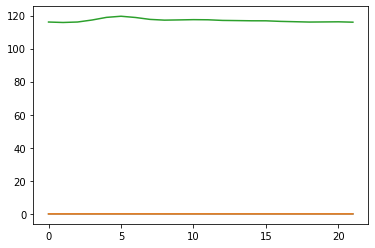

In [67]:
plt.plot((vod-clim)-np.mean(vod-clim))
plt.plot(vod-np.mean(vod))
plt.plot(vod/np.std(vod))

Text(0.5, 1.0, 'southern')

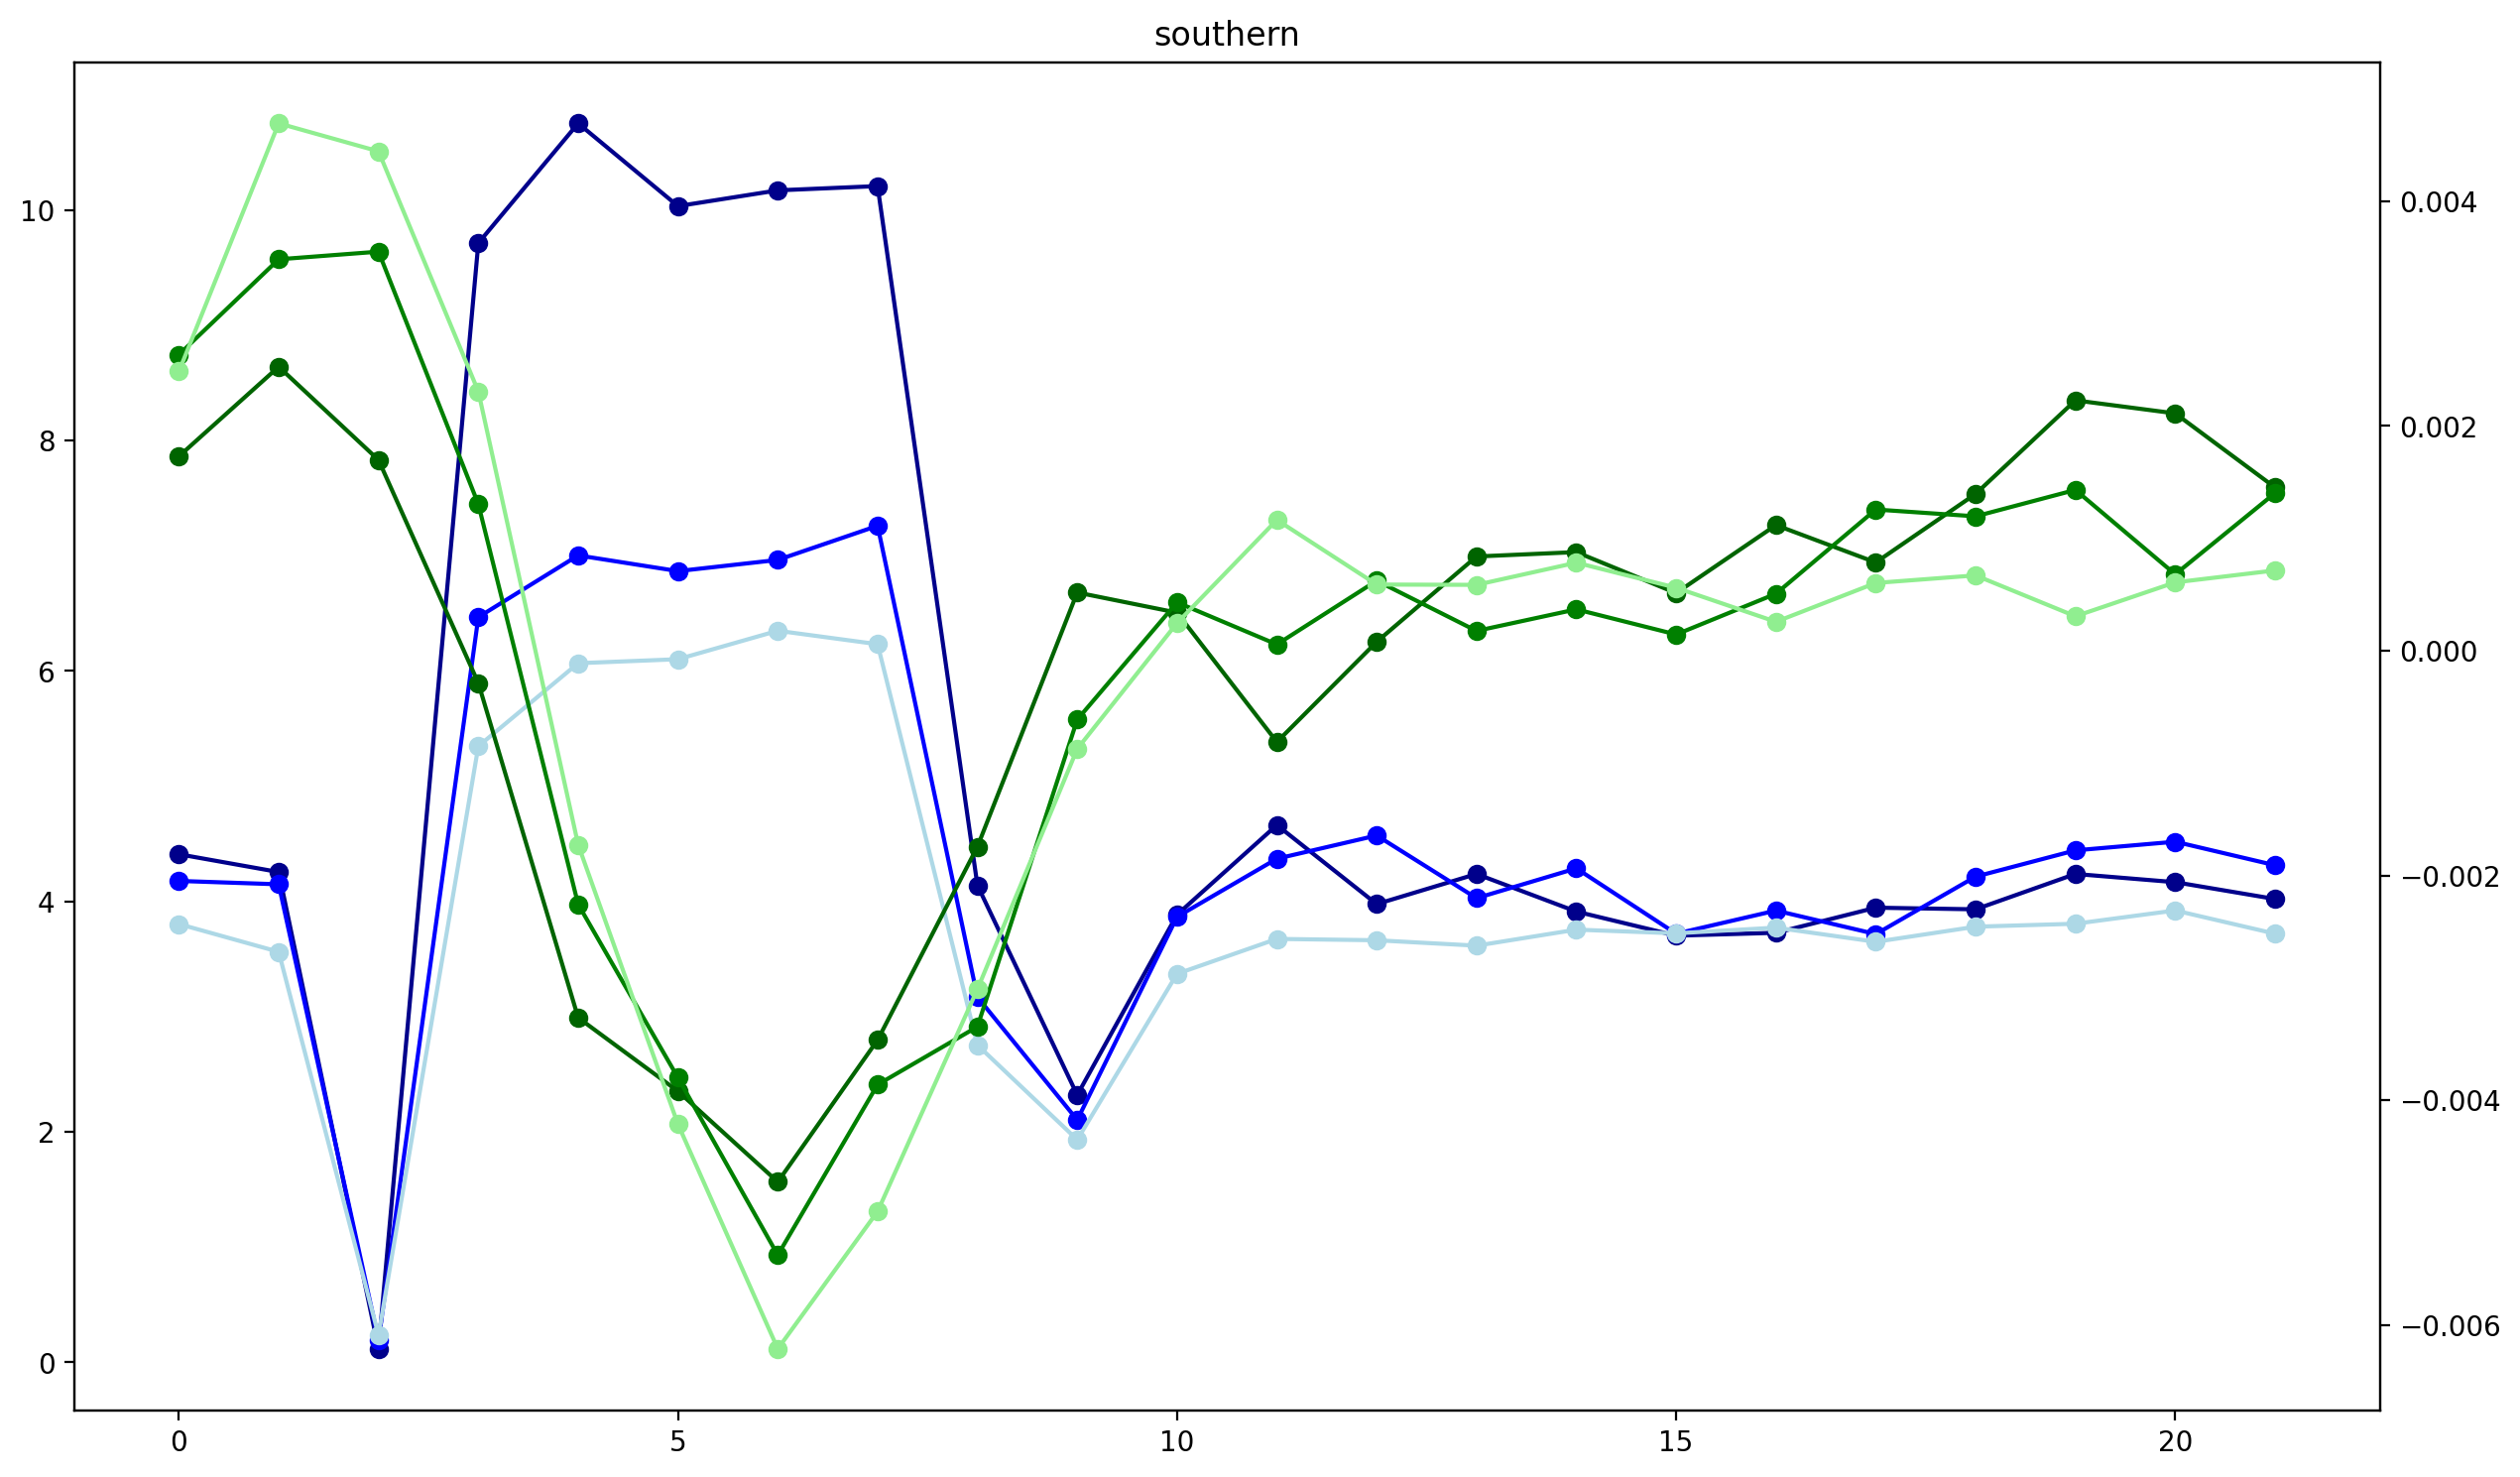

In [84]:


f = plt.figure(figsize=(15,9), dpi=200)
ax = f.add_subplot(111)
reg = 'northern'
ax1 = ax.twinx()
indx = 1
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='darkblue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='darkgreen', marker='o')
plt.title(reg)


reg='central'

ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='blue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='green', marker='o')
plt.title(reg)

reg='southern'

ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='lightblue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='lightgreen', marker='o')
plt.title(reg)

Text(0.5, 1.0, 'southern')

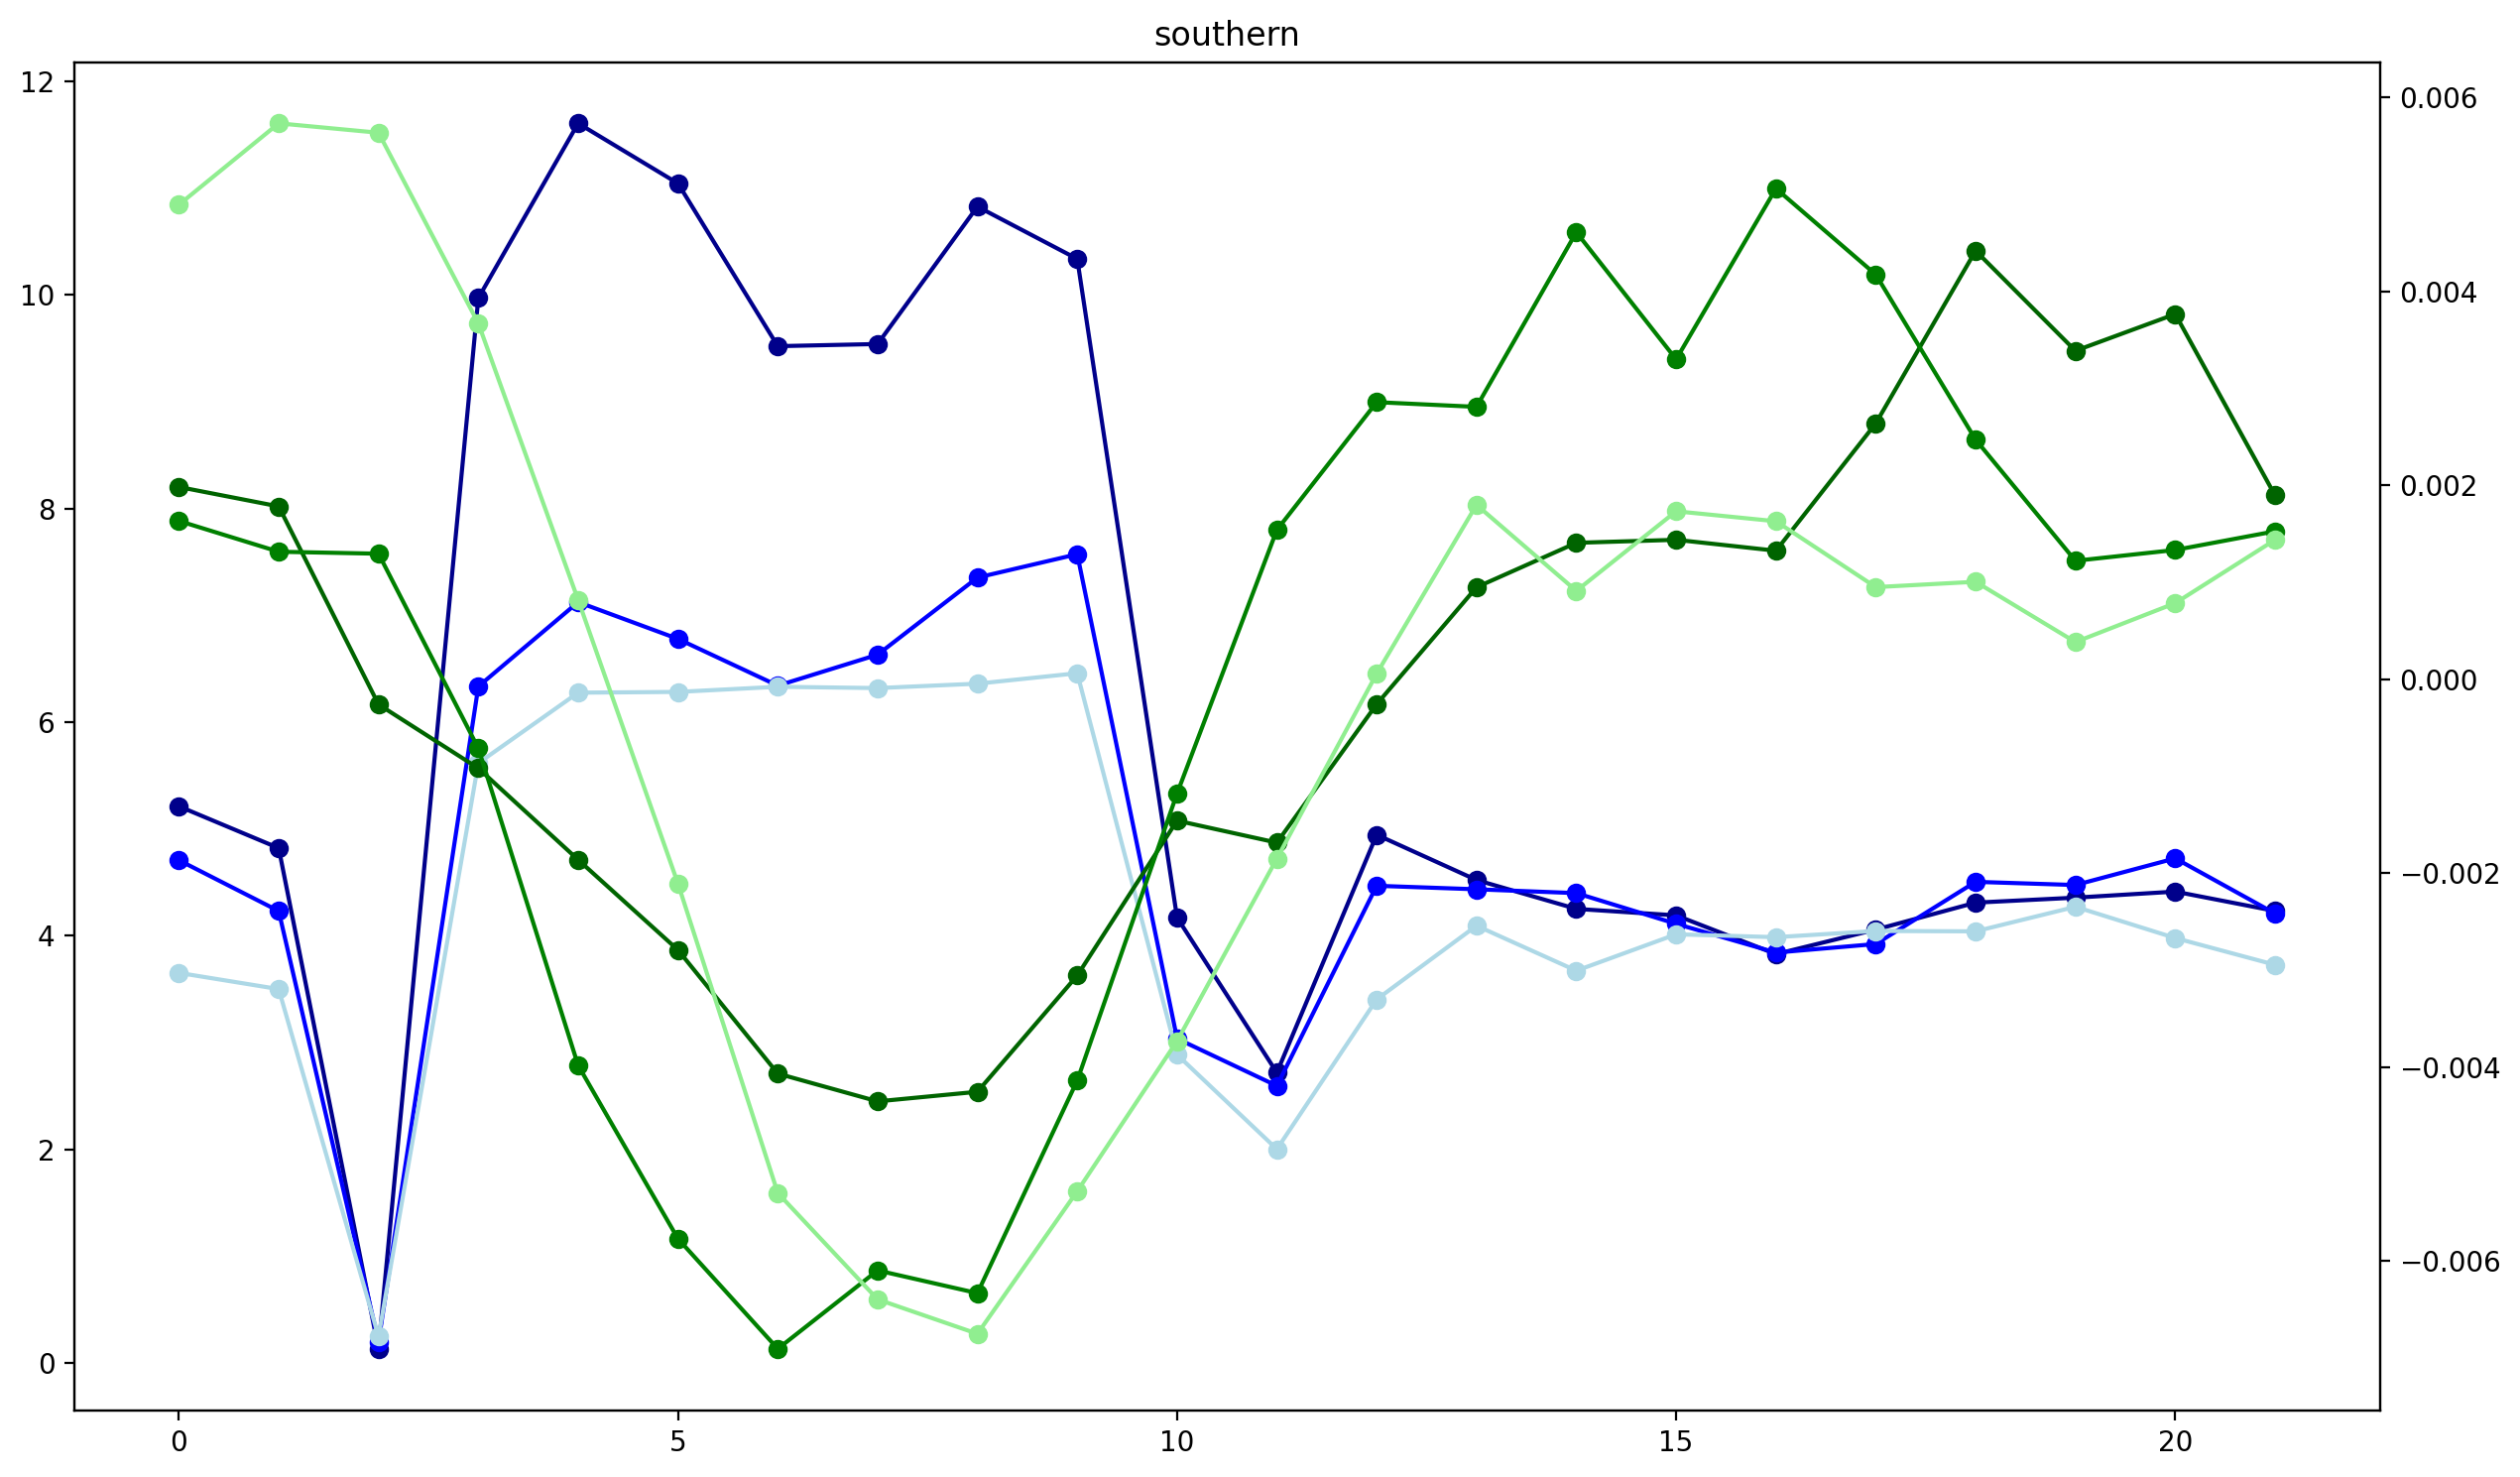

In [85]:

f = plt.figure(figsize=(15,9), dpi=200)
ax = f.add_subplot(111)
reg = 'northern'
ax1 = ax.twinx()
indx = 2
ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='darkblue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='darkgreen', marker='o')
plt.title(reg)


reg='central'

ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='blue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='green', marker='o')
plt.title(reg)

reg='southern'

ax.plot(dic_spells[reg]['chirps'][indx]/dic_spells[reg]['chirps_cnt'][indx], marker='o', color='lightblue')
clim = dic_spells[reg]['vodclim'][indx]/dic_spells[reg]['vodclim_cnt'][indx]
vod = (dic_spells[reg]['vod'][indx]/dic_spells[reg]['vod_cnt'][indx])
ax1.plot((vod-clim)-np.mean(vod-clim), color='lightgreen', marker='o')
plt.title(reg)

In [86]:
# import pickle as pkl
# path = '/media/ck/Elements/SouthAmerica/CHIRPS/'
# pkl.dump(dic_spells, open(path+"wet_spells_dictionary_regions.p", "wb"))